In [27]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime, timedelta, time
import learning_lidar.utils.global_settings as gs
import pandas as pd
import learning_lidar.preprocessing.preprocessing as prep
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from learning_lidar.generation.daily_signals_generations_utils import calc_r2_ds,get_daily_bg
import learning_lidar.generation.generation_utils as gen_utils
from learning_lidar.dataseting.dataseting import calc_data_statistics
from learning_lidar.utils.proc_utils import  normalize
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from tqdm import tqdm
gs.set_visualization_settings()

In [2]:
def daily_ds_histogram(dataset, profile_type='range_corr',
                       nbins=100, log_scale=False,
                       SAVE_FIG = False , dst_folder = os.path.join ( '..' , 'Figures' )
                       , format_fig = 'png'):
    date_datetime = prep.get_daily_ds_date ( dataset )
    ds_profile = dataset.get(profile_type)
    df_stats = pd.DataFrame(columns=['wavelength [nm]', 'valid size %',
                                     'positive %', 'negative %','zeros %',
                                     'mean' , 'std'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6),sharey=True)
    ax = axes
    th = gs.eps
    for ind,(wavelength) in enumerate(dataset.Wavelength.values):
        sub_ds = ds_profile.sel(Wavelength = wavelength)
        mask_valid = (~pd.isna(sub_ds.values))
        valid_size = mask_valid.astype(int).sum()
        orig_size = sub_ds.values.size

        # positive values histogram
        pos_ds = sub_ds.where(sub_ds > th).where(sub_ds != np.nan)#.values
        pos_vals = pos_ds.values[~np.isnan(pos_ds.values)]
        pos_size = pos_vals.size

        hist, bins =np.histogram(pos_vals , bins=nbins)
        min_bin = bins[0] if bins[0]>0 else bins[0]+gs.eps
        max_bin = bins[-1]
        logbins = np.logspace(np.log10(min_bin),np.log10(max_bin),len(bins))
        ax.hist(pos_vals, bins=logbins, label = f"$\lambda={wavelength}$",
                   alpha=0.4)

        if log_scale:
            ax.set_xscale('symlog')

        #negative values histogram
        neg_ds = sub_ds.where(sub_ds < -th).where(sub_ds != np.nan )#.values
        neg_vals= neg_ds.values[~np.isnan(neg_ds.values)]
        neg_size = neg_vals.size


        # Zero values histogram
        zero_ds= sub_ds.where(sub_ds >= -th).where(sub_ds <=th).where(sub_ds != np.nan )
        zero_vals= zero_ds.values[~np.isnan(zero_ds.values)]
        zero_size = zero_vals.size

        df_stats.loc[ind] = [wavelength,
                            100.0*valid_size/orig_size,
                            100.0*pos_size/orig_size ,
                            100.0*neg_size/orig_size ,
                            100.0*zero_size/orig_size,
                            sub_ds.mean().values,
                            sub_ds.std().values]
        # TODO : take care of representation after the digit values

    ax.legend()
    min_val, max_val = float(ds_profile.min().values),float(ds_profile.max().values)
    ax.set_xlim([min_val,max_val+0.1*(max_val-min_val)])
    ax.set_ylabel('counts')
    ax.tick_params(axis='both', which='major')

    xlabels = f"{ds_profile.long_name} [{ds_profile.units}]"
    ax.set_xlabel(xlabels, horizontalalignment='center')
    axes.ticklabel_format(axis='y', style="sci",scilimits=(0,0))
    stitle = f"Histogram of {ds_profile.info.lower()} " \
             f"\n {dataset.attrs['location']} {date_datetime.strftime('%Y-%m-%d')}"
    fig.suptitle(stitle)

    plt.tight_layout()
    plt.show()

    if SAVE_FIG :
        fname = f"{date_datetime.strftime ( '%Y-%m-%d' )}_{dataset.attrs ['location']}_{profile_type}_" \
                f"source_{dataset.attrs['source_type']}_histogram.{format_fig}"
        if not os.path.exists ( dst_folder ) :
            try :
                os.makedirs ( dst_folder , exist_ok = True )
                print (f"Creating folder: {dst_folder}") # logger.debug ( f"Creating folder: {dst_folder}" )
            except Exception :
                raise OSError ( f"Failed to create folder: {dst_folder}" )
        fpath = os.path.join ( dst_folder , fname )
        fig.savefig(fpath,bbox_inches='tight', format = format_fig)
        print(f"Figure saved at {fpath}") # logger.debug ( f"Figure saved at {fpath}" )
    return fig,axes,df_stats

In [21]:
station_name = 'haifa_shubi_external'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()
dates = [datetime(2017,9,1), datetime(2017,9,2),datetime(2017,10,2),datetime(2017,10,15)]
dt_day = dates[0]
r2_da = calc_r2_ds(station, dt_day)
main_folder = os.path.dirname(os.path.abspath(os.path.curdir))
data_folder = os.path.join(os.path.dirname(os.path.abspath(os.path.curdir)), 'data')
times = [dt_day+ timedelta(hours=9),
         dt_day+ timedelta(hours=12),
         dt_day+ timedelta(hours=15),
         dt_day+ timedelta(hours=18)]

# 1. Optical Density signal


# 2. Background signal
# TODO: test transformers on bg_ds.bg and bg_r2

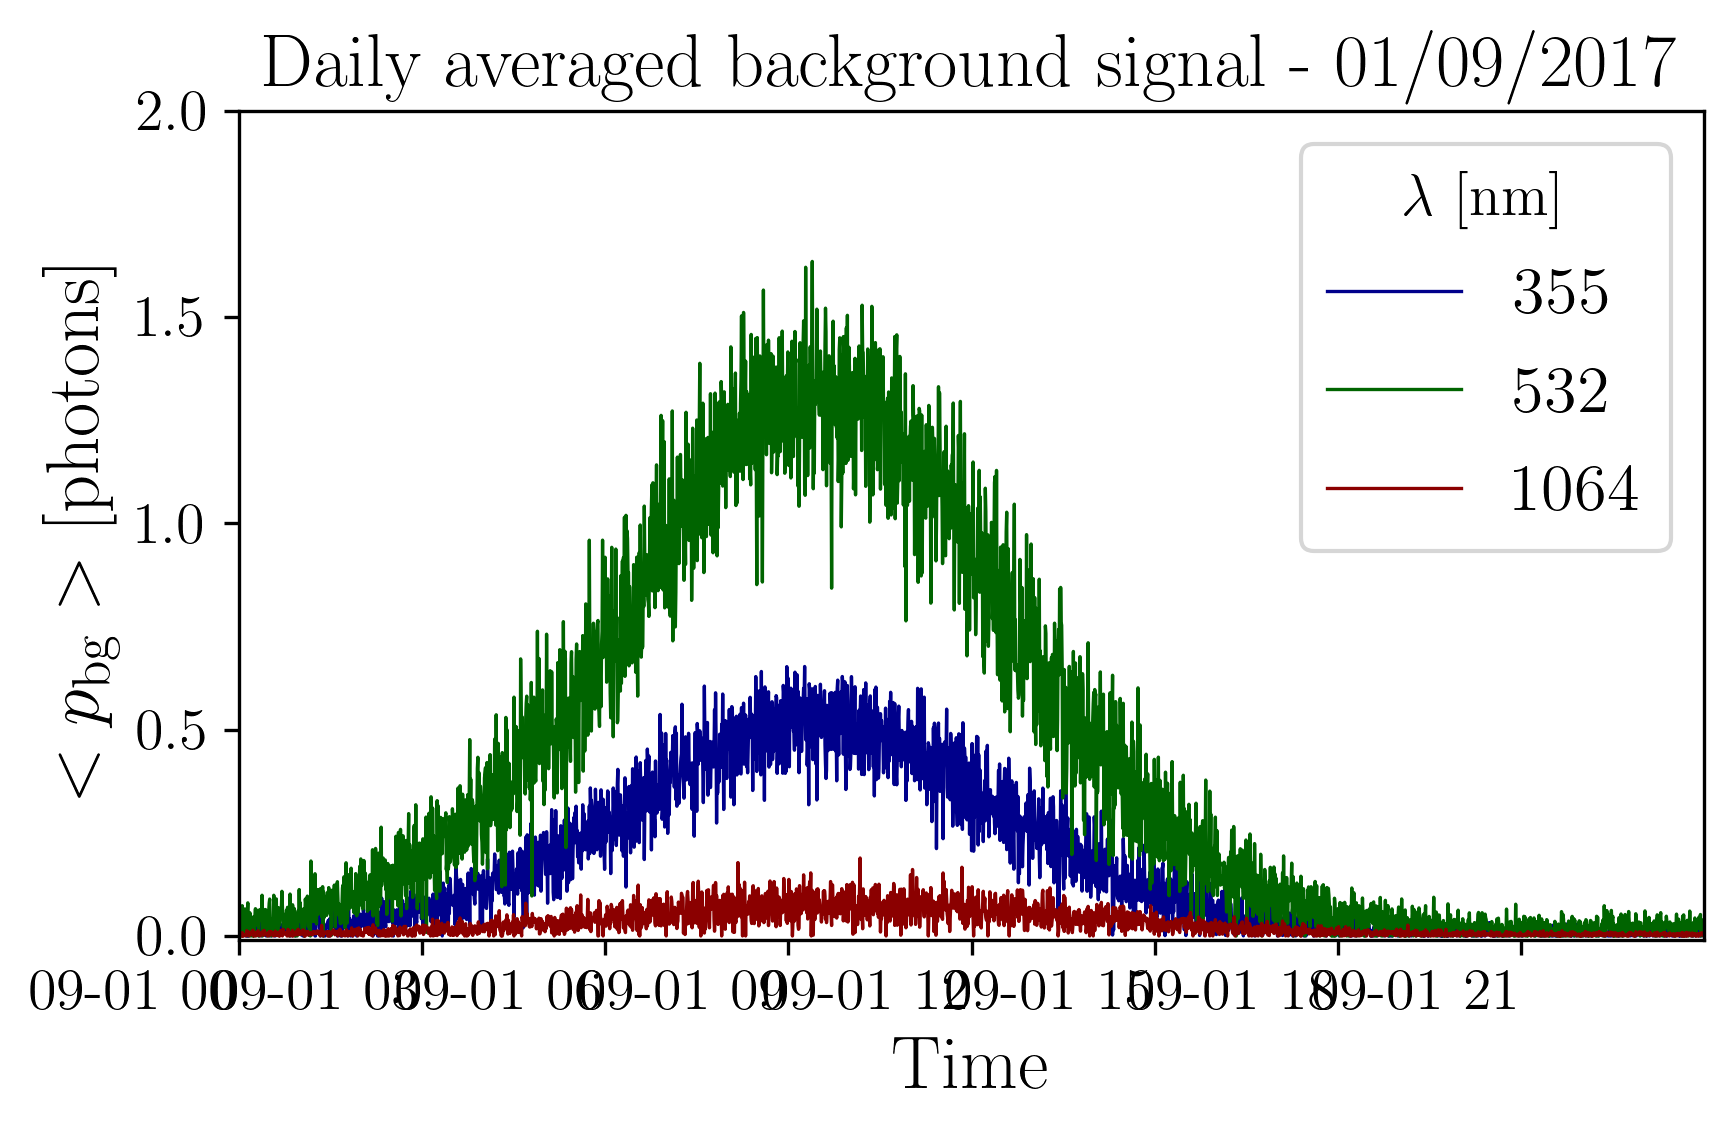

In [4]:
p_bg = get_daily_bg(station, dt_day)  # daily background: p_bg
# Expand p_bg to coordinates : 'Wavelength','Height', 'Time
bg_ds = p_bg.broadcast_like(r2_da).to_dataset()
bg_ds['date'] = dt_day
bg_ds.attrs['location'] = station.location

# gen_utils.plot_daily_profile(bg_ds.bg, figsize=(21,7))

## BG

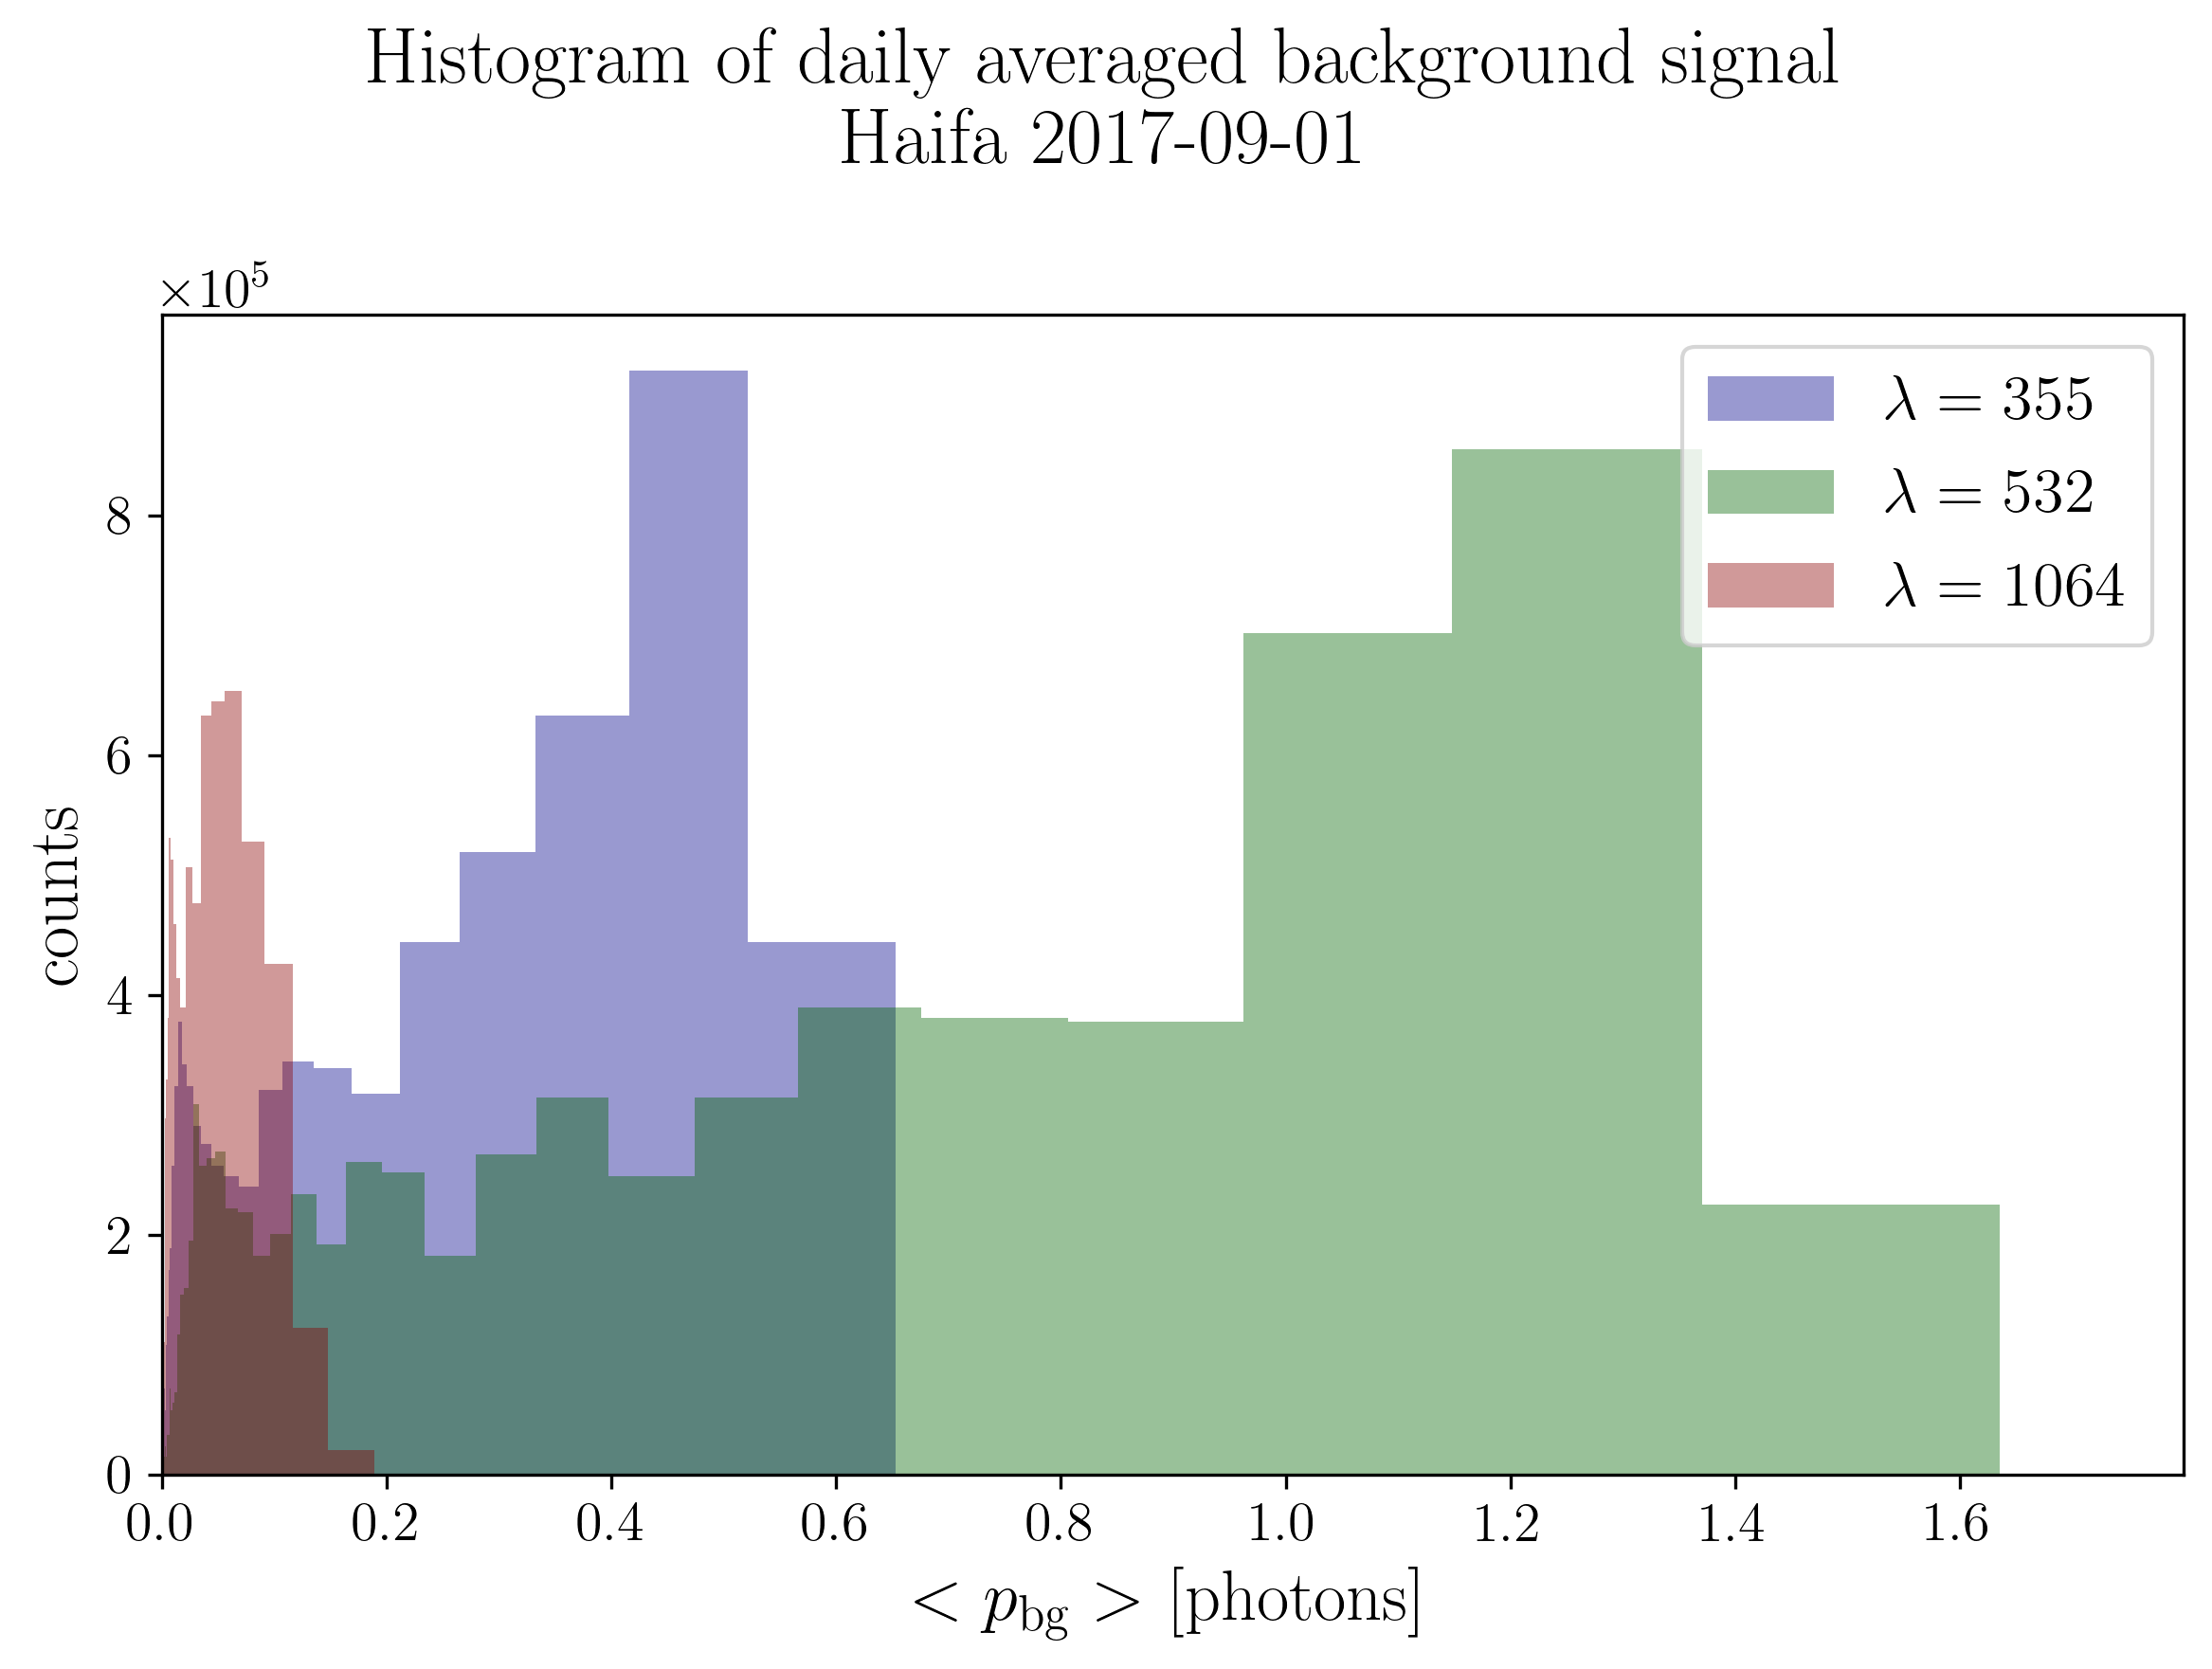

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,94.548611,0.0,5.451389,0.16941153428584965,0.18337823816034243
1,532,100.0,95.243056,0.0,4.756944,0.44020476905857814,0.46210333016975924
2,1064,100.0,93.506944,0.0,6.493056,0.030408071729167627,0.03179980653110185


In [42]:
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg',nbins=50)
bg_stats


## BG Power

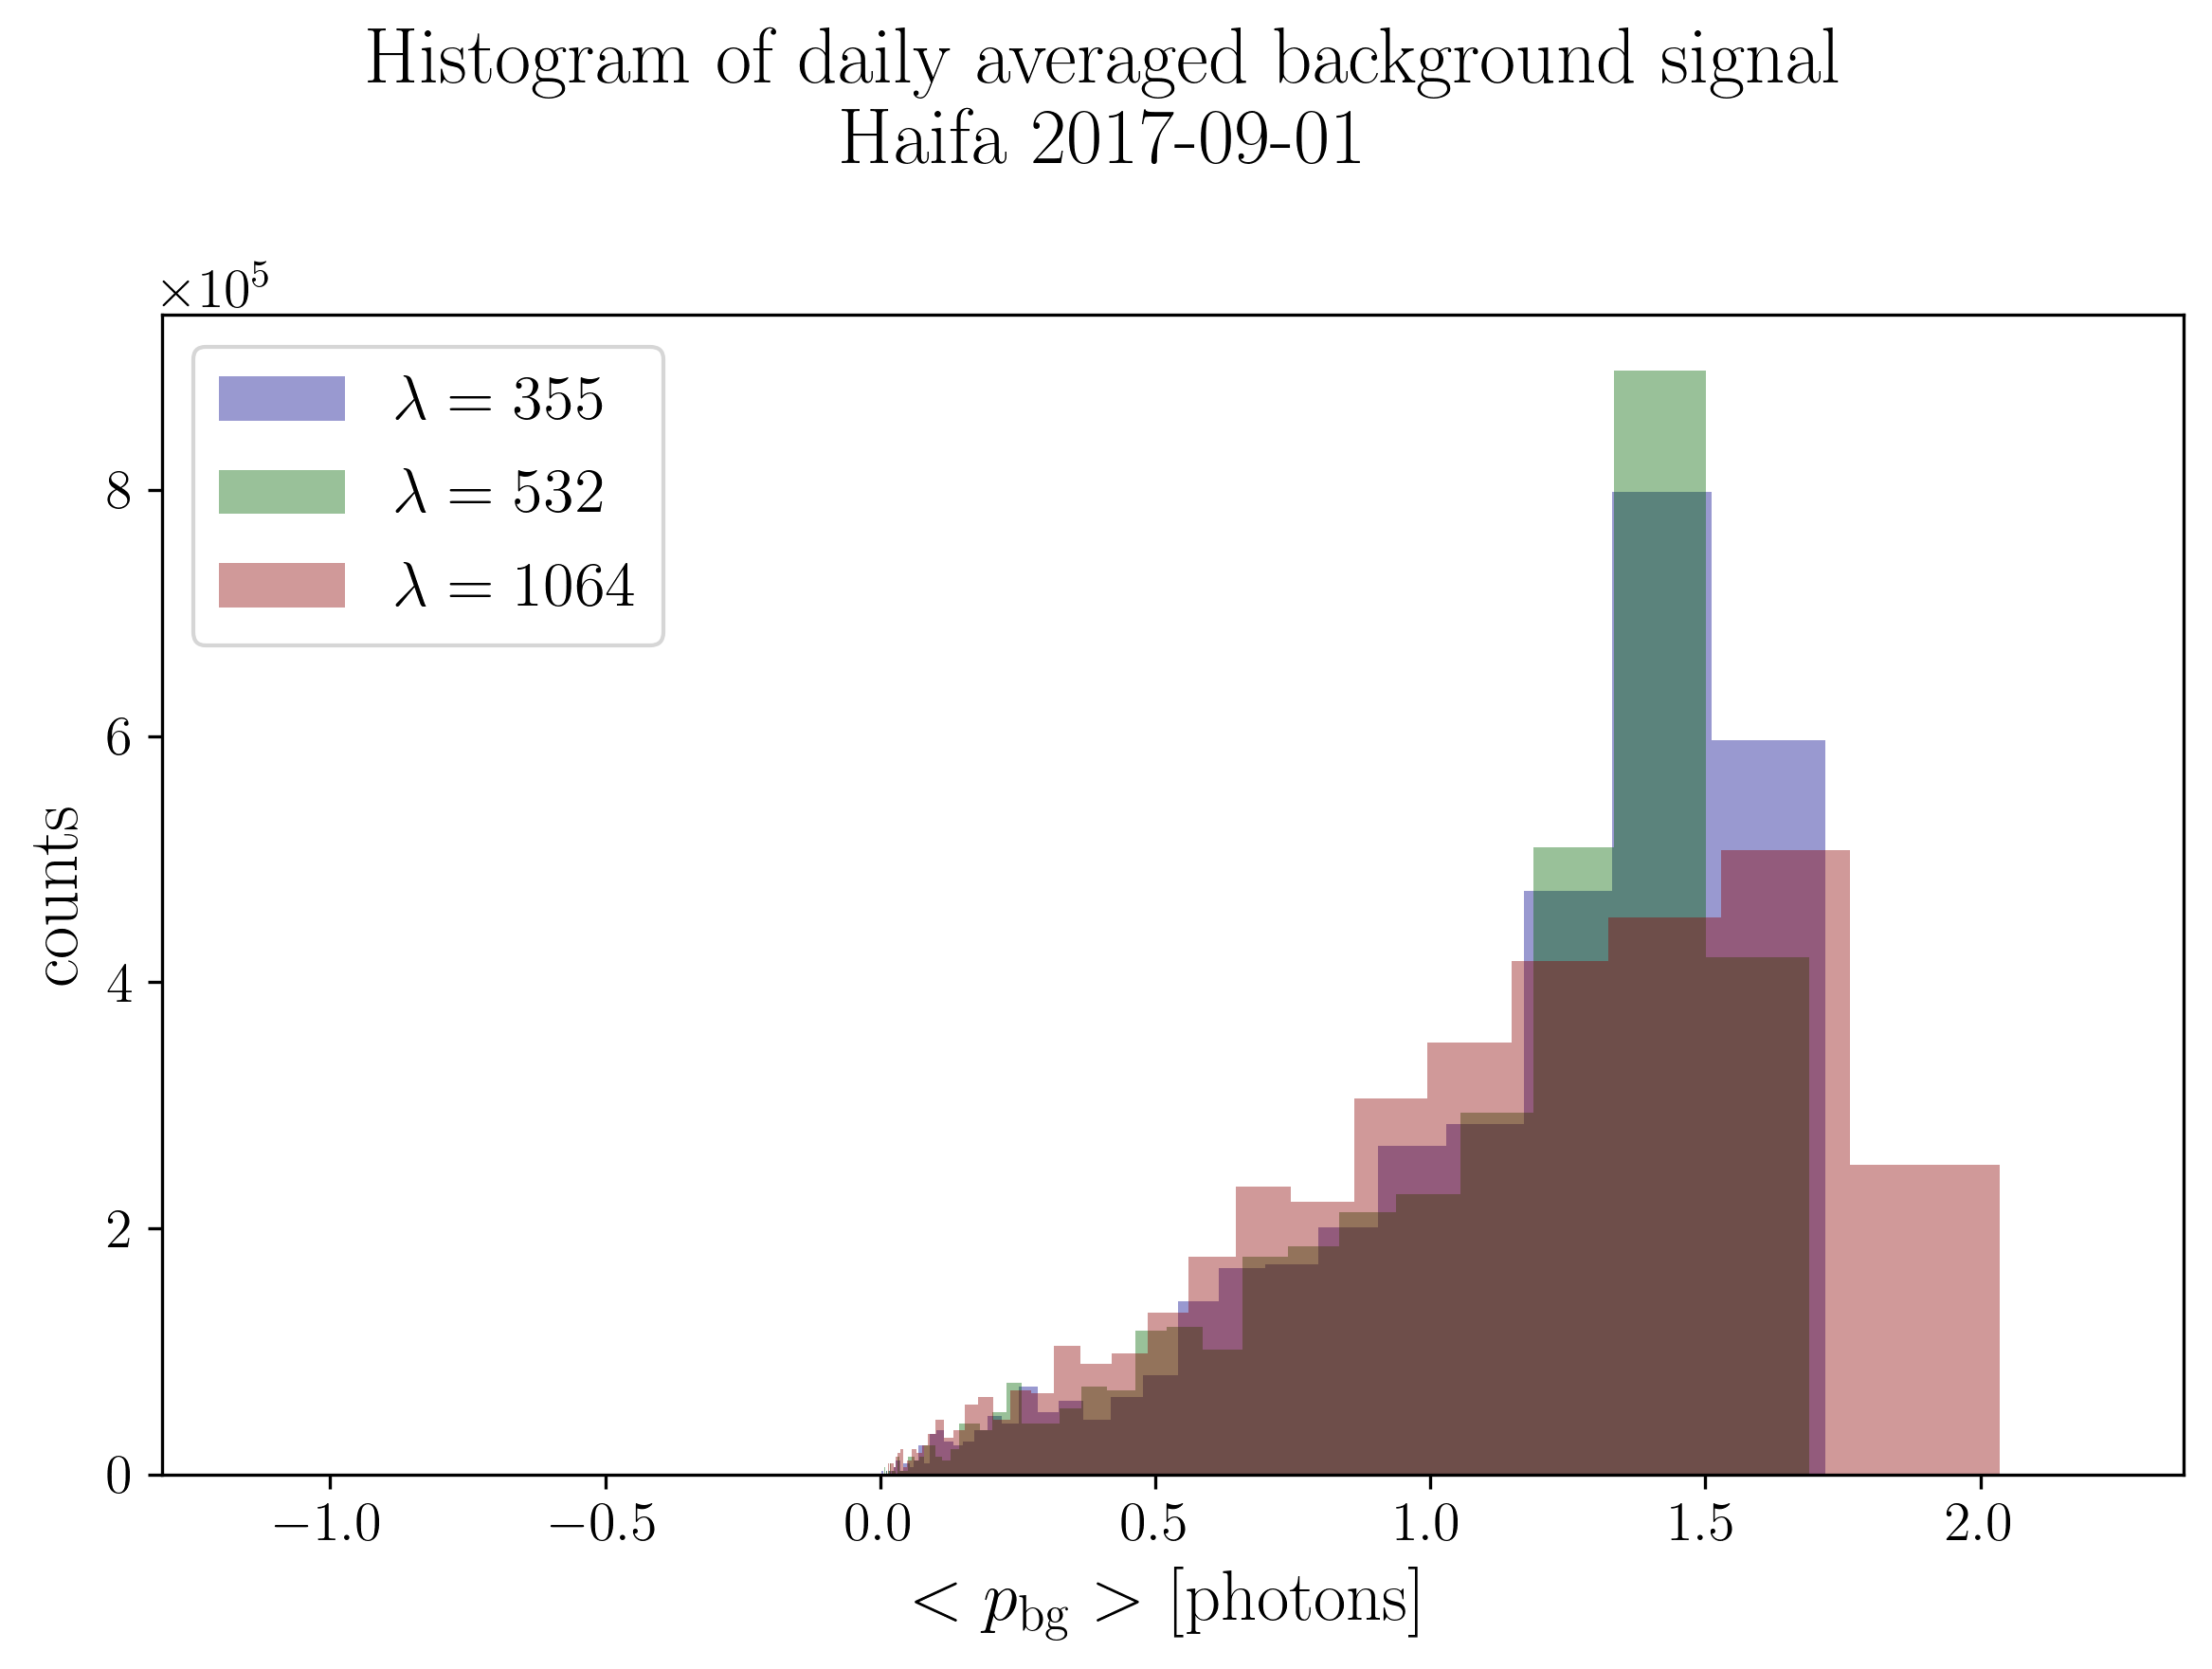

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,44.895833,55.104167,0.0,7.59885981298996e-16,0.9999999999999993
1,532,100.0,46.354167,53.645833,0.0,4.958272475724462e-16,1.0000000000000022
2,1064,100.0,45.902778,54.097222,0.0,-4.320626161373824e-15,0.9999999999999998


In [6]:
pt = PowerTransformer()
bg_pow_data = pt.fit_transform(bg_ds.bg.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
bg_ds = bg_ds.assign(bg_pow = (bg_ds.bg.sizes, bg_pow_data))
bg_ds.bg_pow.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_pow',nbins=50)
bg_stats

## BG Quantile

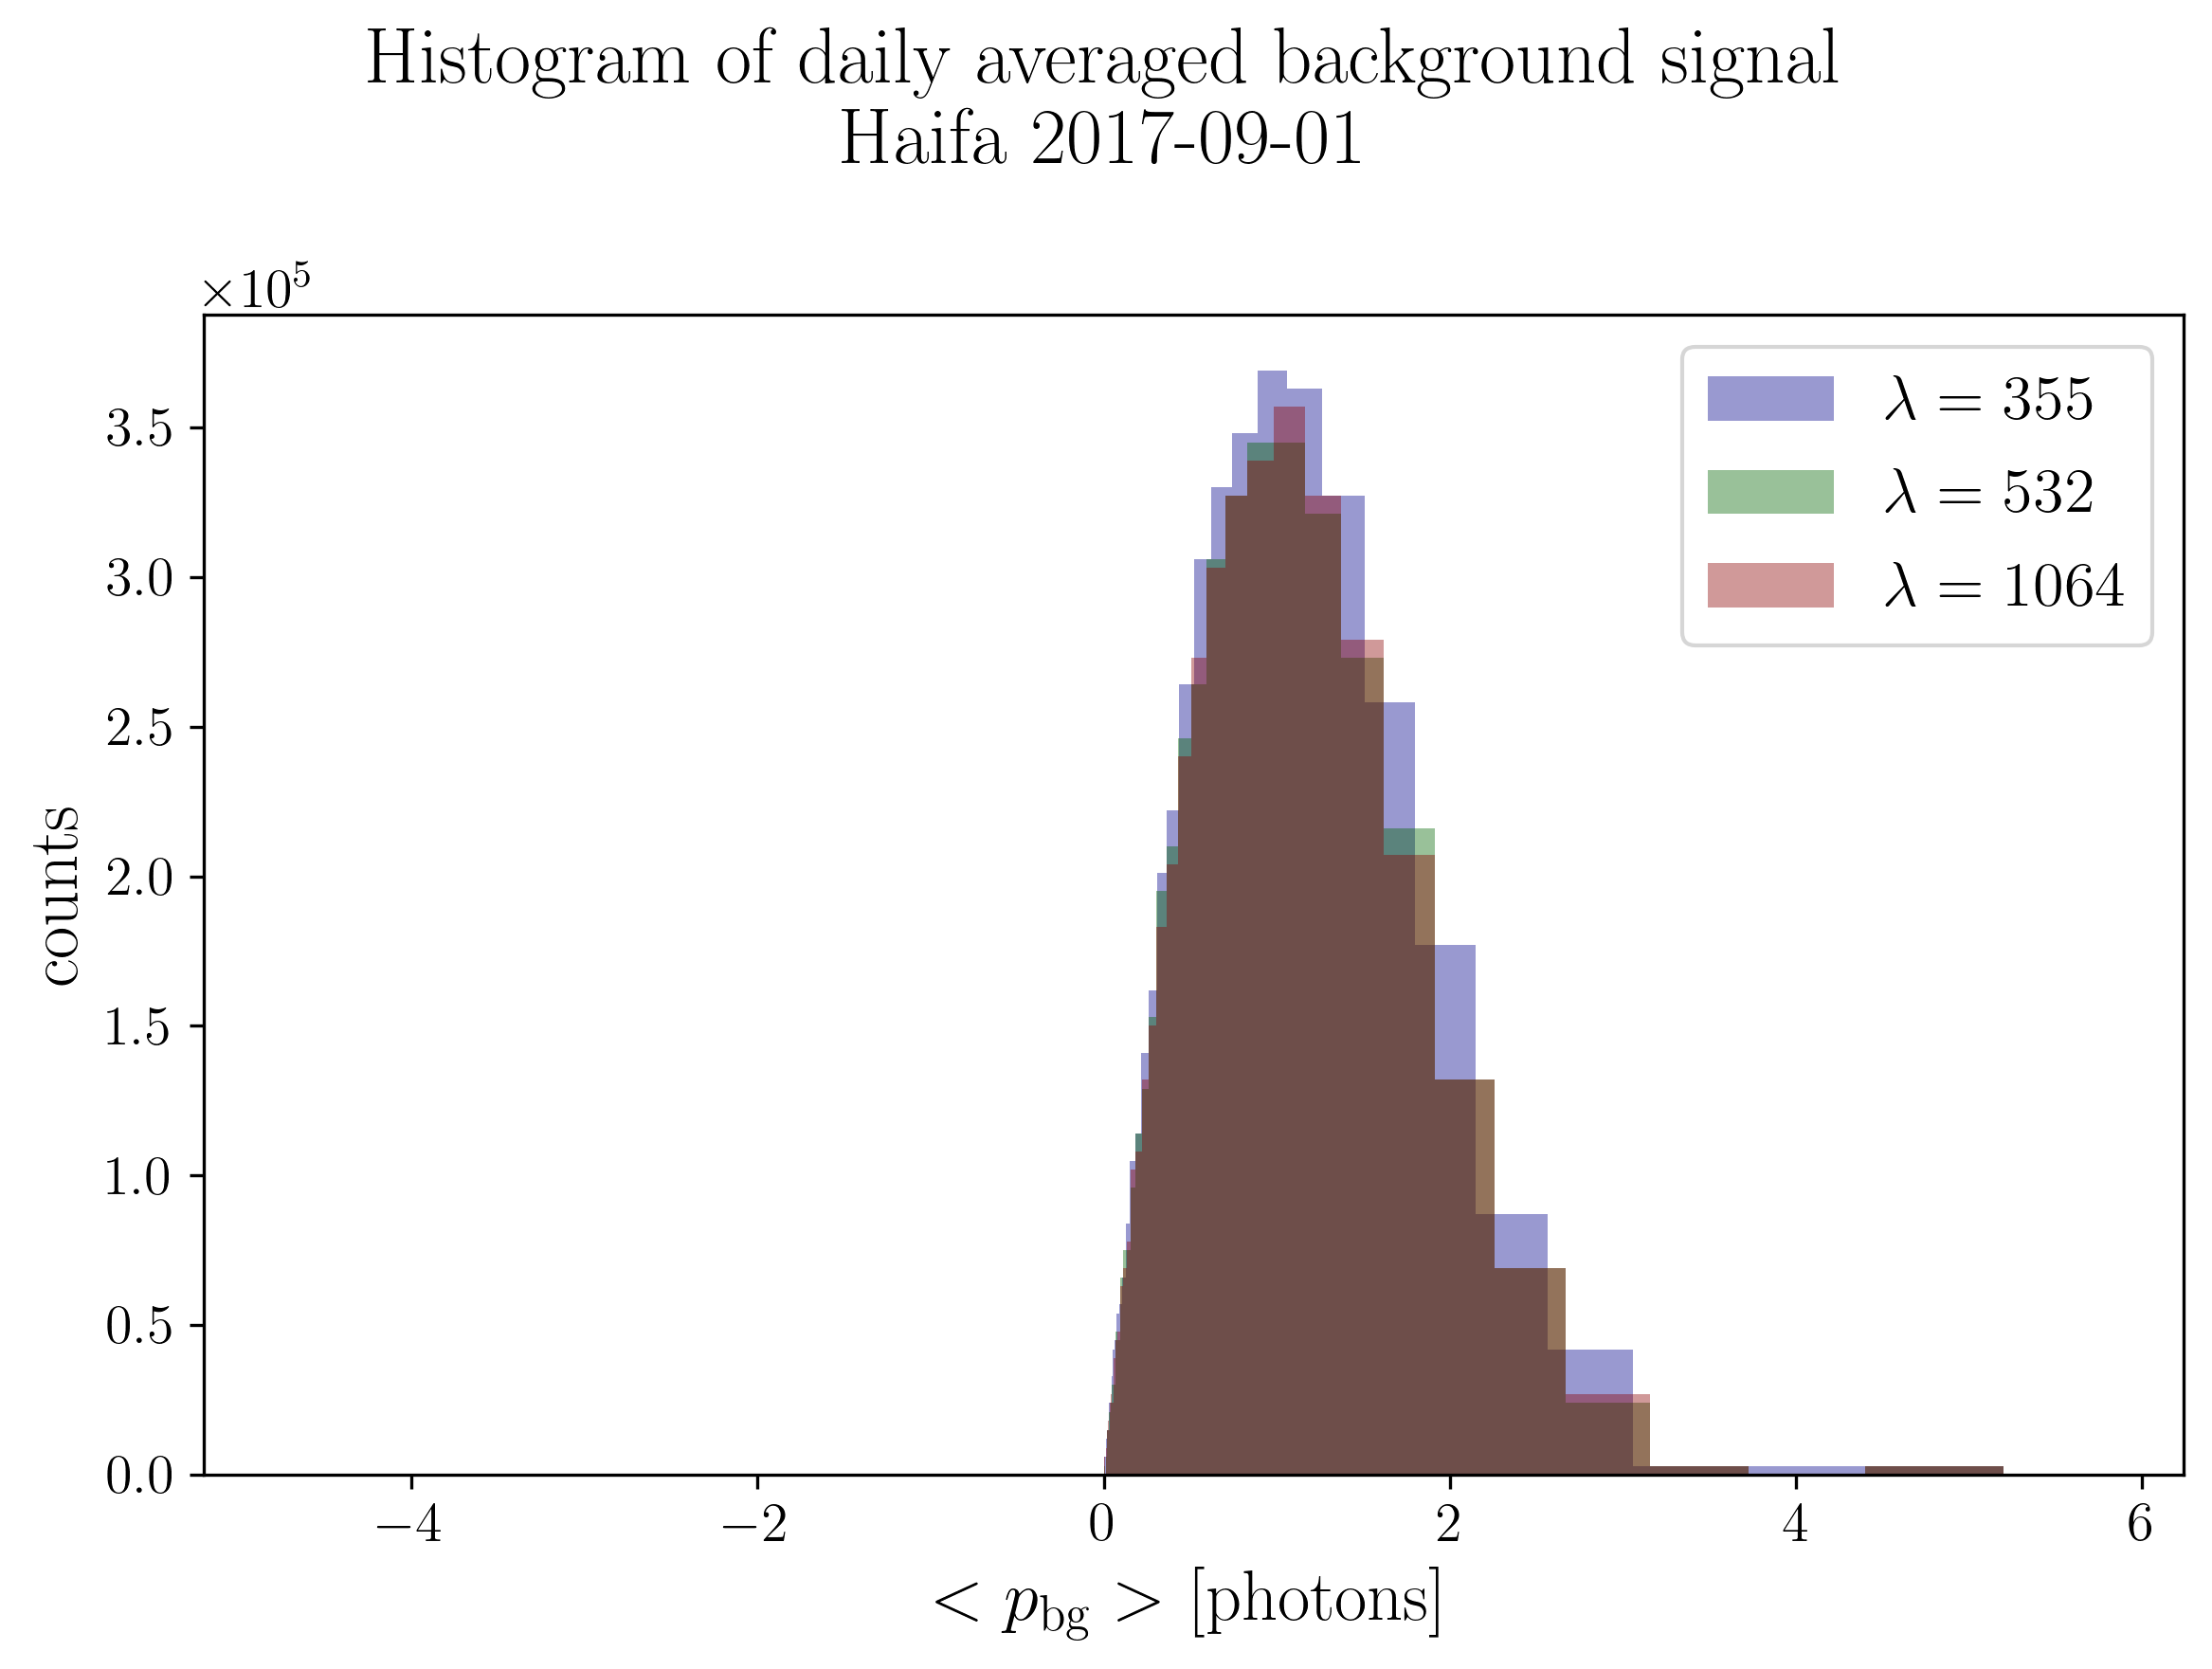

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,50.451389,49.548611,0.0,-0.1660014630262857,1.490575747247175
1,532,100.0,49.861111,50.138889,0.0,-0.15141898926959863,1.4302902077869535
2,1064,100.0,49.756944,50.243056,0.0,-0.21461579965305574,1.566270449878295


In [41]:
pt = QuantileTransformer(output_distribution='normal')
bg_quant_data = pt.fit_transform(bg_ds.bg.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
bg_ds = bg_ds.assign(bg_quant = (bg_ds.bg.sizes, bg_quant_data))
bg_ds.bg_quant.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_quant',nbins=50)
bg_stats





## BG Maunal Power

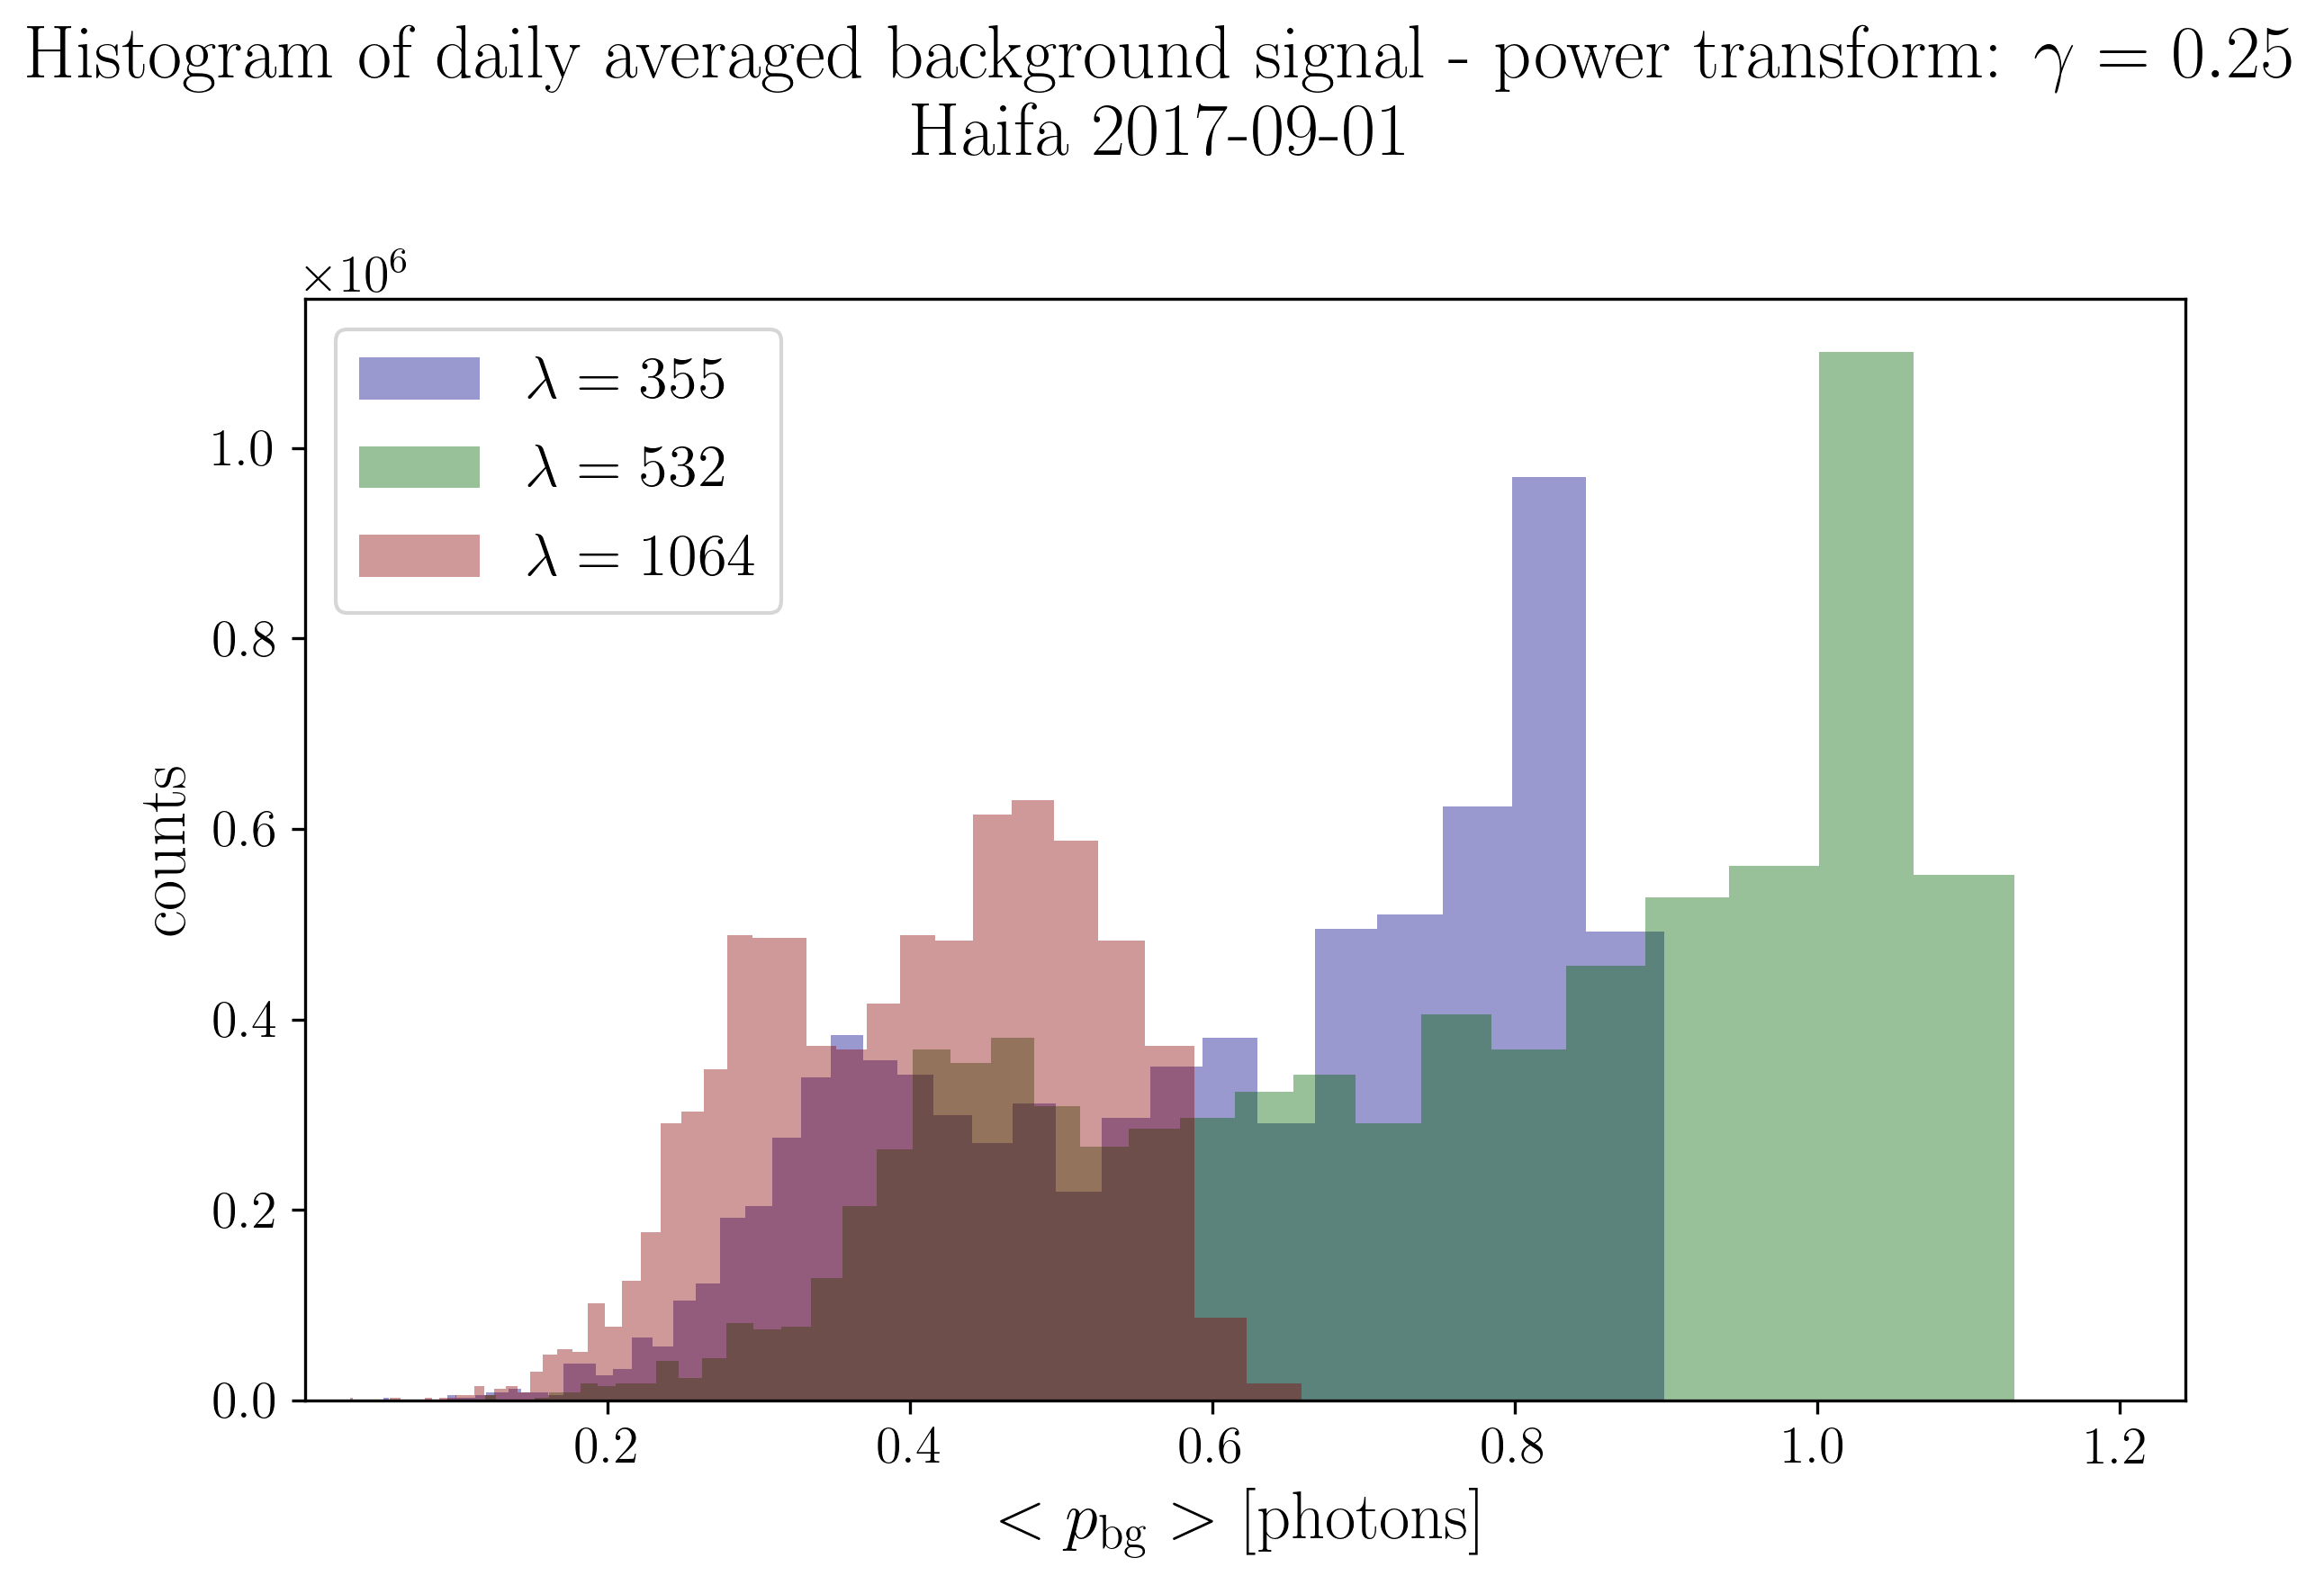

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,100.0,0.0,0.0,0.5291670809006043,0.23656139367604123
1,532,100.0,100.0,0.0,0.0,0.6793816230111592,0.29248471316607605
2,1064,100.0,100.0,0.0,0.0,0.3560796012658256,0.1443688584923548


In [16]:
gamma_bg = 0.25
bg_pow = xr.apply_ufunc(lambda x: x**gamma_bg, bg_ds.bg ,keep_attrs=True)
# %%
bg_pow = bg_pow.assign_attrs({'info':bg_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_bg}$'})
bg_ds = bg_ds.assign(bgpow= bg_pow)

# %%
_,_,bg_pow_stats= daily_ds_histogram(bg_ds, profile_type='bgpow',nbins=150)
bg_pow_stats





# 3. Clean Lidar Signal

In [7]:
signal_folder = prep.get_month_folder_name(station.gen_signal_dataset,dt_day)
signal_nc_name = os.path.join(signal_folder,
                             gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='signal'))
signal_ds = prep.load_dataset(signal_nc_name)


## BG R2

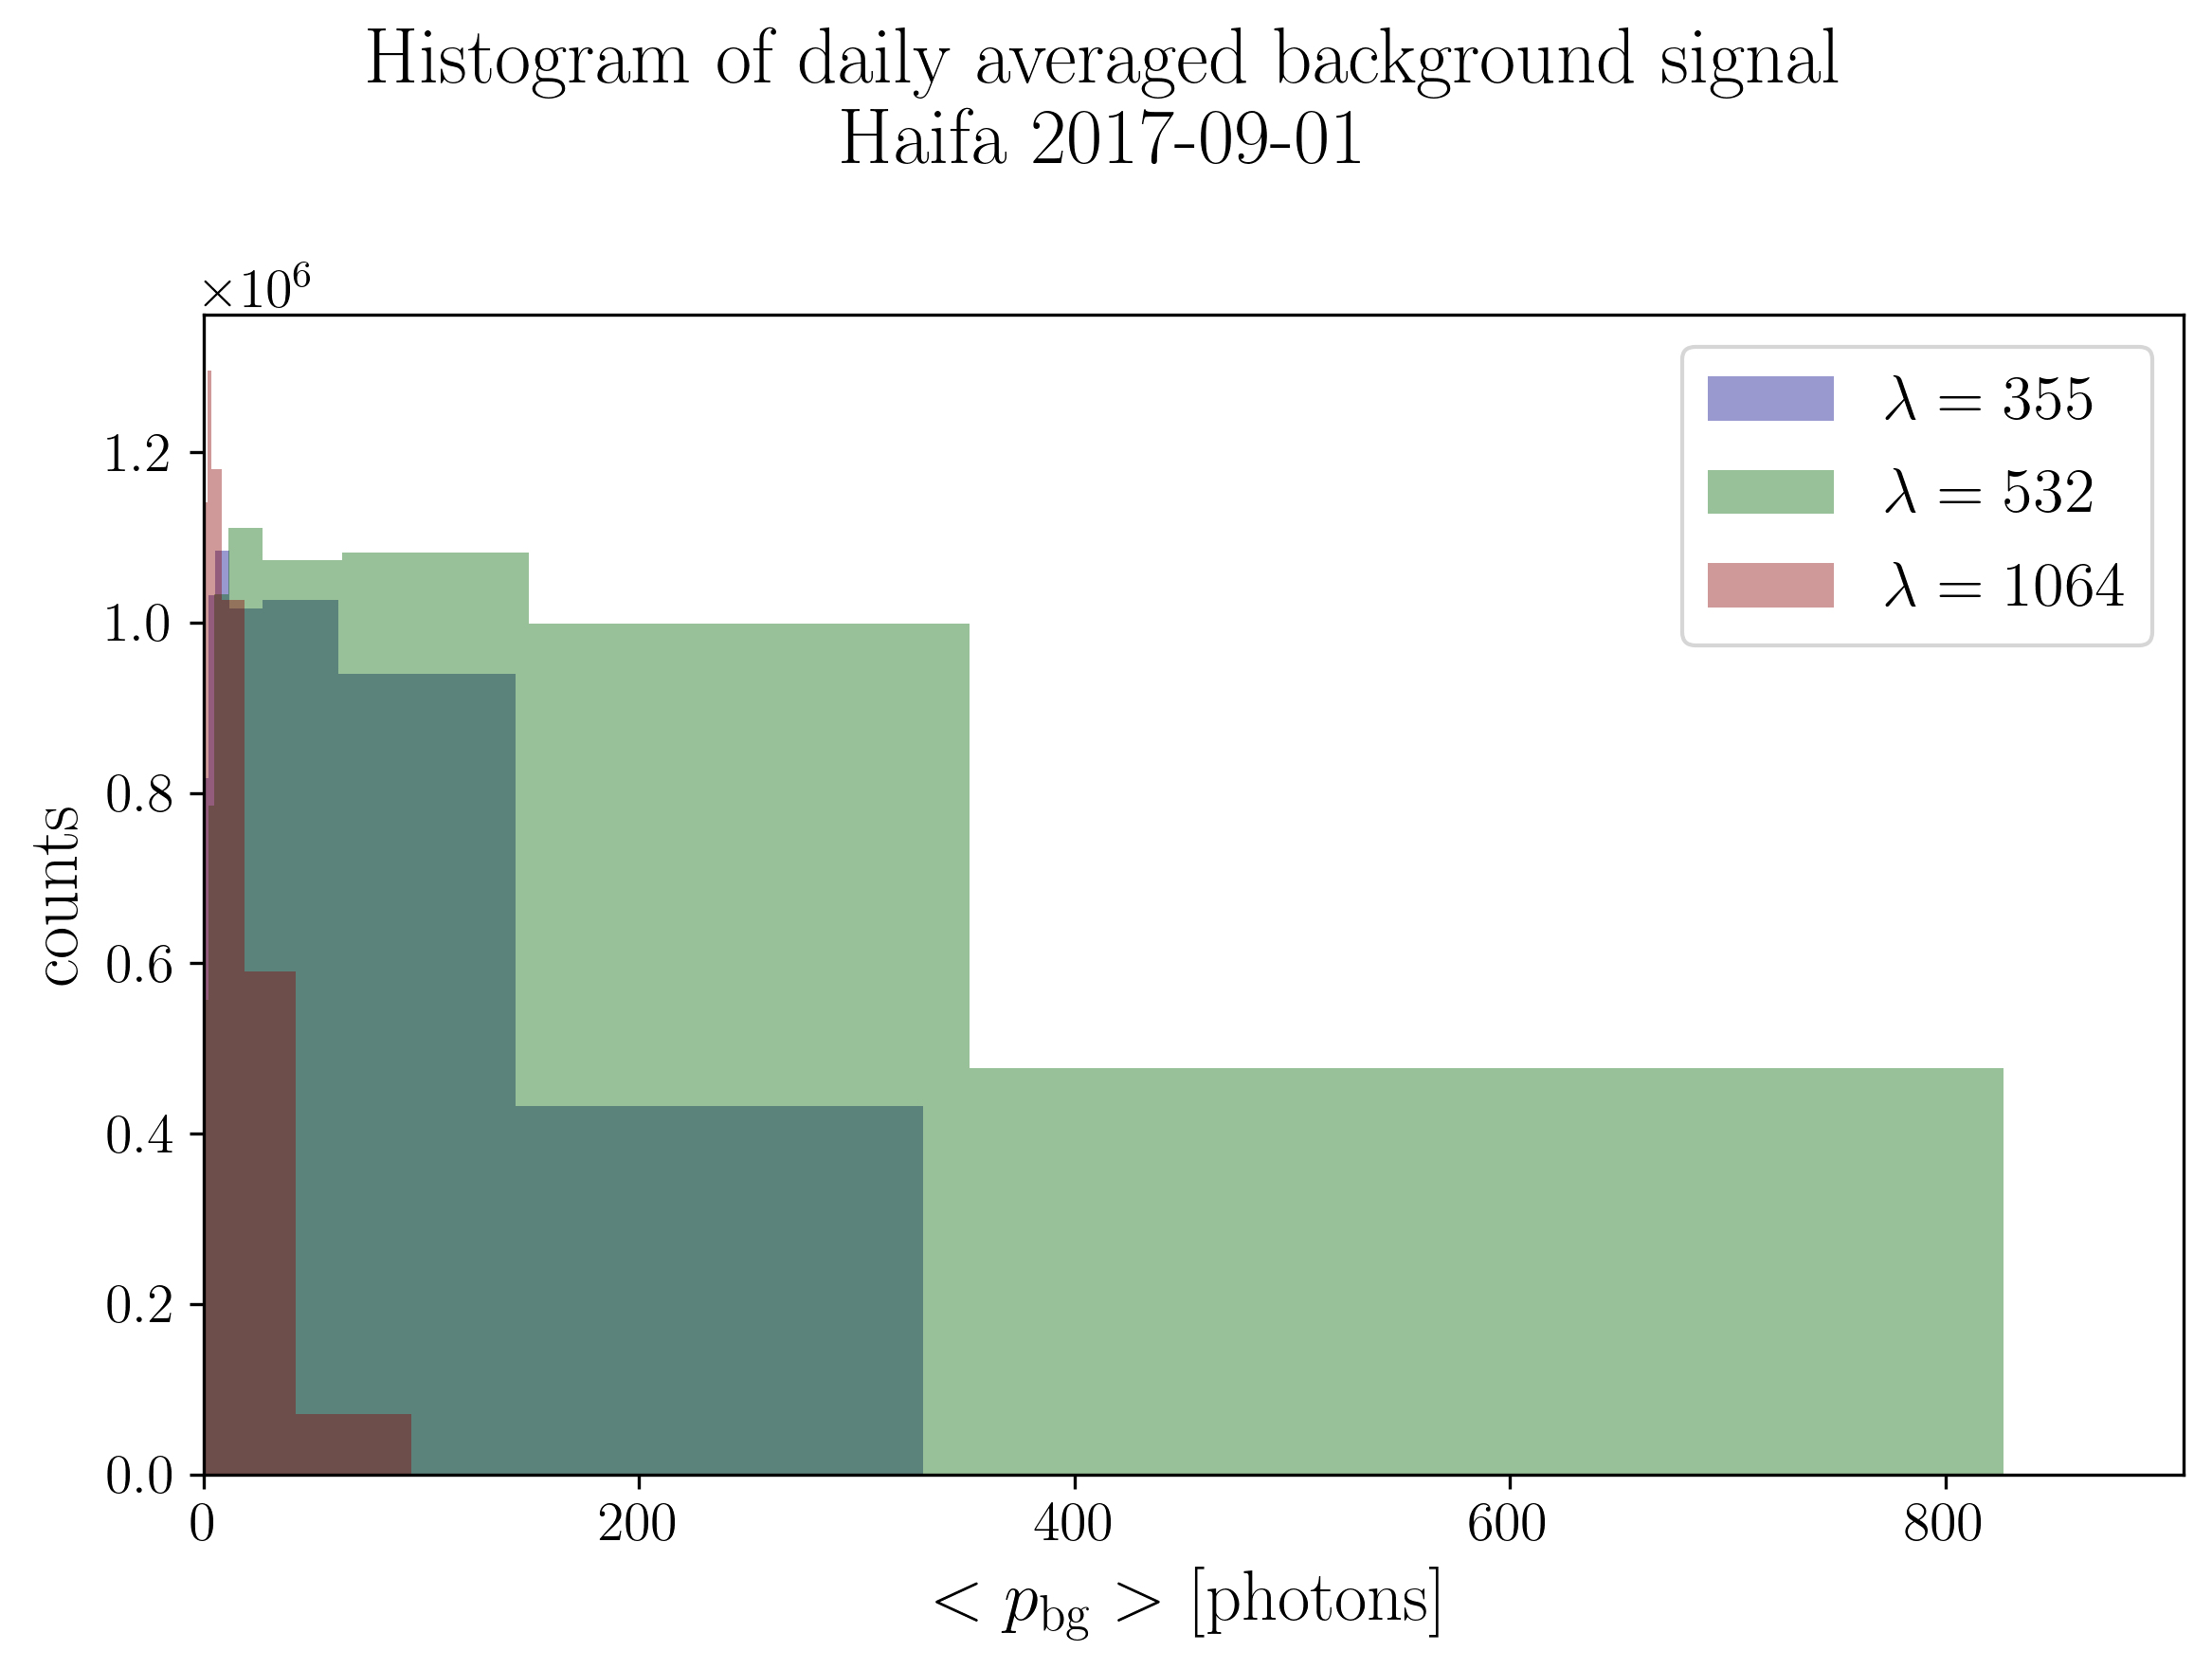

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,99.774676,0.0,0.225324,28.656840054753534,48.76707559758152
1,532,100.0,99.803380,0.0,0.196620,74.46292078888918,123.95160380764959
2,1064,100.0,99.731620,0.0,0.268380,5.143683112189445,8.539083412377028


In [44]:
bg_r2 =  bg_ds.bg*signal_ds.r2
bg_ds = bg_ds.assign(bg_r2 = (bg_ds.bg.sizes, bg_r2))
bg_ds.bg_r2.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_r2',nbins=50)
bg_stats

## BG R2 Power

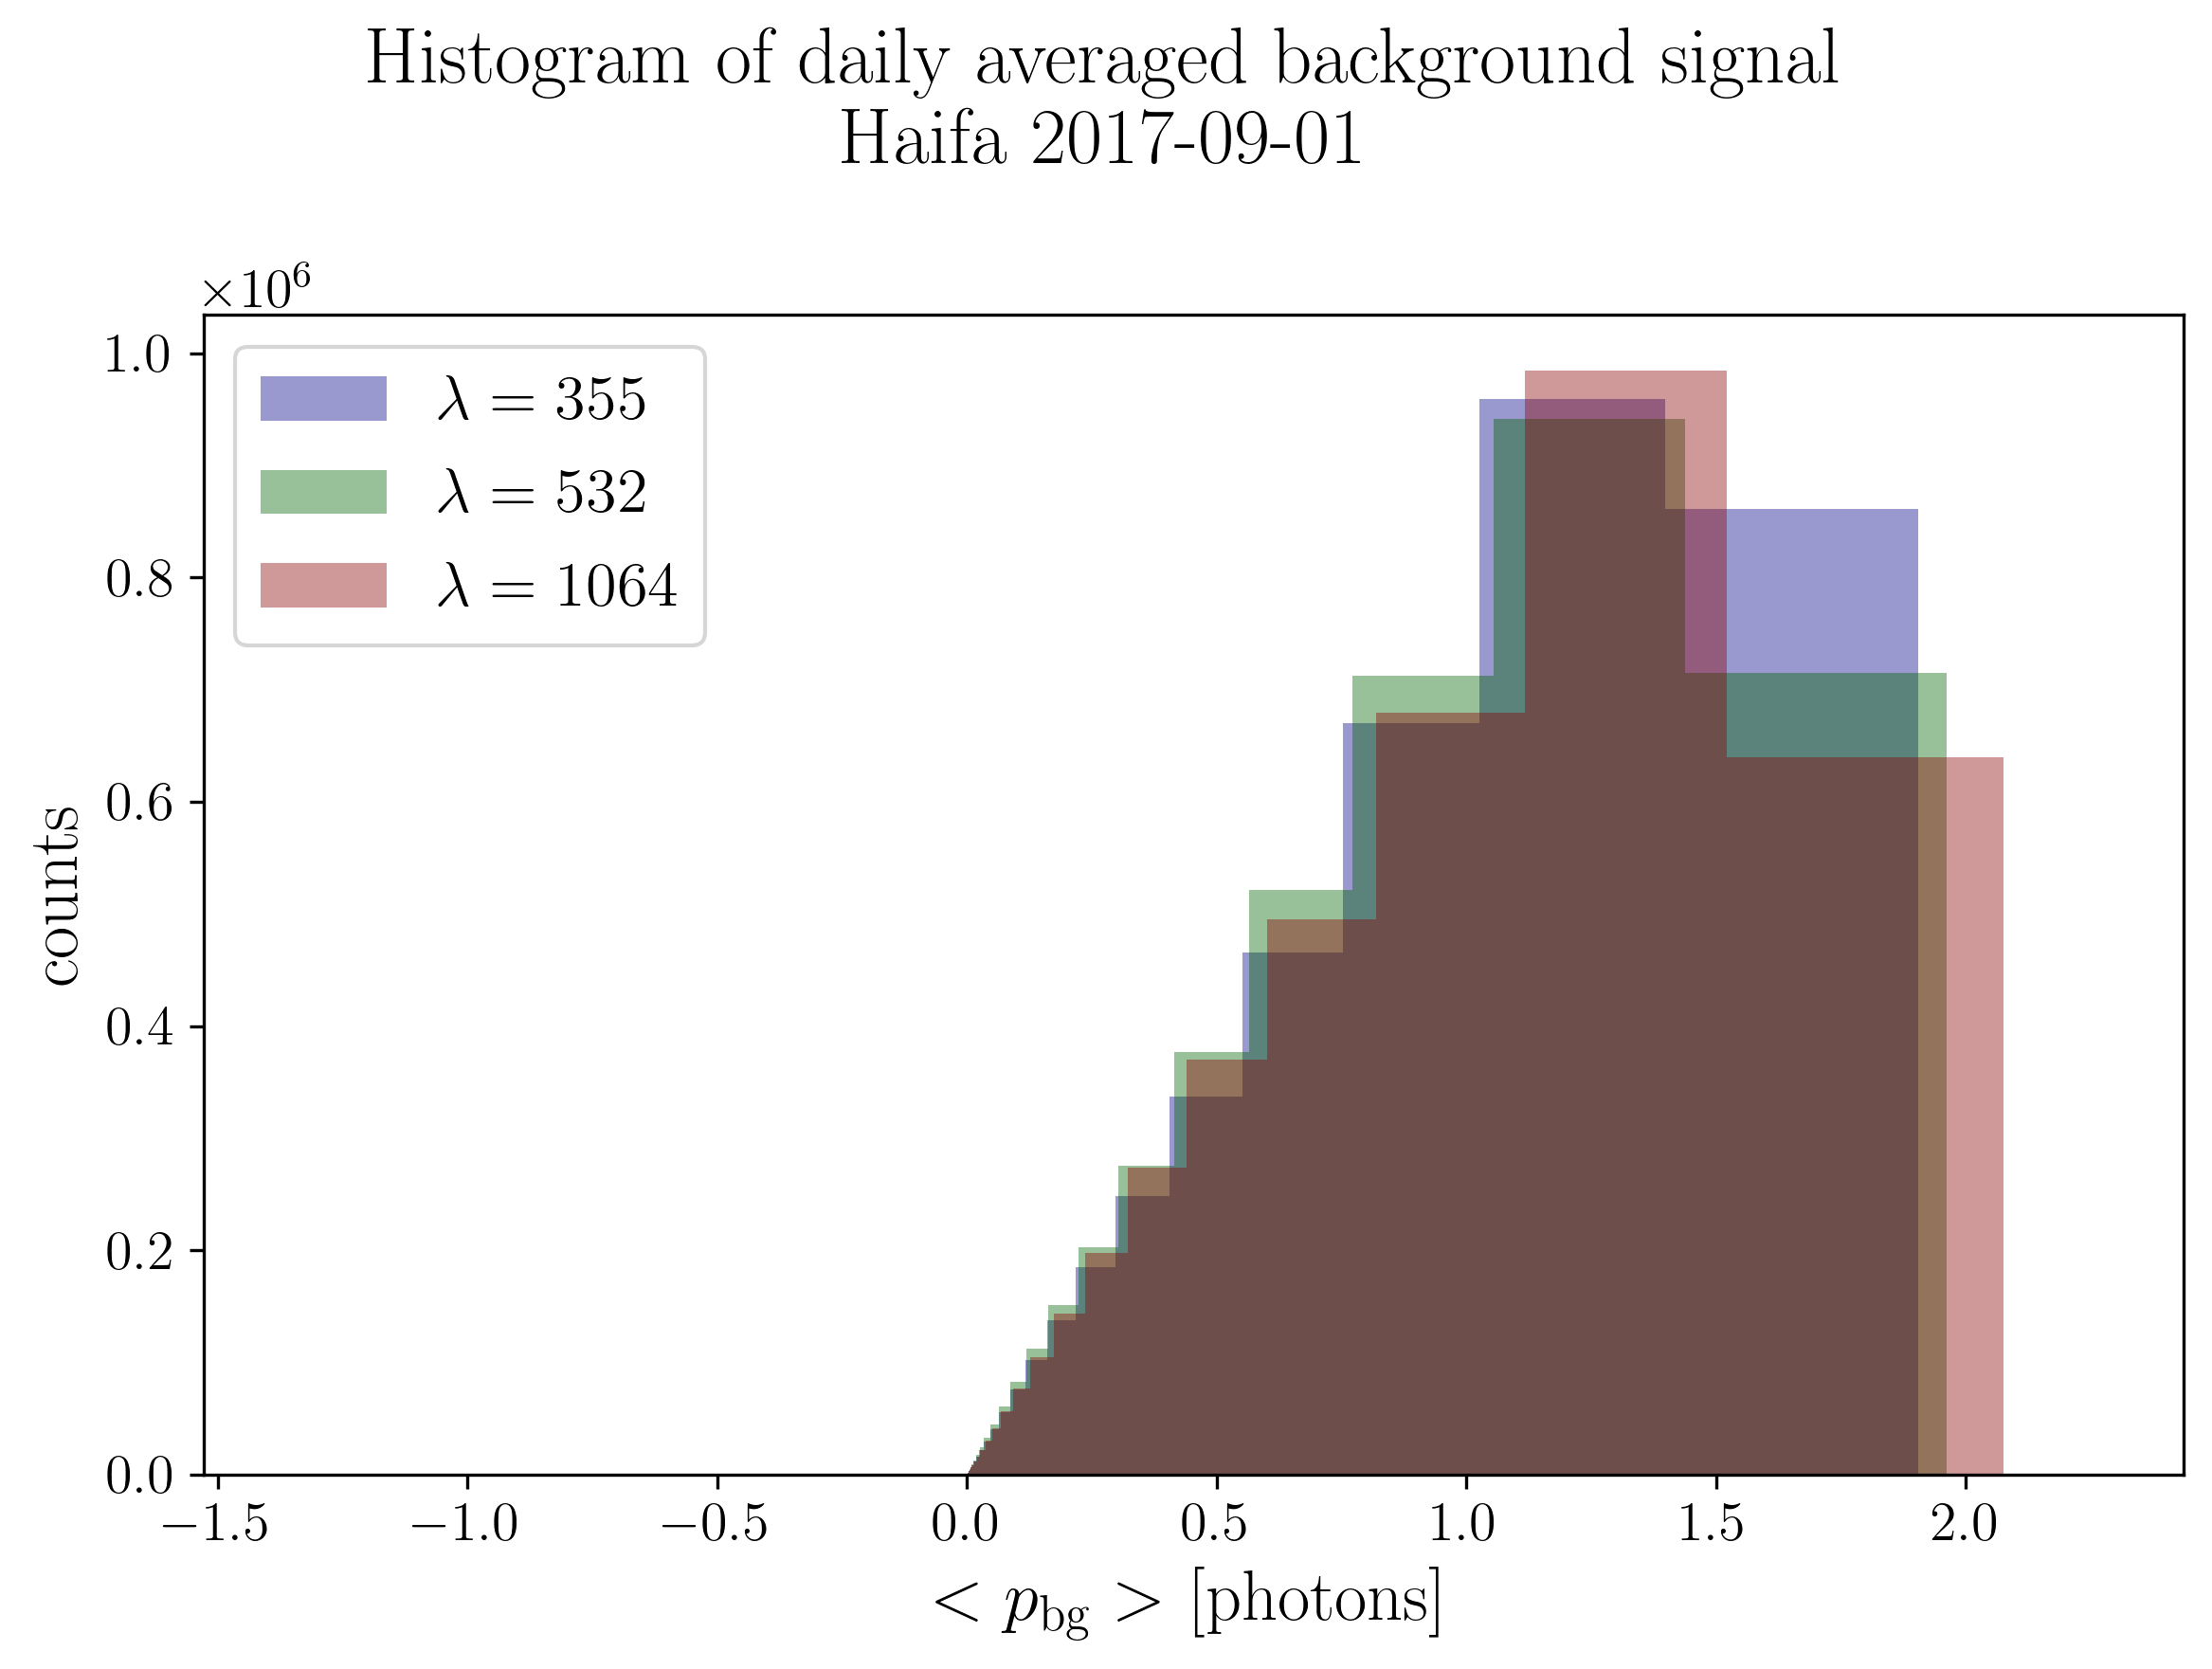

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,49.240602,50.759398,0.0,4.2190448665577505e-16,1.0000000000000002
1,532,100.0,50.023750,49.976250,0.0,6.846474005012876e-16,1.0000000000000007
2,1064,100.0,48.390231,51.609769,0.0,5.115907697472721e-17,0.9999999999999999


In [34]:
pt = PowerTransformer()
bg_r2_pow_data = pt.fit_transform(bg_r2.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
bg_ds = bg_ds.assign(bg_r2_pow = (bg_ds.bg.sizes, bg_r2_pow_data))
bg_ds.bg_r2_pow.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_r2_pow',nbins=50)
bg_stats

## BG R2 Quantile

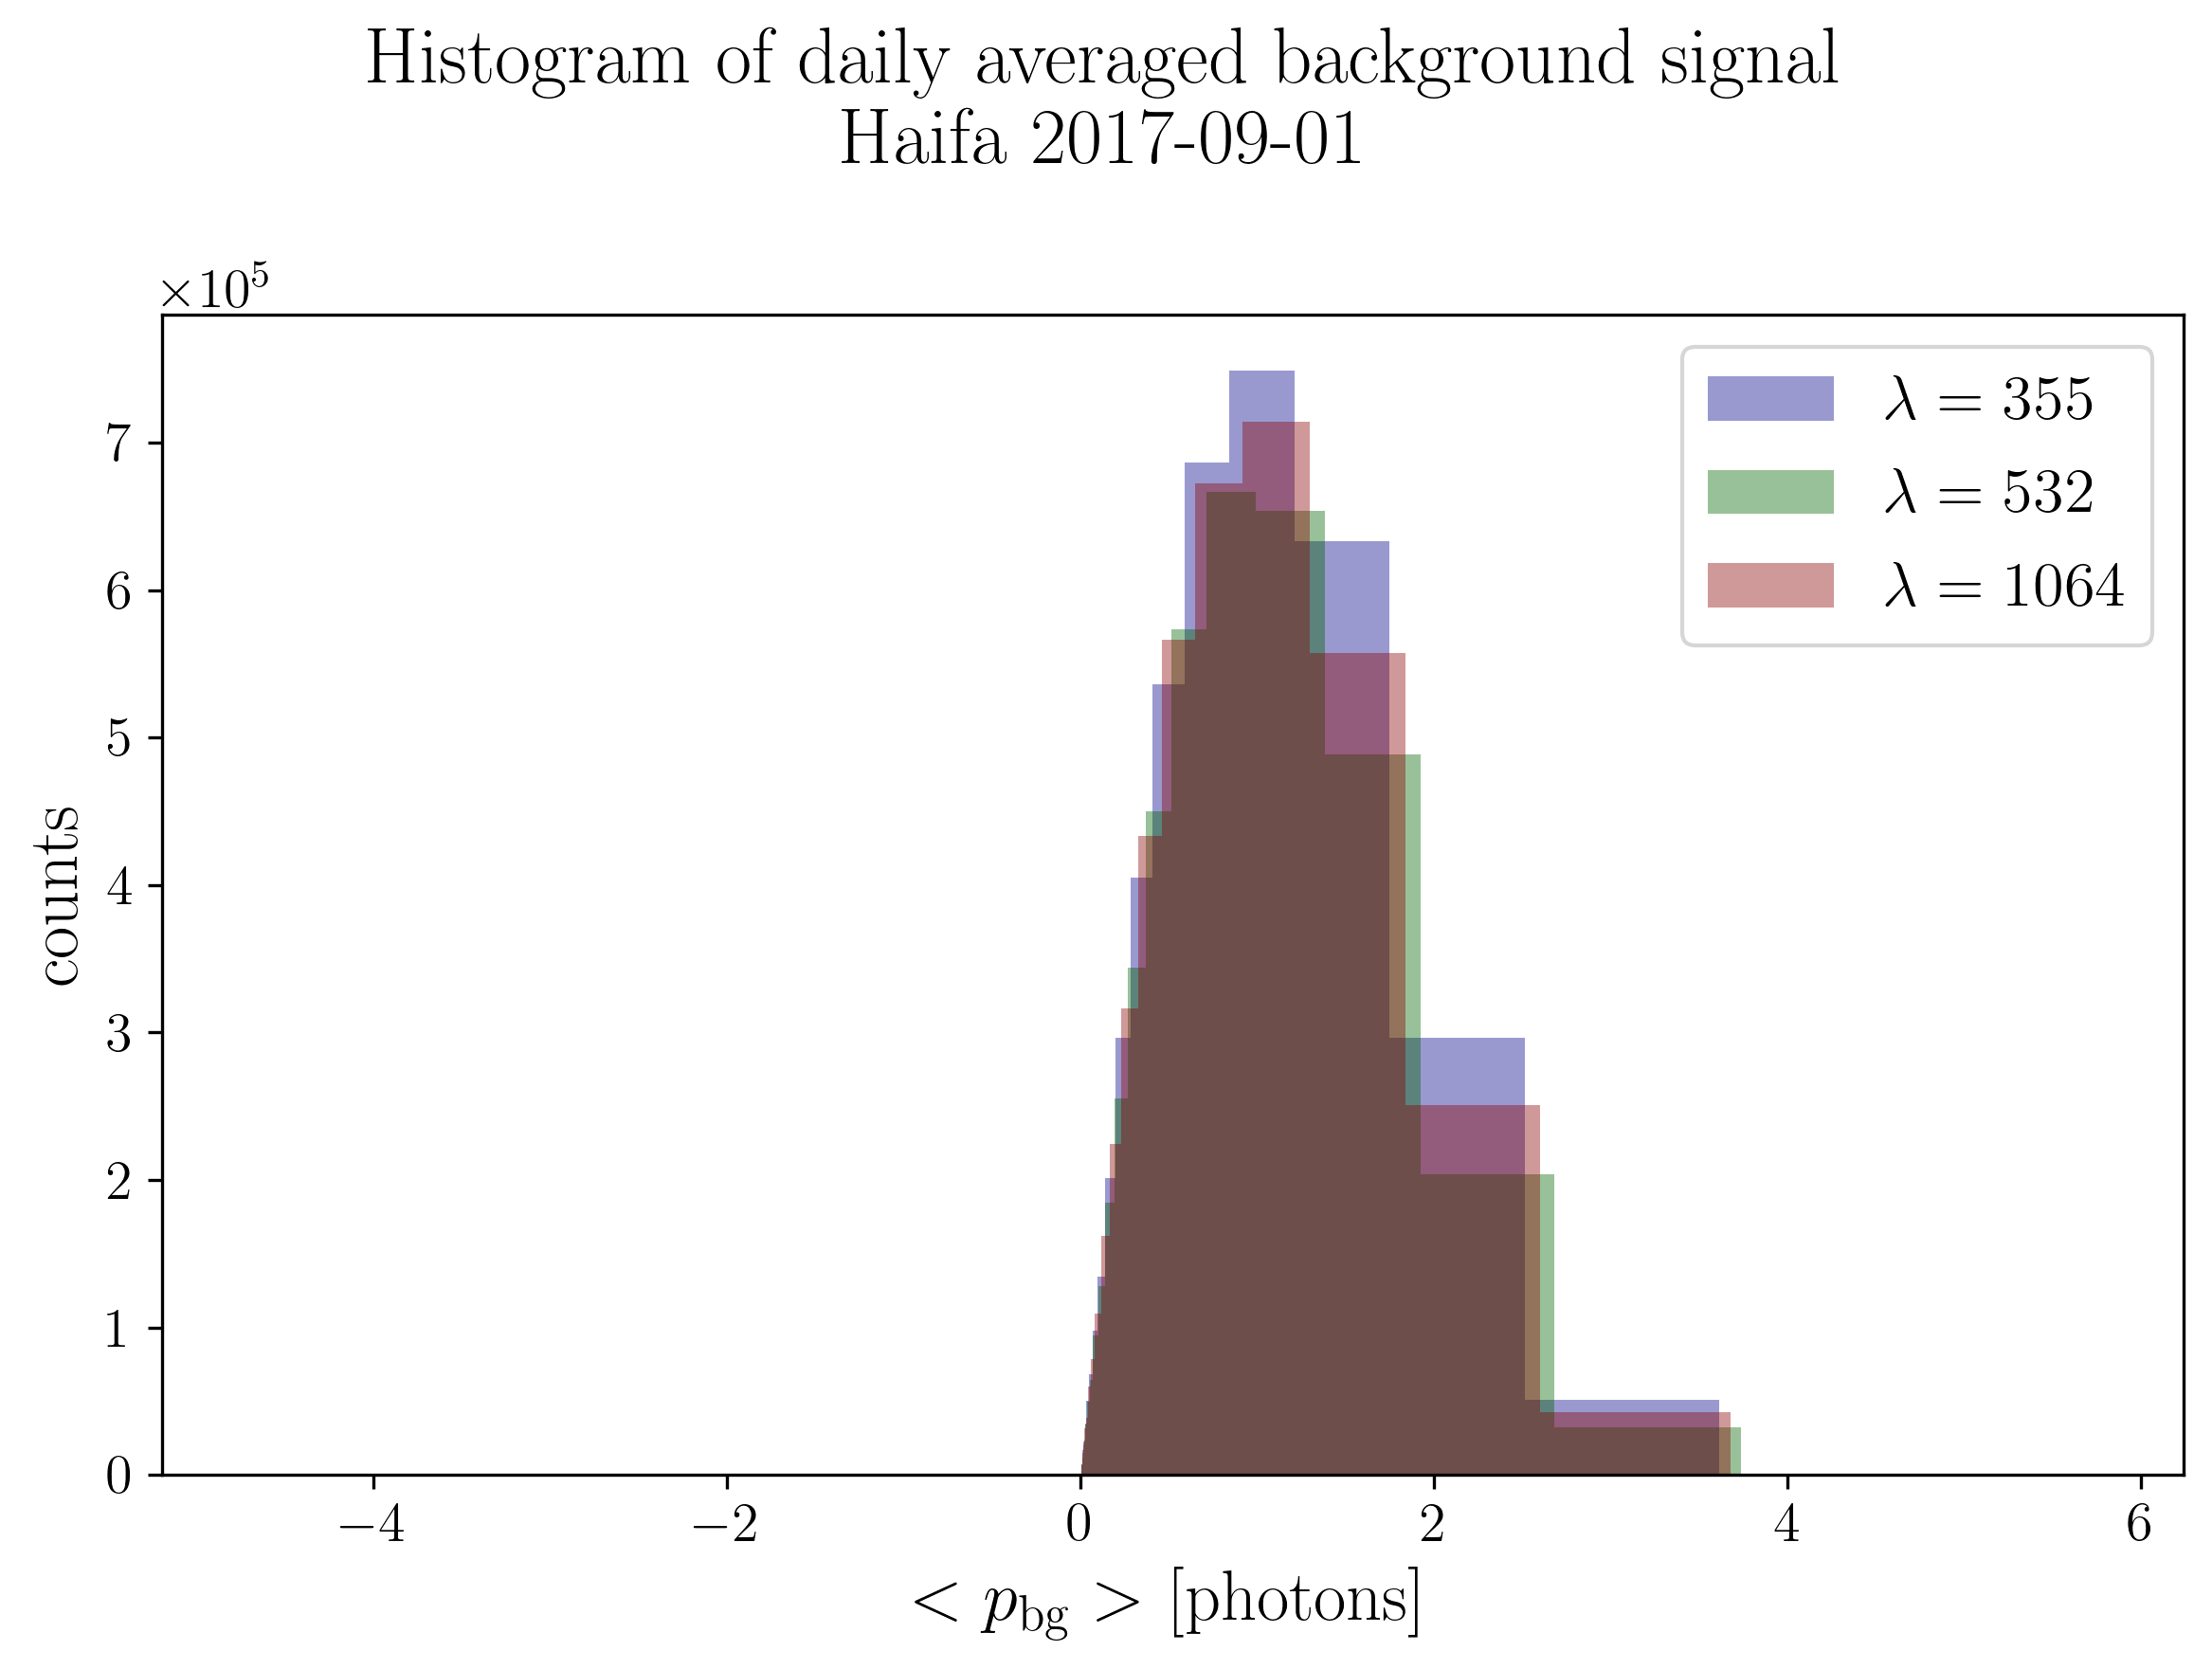

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,49.955301,50.044699,0.0,-0.1735999005618542,1.4877917873410869
1,532,100.0,49.893808,50.106192,0.0,-0.14962813003534775,1.4311760889468002
2,1064,100.0,50.099525,49.900475,0.0,-0.20751407371068448,1.5678731169001194


In [40]:
pt = QuantileTransformer(output_distribution='normal')
bg_r2_quant_data = pt.fit_transform(bg_r2.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
bg_ds = bg_ds.assign(bg_r2_quant = (bg_ds.bg.sizes, bg_r2_quant_data))
bg_ds.bg_r2_quant.attrs.update(bg_ds.bg.attrs)
_,_,bg_stats= daily_ds_histogram(bg_ds, profile_type='bg_r2_quant',nbins=50)
bg_stats





# 4. Lidar measurement
## TODO: test transformers on lidar_ds.p



In [11]:
lidar_folder = prep.get_month_folder_name(station.gen_lidar_dataset,dt_day)
lidar_nc_name = os.path.join(lidar_folder,gen_utils.get_gen_dataset_file_name(station,dt_day,data_source='lidar'))
lidar_ds = prep.load_dataset(lidar_nc_name)

## Lidar

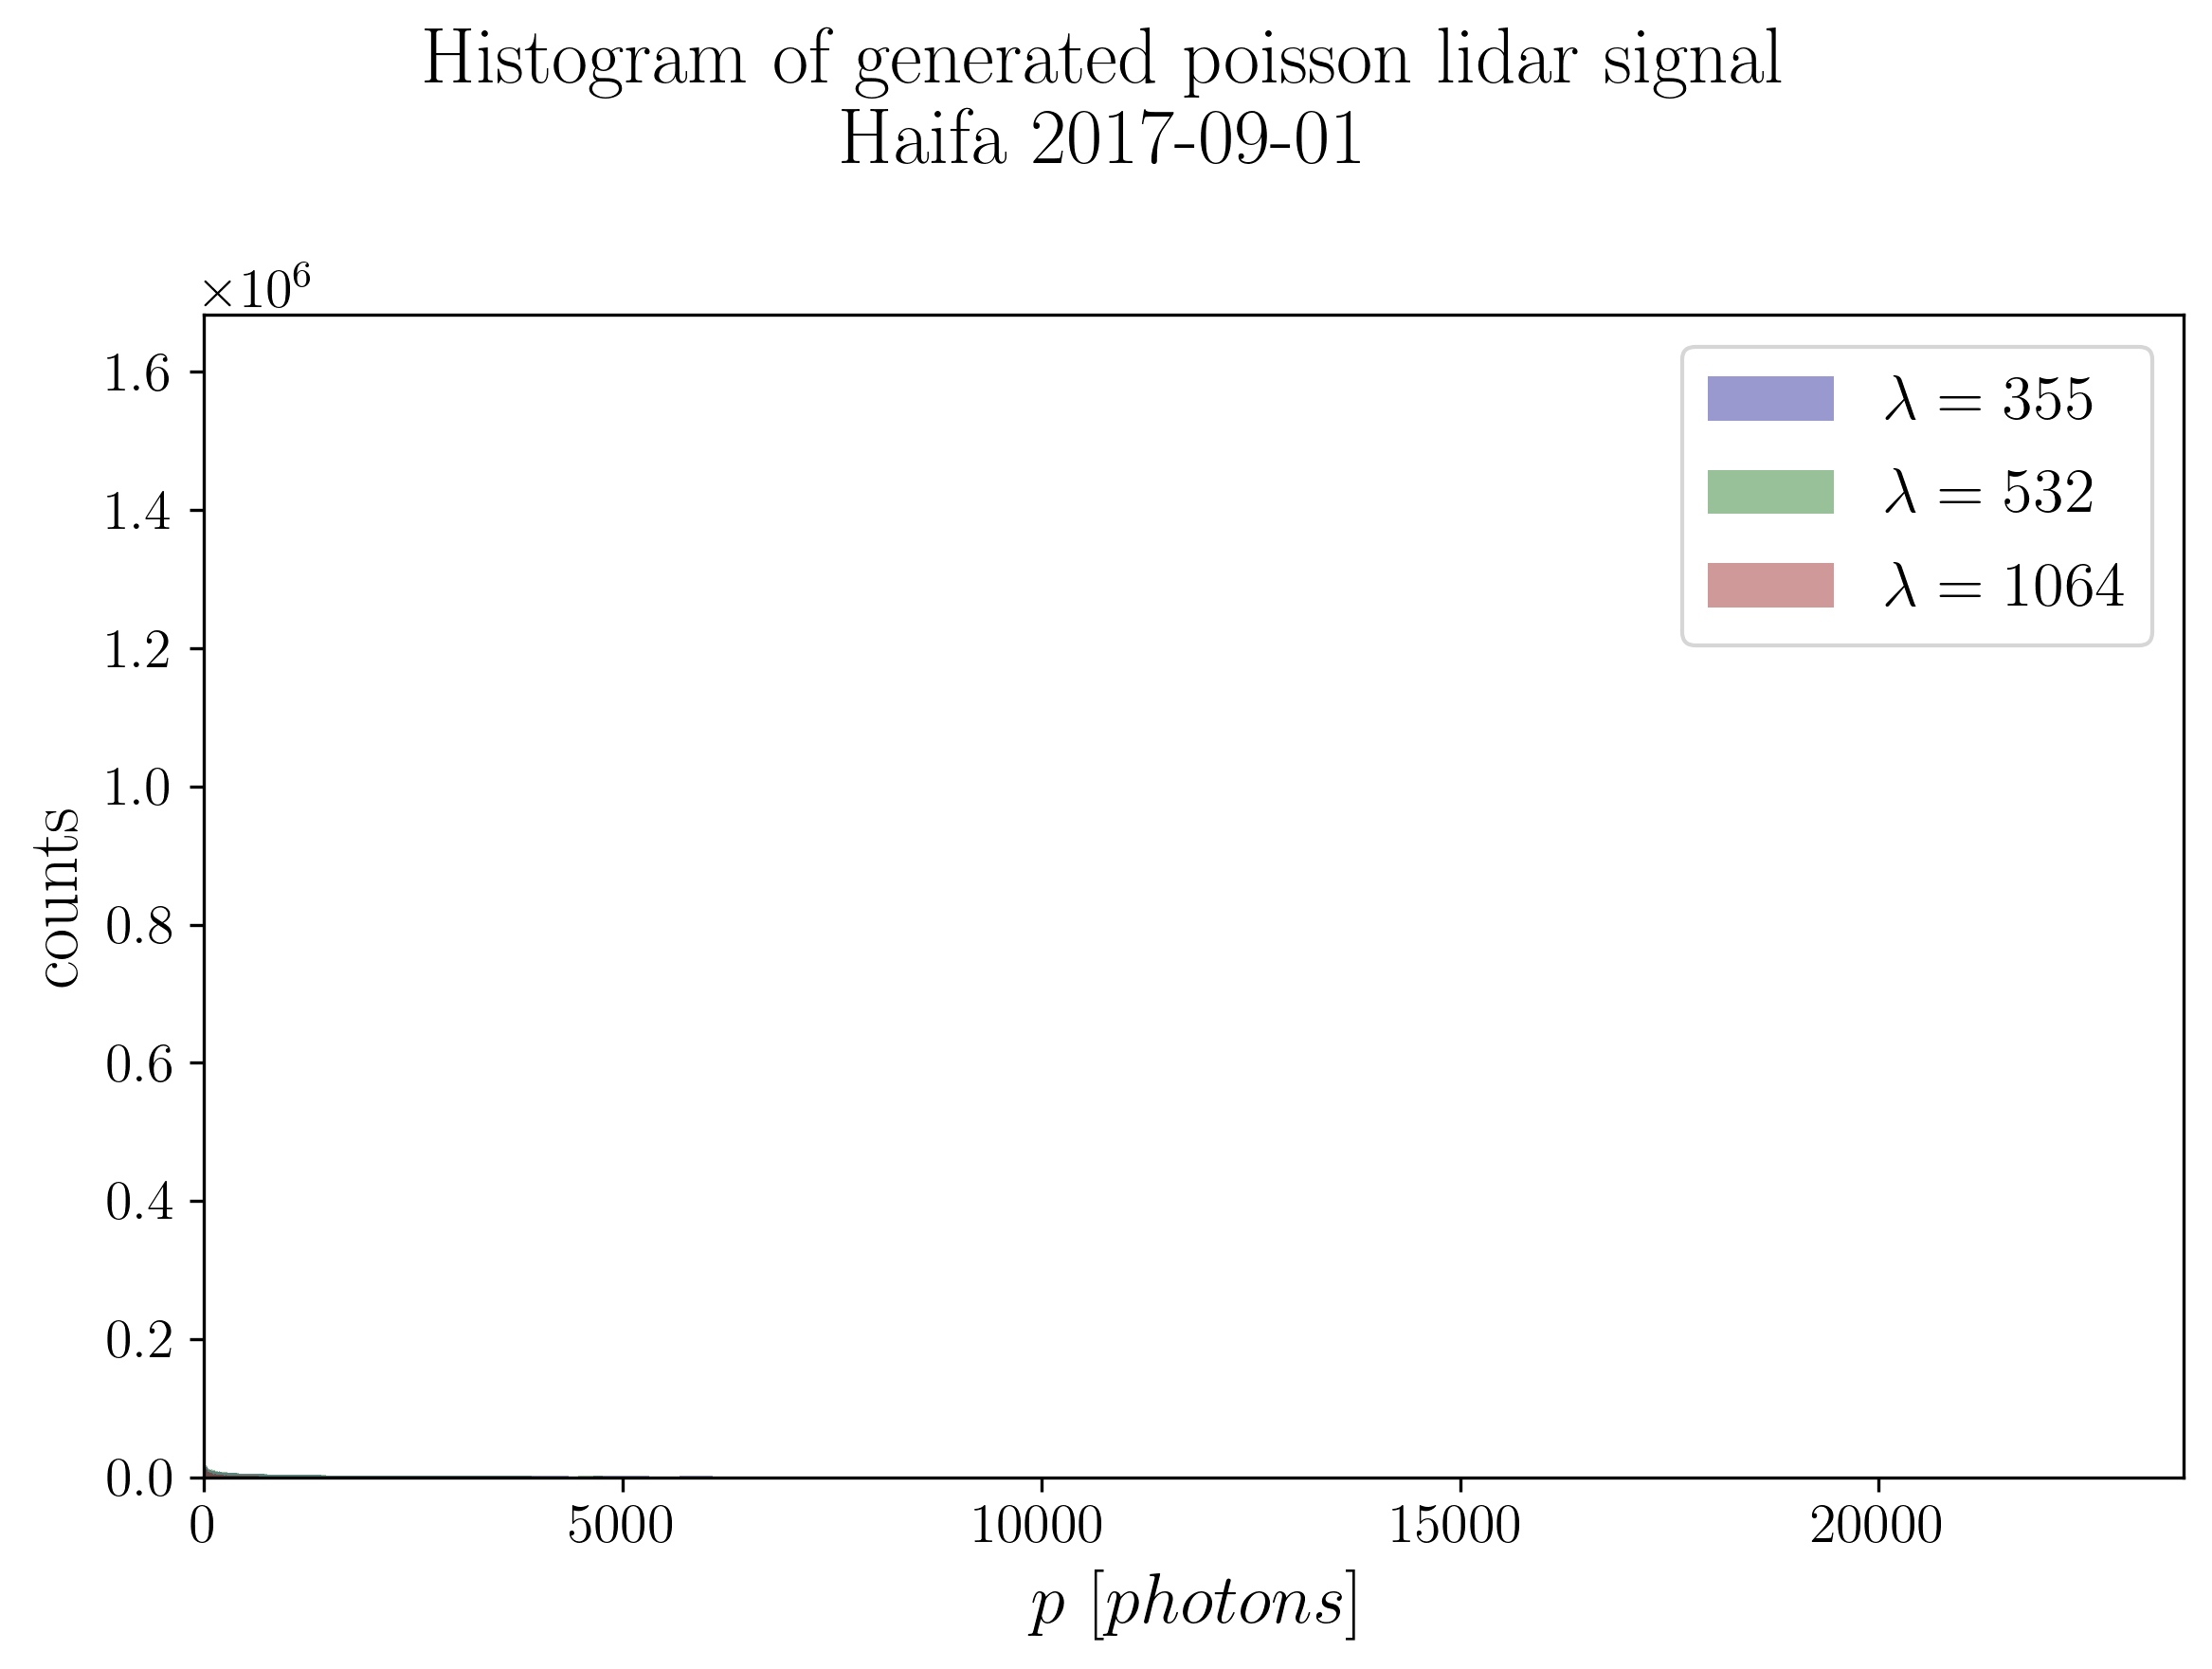

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,0.0,66.458252,64.22871331018519,689.7881071229775
1,532,100.0,48.498935,0.0,51.501065,60.292889351851855,616.5777977144054
2,1064,100.0,23.259421,0.0,76.740579,12.876695949074074,126.76301282158923


In [12]:
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='p',nbins=150)#,log_scale=True)
lidar_stats

## Lidar Power

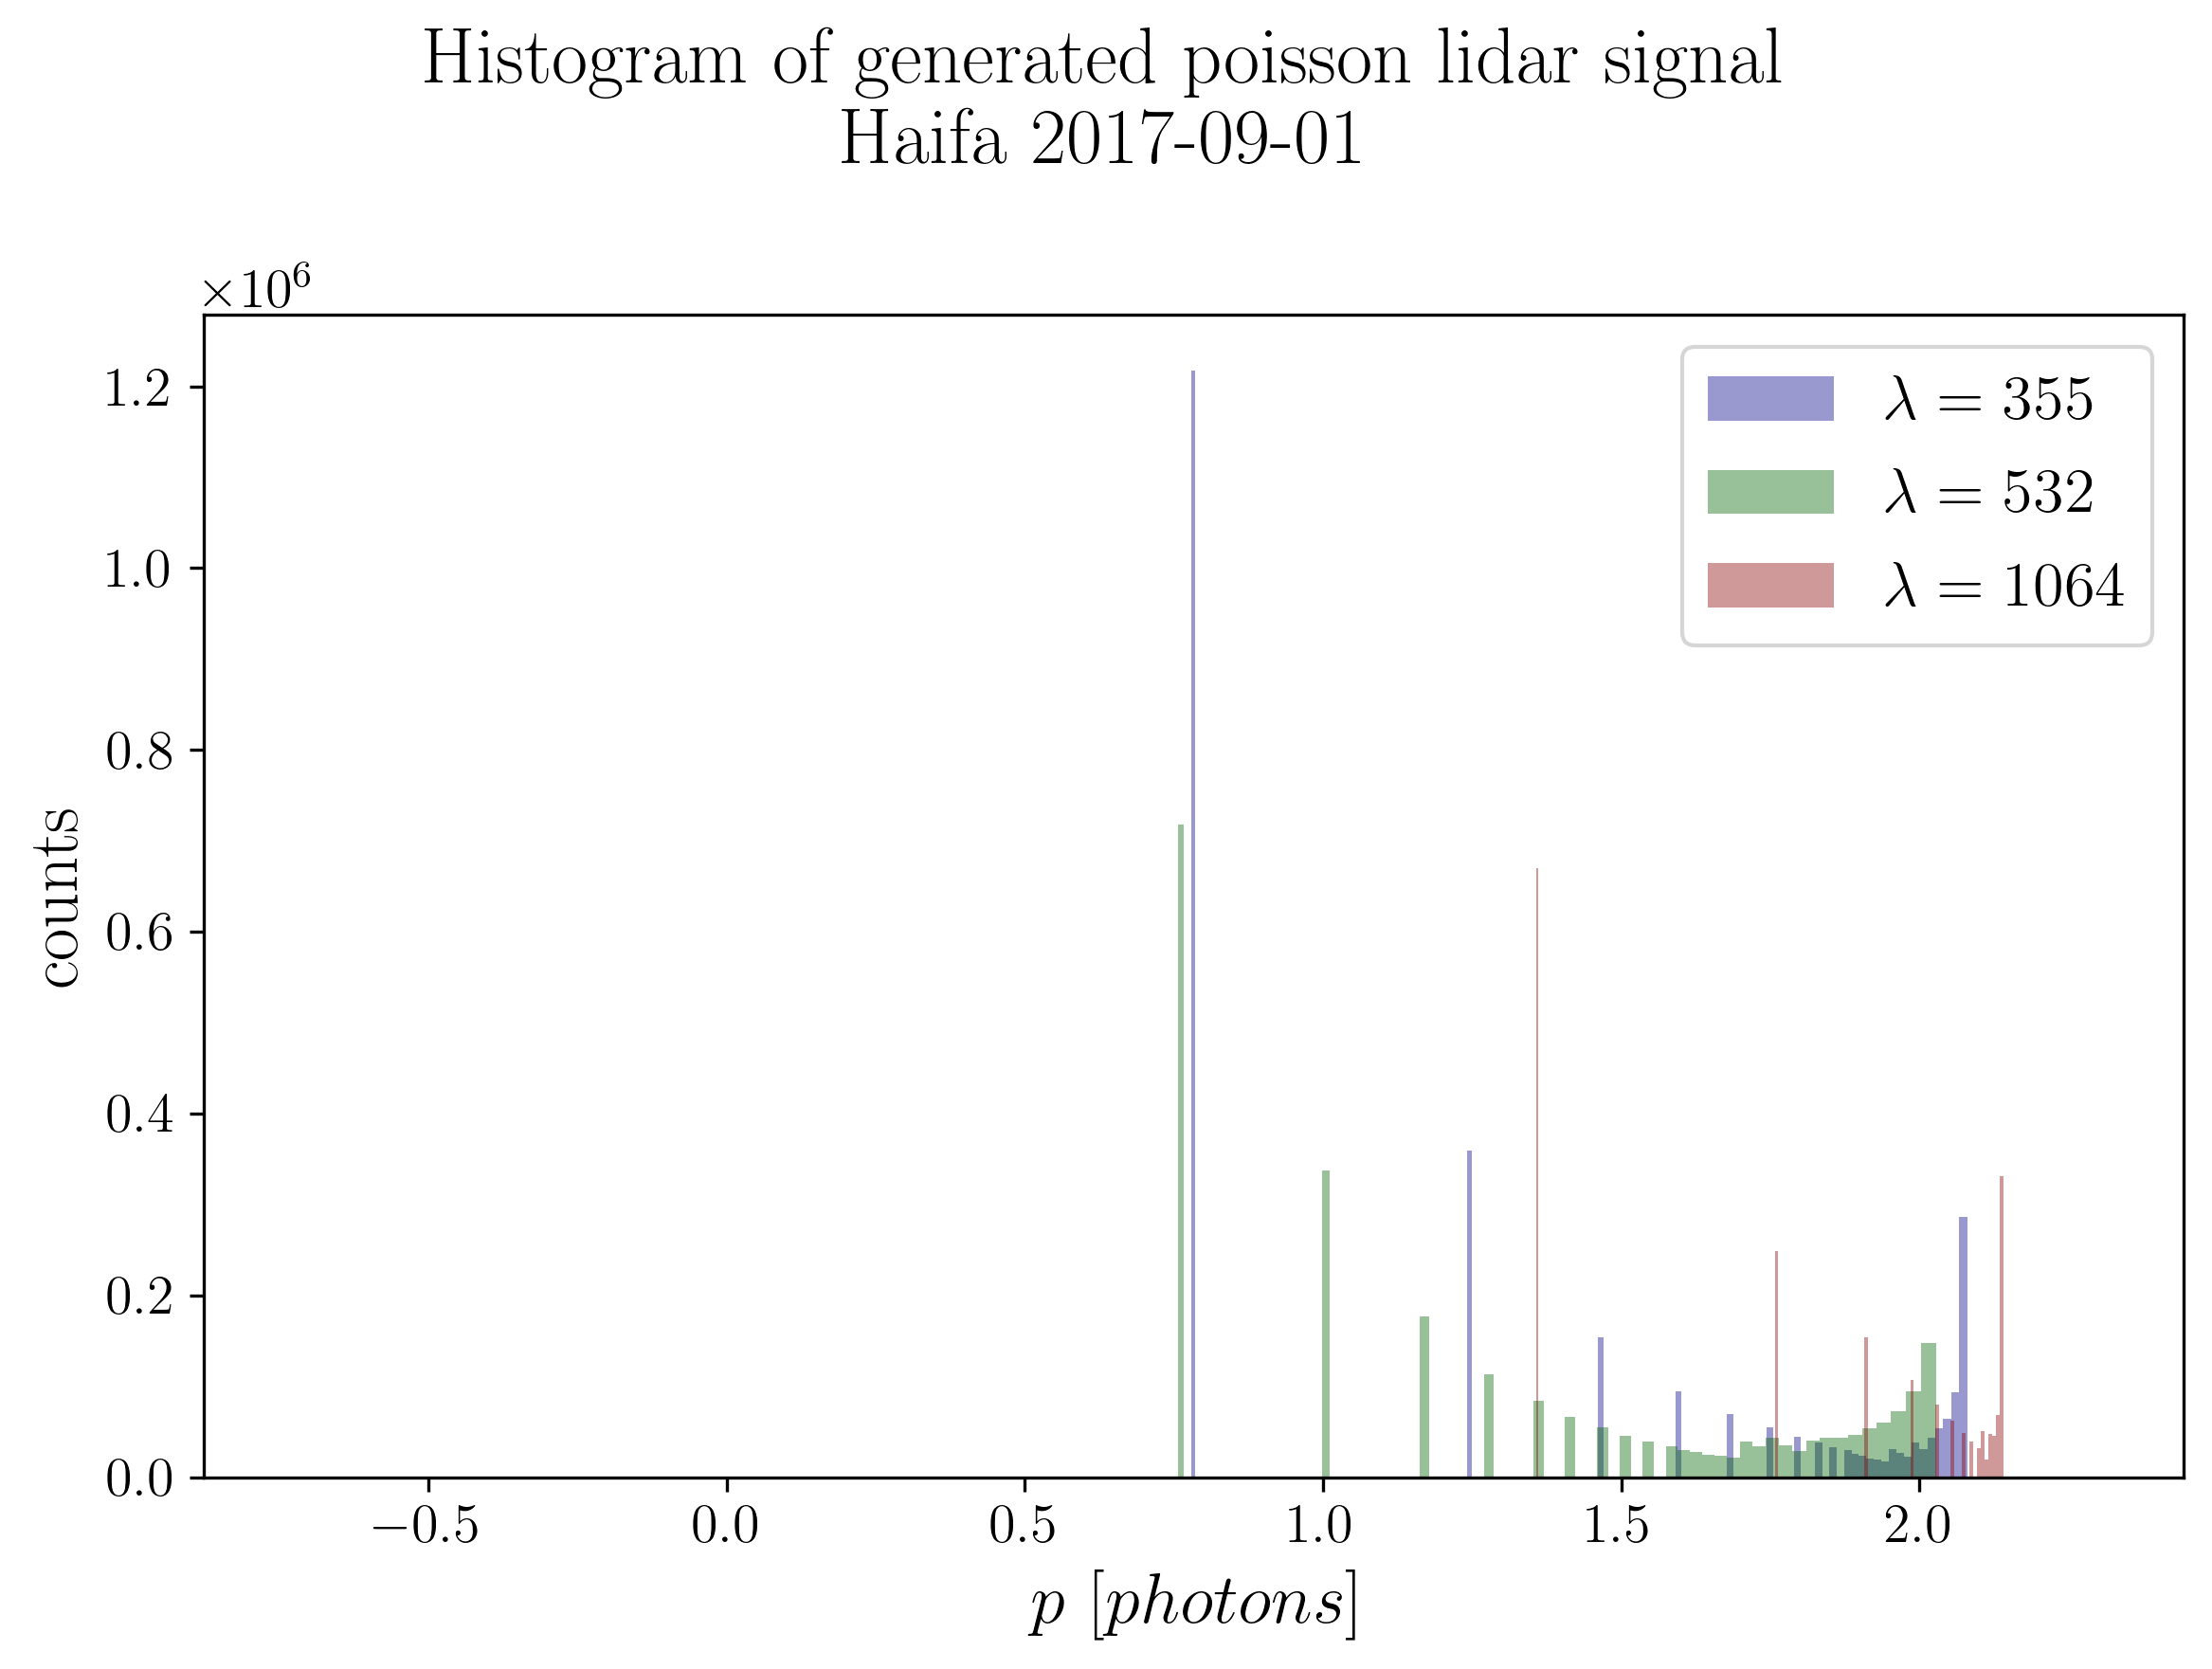

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,66.458252,0.0,1.3032932757697481e-15,1.0
1,532,100.0,48.498935,51.501065,0.0,6.676996404335282e-16,1.0000000000000002
2,1064,100.0,23.259421,76.740579,0.0,3.846404676248009e-16,0.9999999999999988


In [14]:
pt = PowerTransformer()
lidar_p_pow_data = pt.fit_transform(lidar_ds.p.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
lidar_ds = lidar_ds.assign(p_pow = (lidar_ds.p.sizes, lidar_p_pow_data))
lidar_ds.p_pow.attrs.update(lidar_ds.p.attrs)
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='p_pow',nbins=150)#,log_scale=True)
lidar_stats

## Lidar Quantile

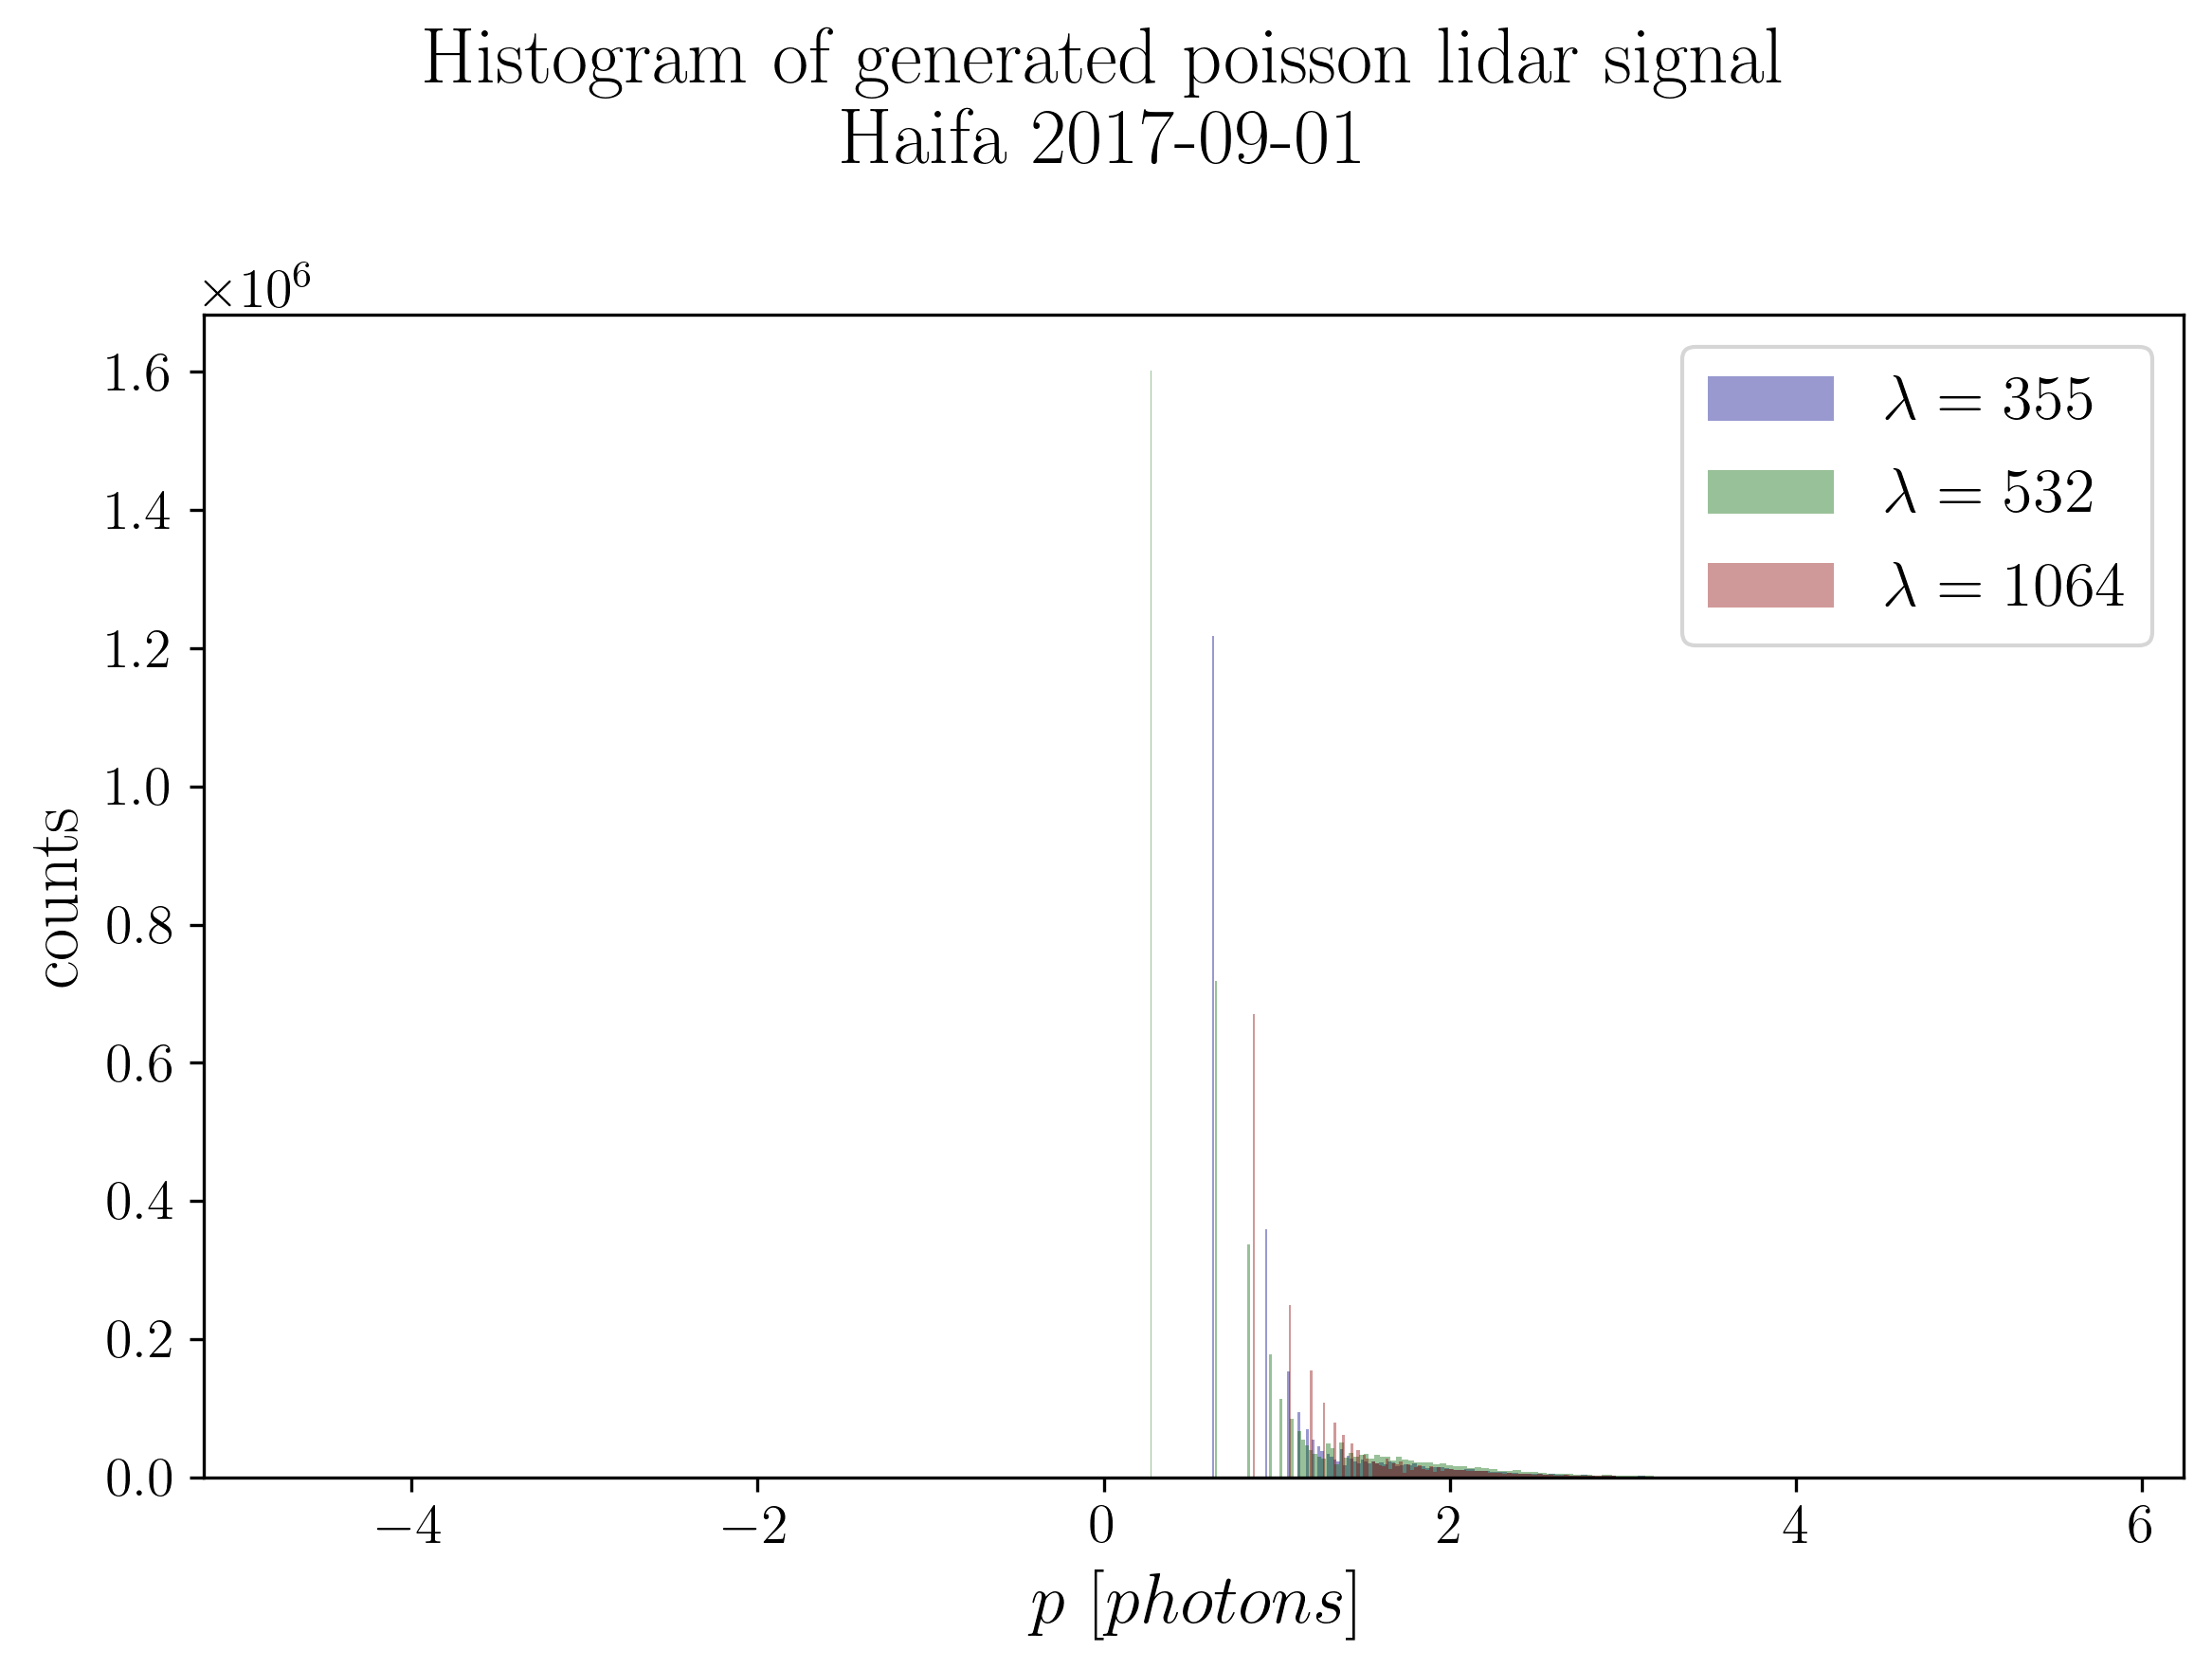

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,66.458252,0.0,-3.0922259681557316,2.9814231891552896
1,532,100.0,48.498935,51.501065,0.0,-2.2821785887625197,3.0340189982116854
2,1064,100.0,23.259421,76.740579,0.0,-3.6845088691179764,2.7613030793467495


In [39]:
pt = QuantileTransformer(output_distribution='normal')
lidar_p_quant_data = pt.fit_transform(lidar_ds.p.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
lidar_ds = lidar_ds.assign(p_quant = (lidar_ds.p.sizes, lidar_p_quant_data))
lidar_ds.p_quant.attrs.update(lidar_ds.p.attrs)
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='p_quant',nbins=150)#,log_scale=True)
lidar_stats







## Lidar Power Manual

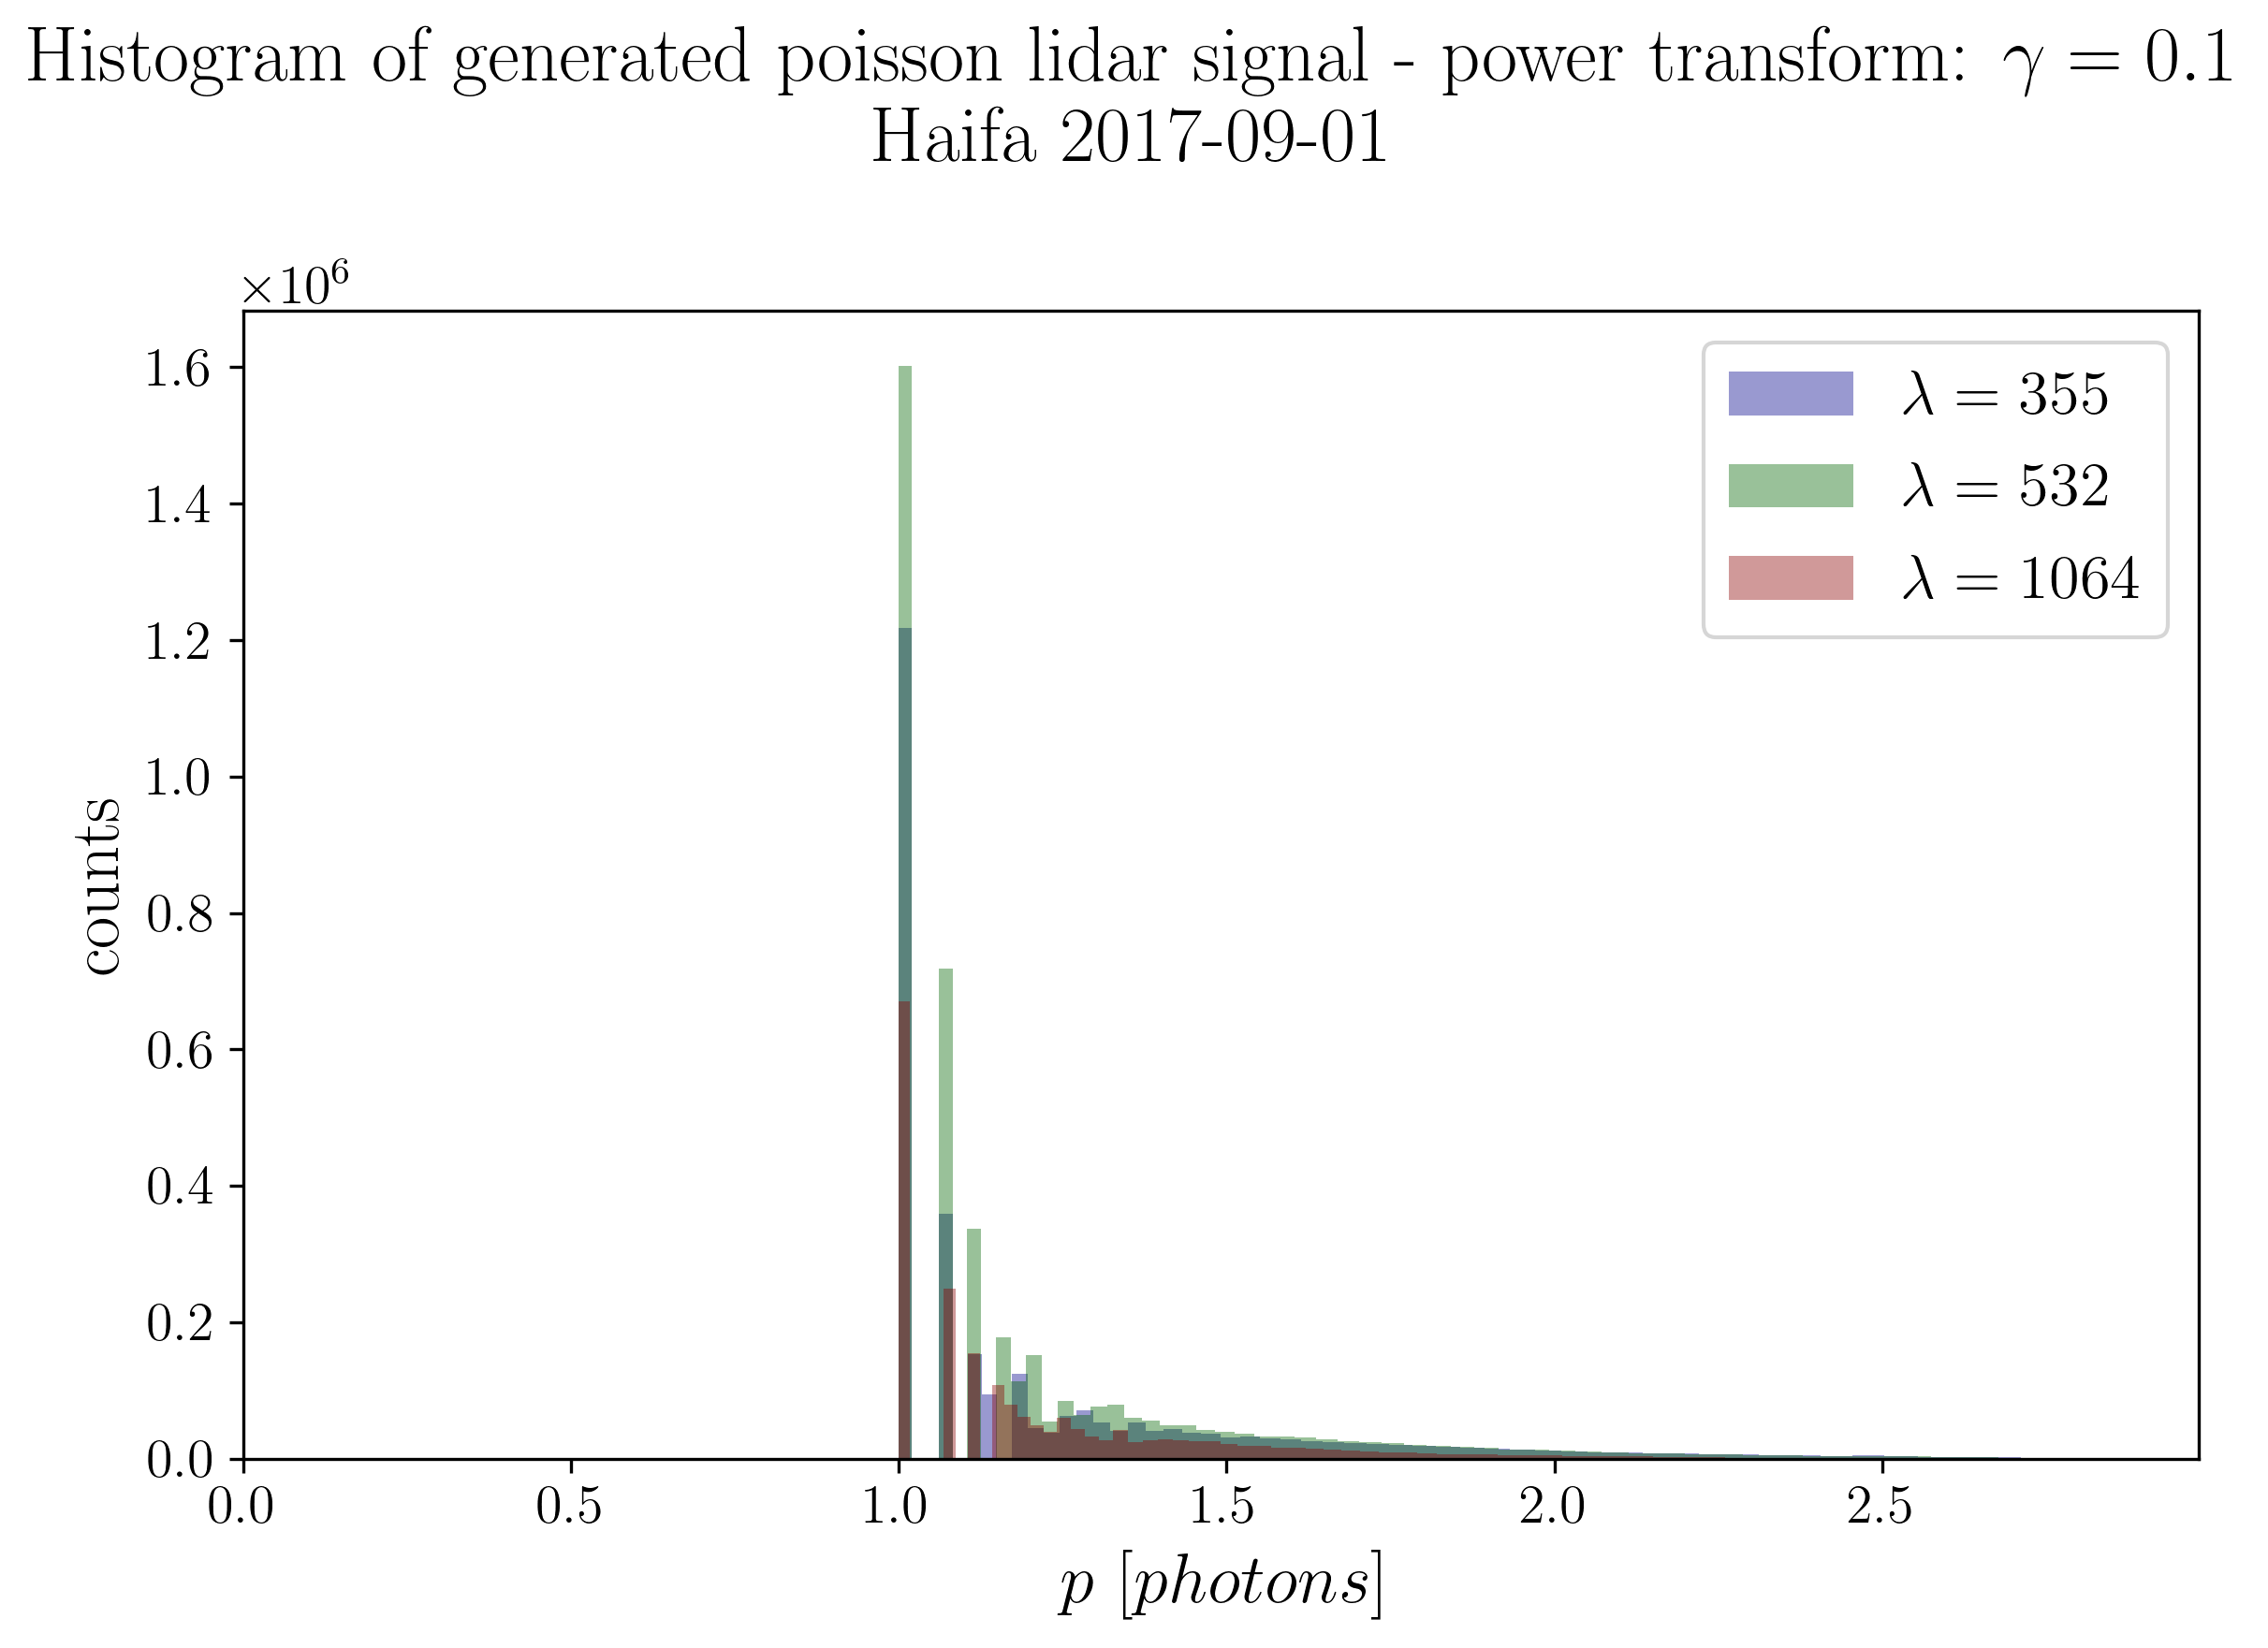

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,0.0,66.458252,0.4048202708927447,0.5959897947881754
1,532,100.0,48.498935,0.0,51.501065,0.5715054939154784,0.6168120262784013
2,1064,100.0,23.259421,0.0,76.740579,0.2778265440515026,0.5175142480275837


In [18]:
gamma_p = 0.1
pn_pow = xr.apply_ufunc(lambda x: x**gamma_p, lidar_ds.p ,keep_attrs=True)
# %%
pn_pow = pn_pow.assign_attrs({'info':pn_pow.attrs['info'] + fr' - Power transform: $\gamma={gamma_p}$'})
lidar_ds = lidar_ds.assign(pnpow= pn_pow)

# %%
_,_,pn_pow_stats= daily_ds_histogram(lidar_ds, profile_type='pnpow',nbins=50)
pn_pow_stats



# 6. Lidar range corrected measurement
# TODO: test transformers on lidar_ds.range_corr


## Lidar Rangecorr

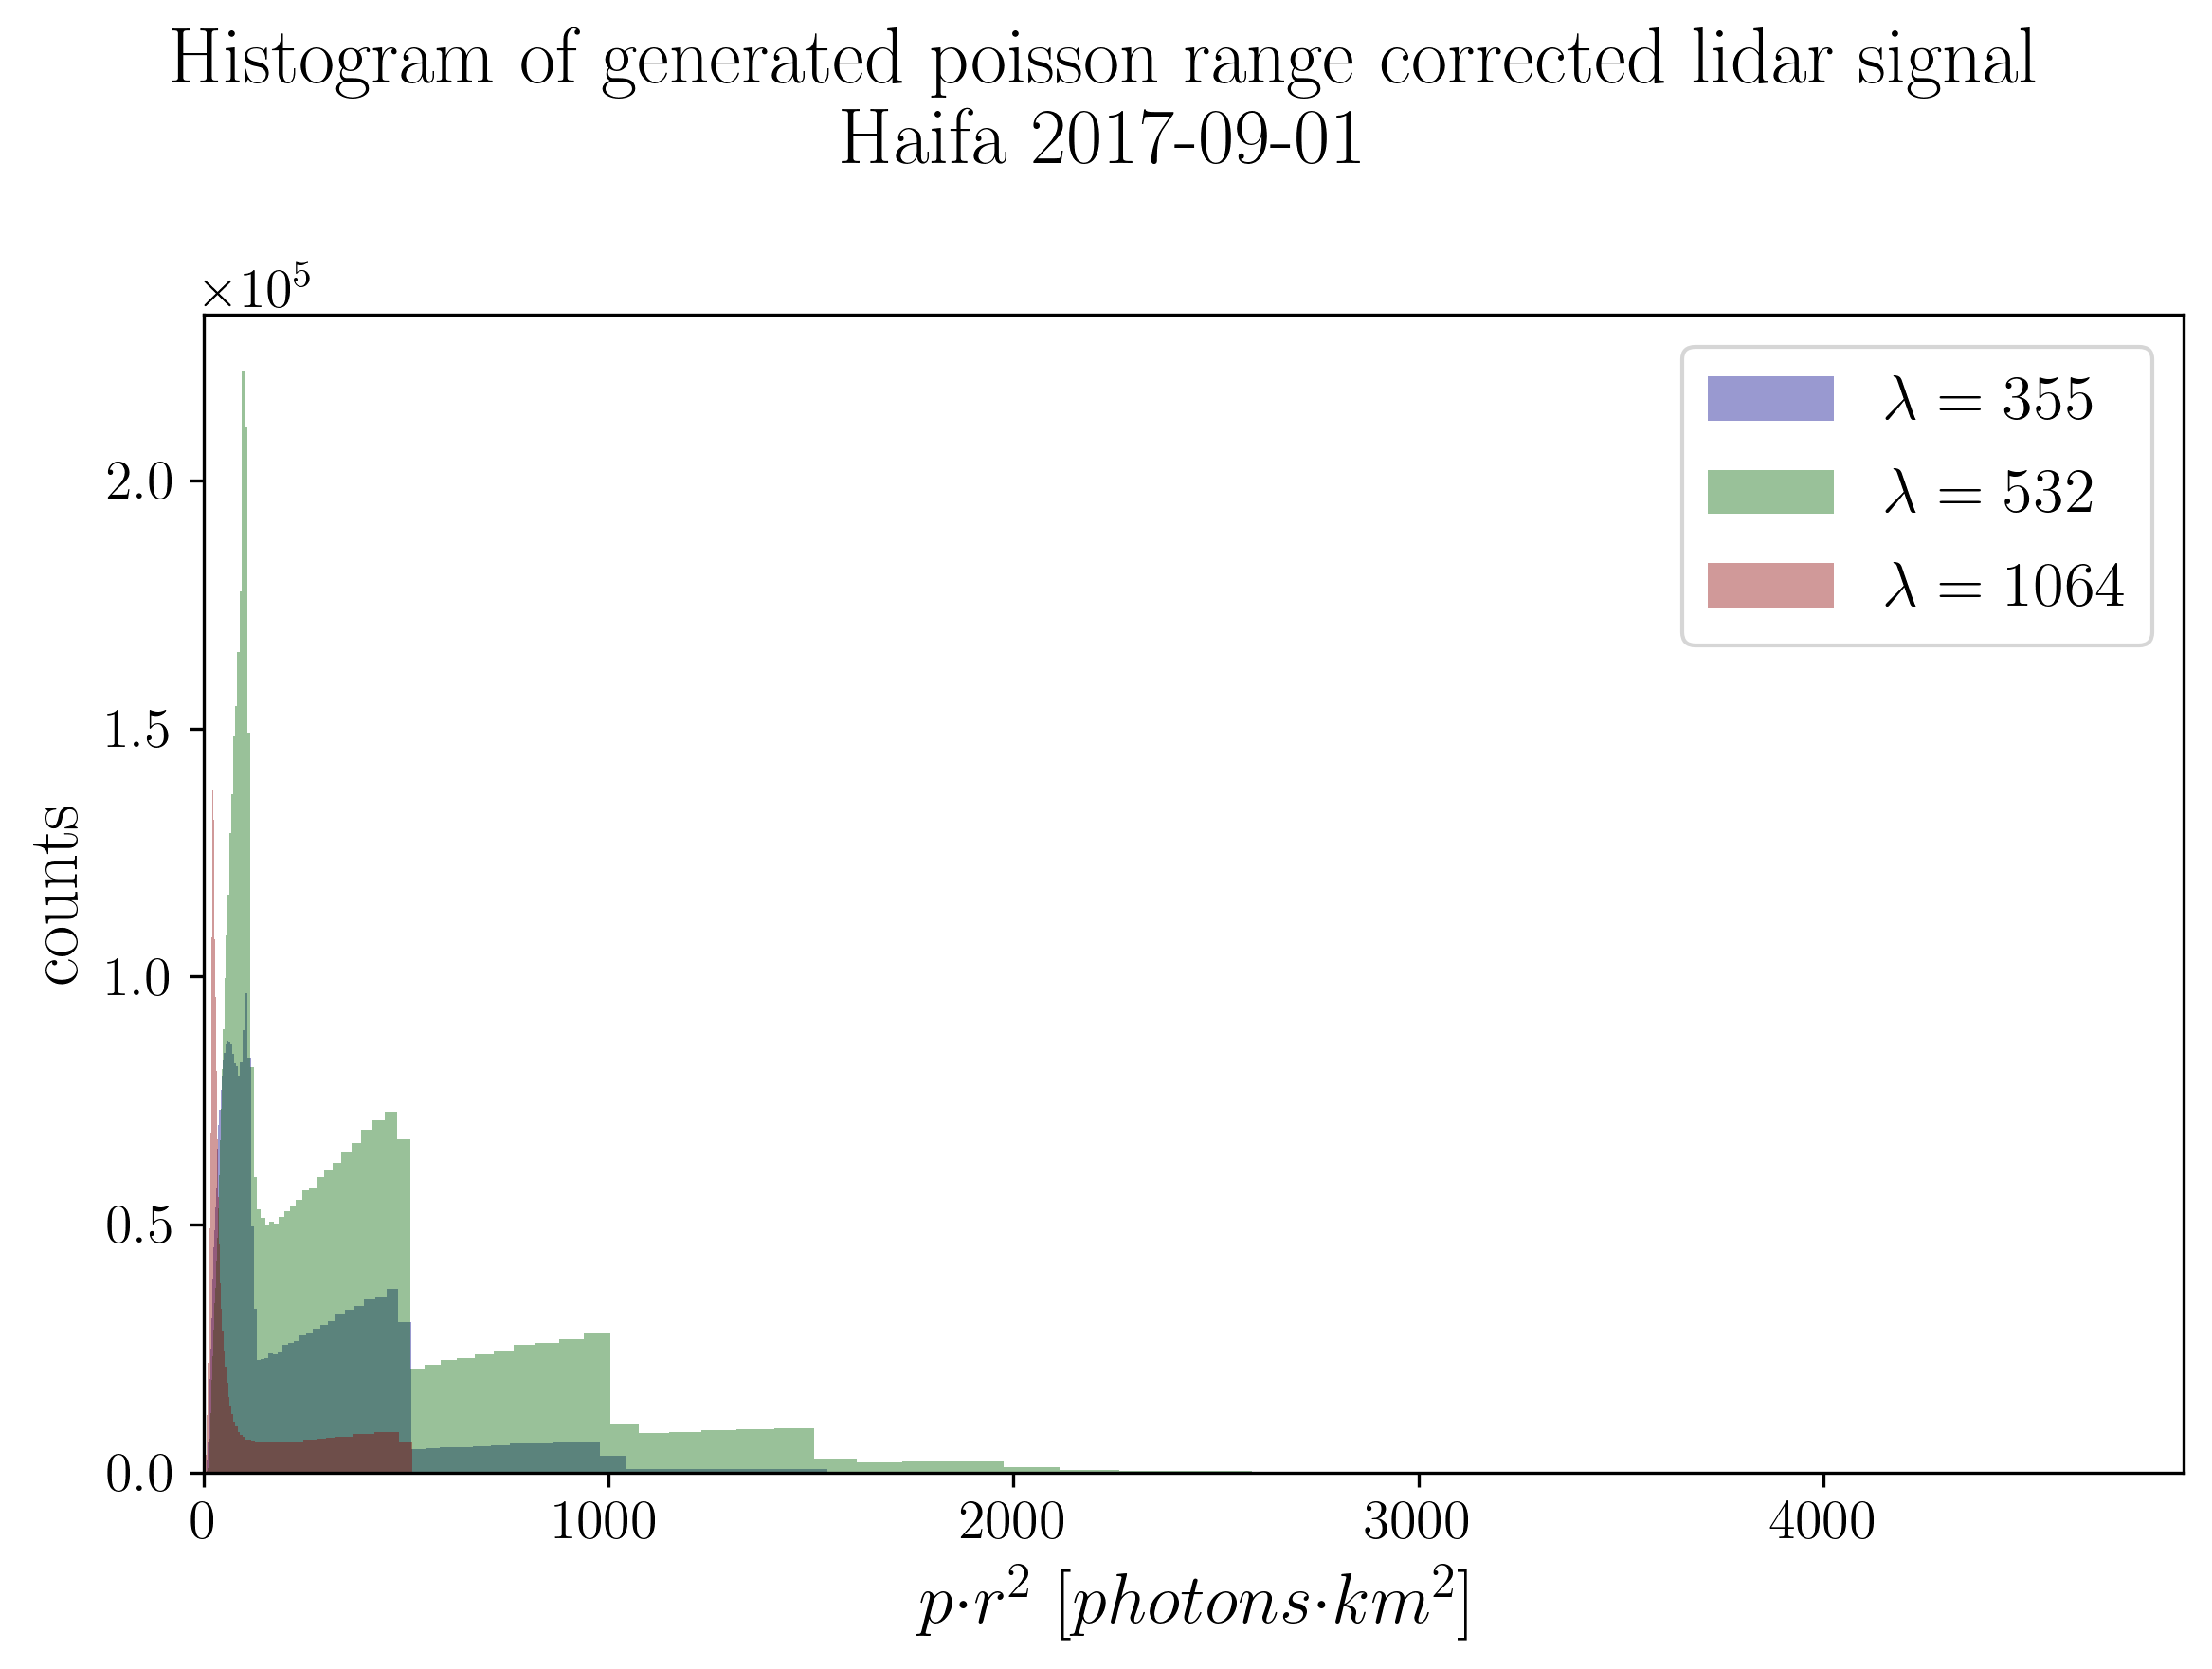

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,0.0,66.458252,41.545986,106.5648
1,532,100.0,48.498935,0.0,51.501065,93.53214,192.64603
2,1064,100.0,23.259421,0.0,76.740579,10.953783,42.731964


In [15]:
_,_,pr2n_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr',nbins=100)#,log_scale=True)
pr2n_stats

## Lidar Rangecorr Power Manual

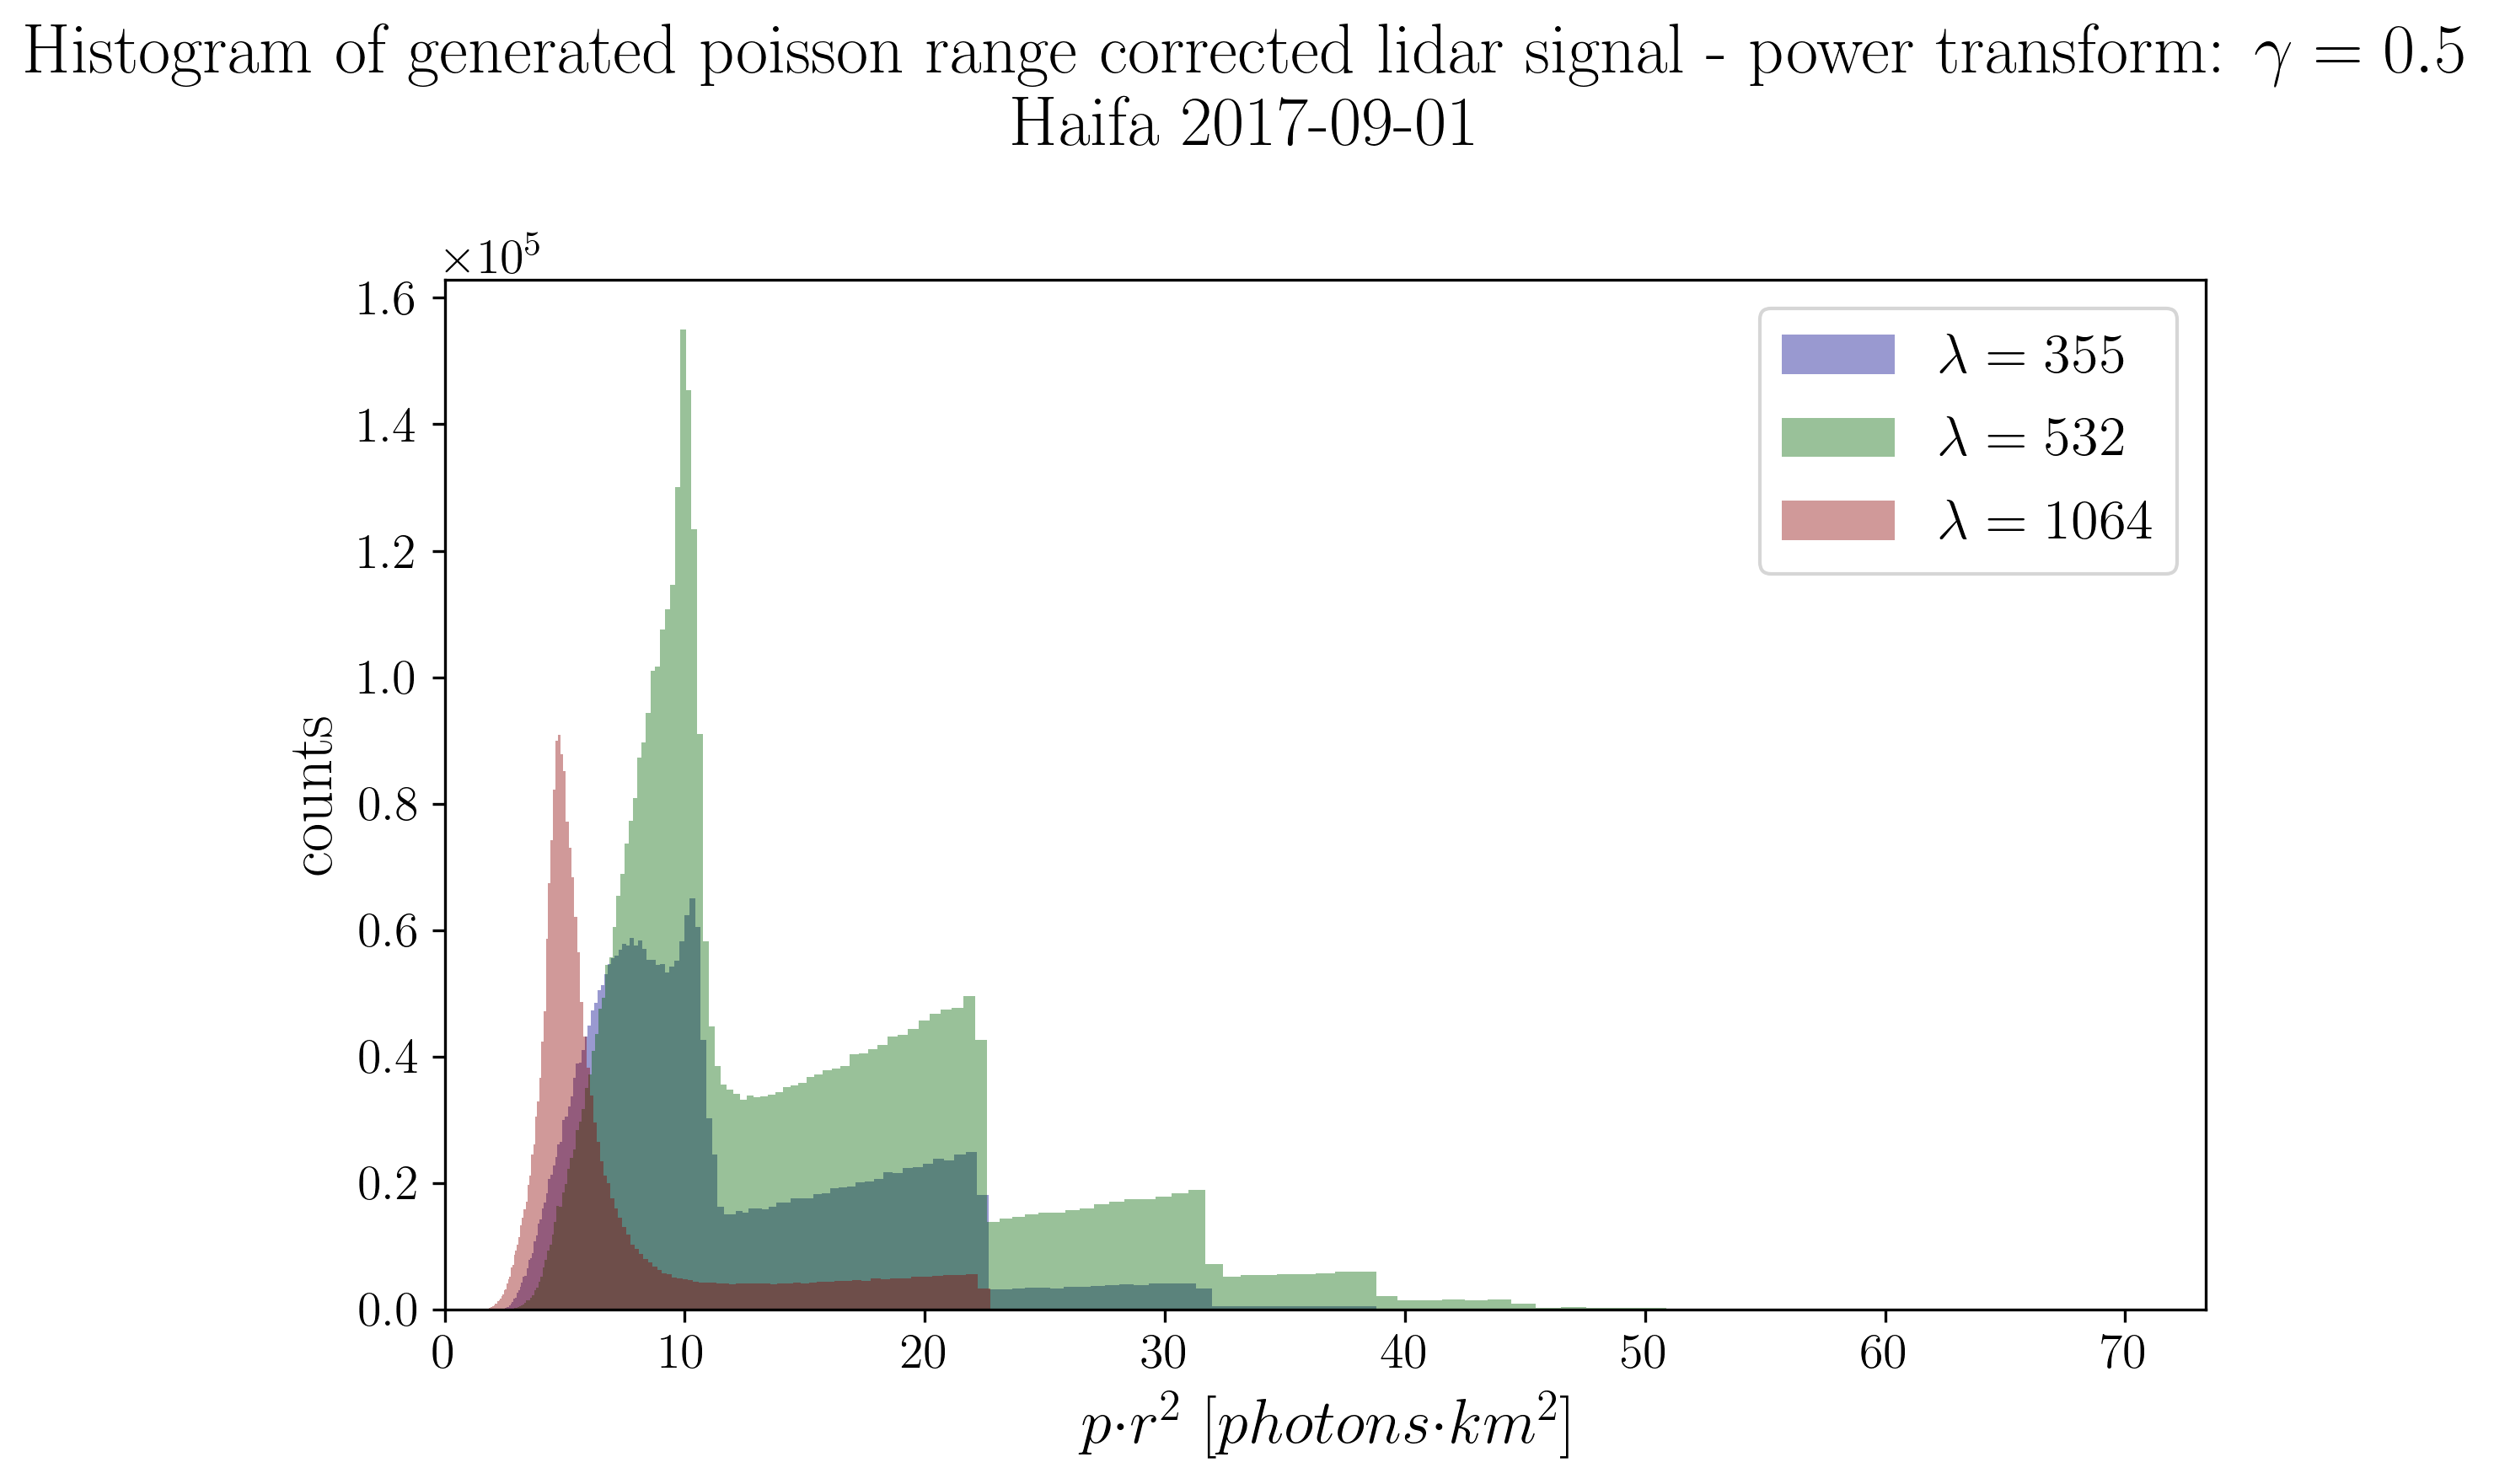

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,0.0,66.458252,3.282505,5.5471725
1,532,100.0,48.498935,0.0,51.501065,5.921156,7.646704
2,1064,100.0,23.259421,0.0,76.740579,1.380827,3.0078406


In [17]:
gamma_pr2 = 0.5
pr2n_pow = xr.apply_ufunc(lambda x: x**gamma_pr2, lidar_ds.range_corr ,keep_attrs=True)
# %%
pr2n_pow = pr2n_pow.assign_attrs({'info':pr2n_pow.attrs['info'] +
                                         fr' - Power transform: $\gamma={gamma_pr2}$'})
lidar_ds = lidar_ds.assign(pr2pow= pr2n_pow)

# %%
_,_,pr2_pow_stats= daily_ds_histogram(lidar_ds, profile_type='pr2pow',nbins=150)
pr2_pow_stats

## Lidar Rangecorr Power

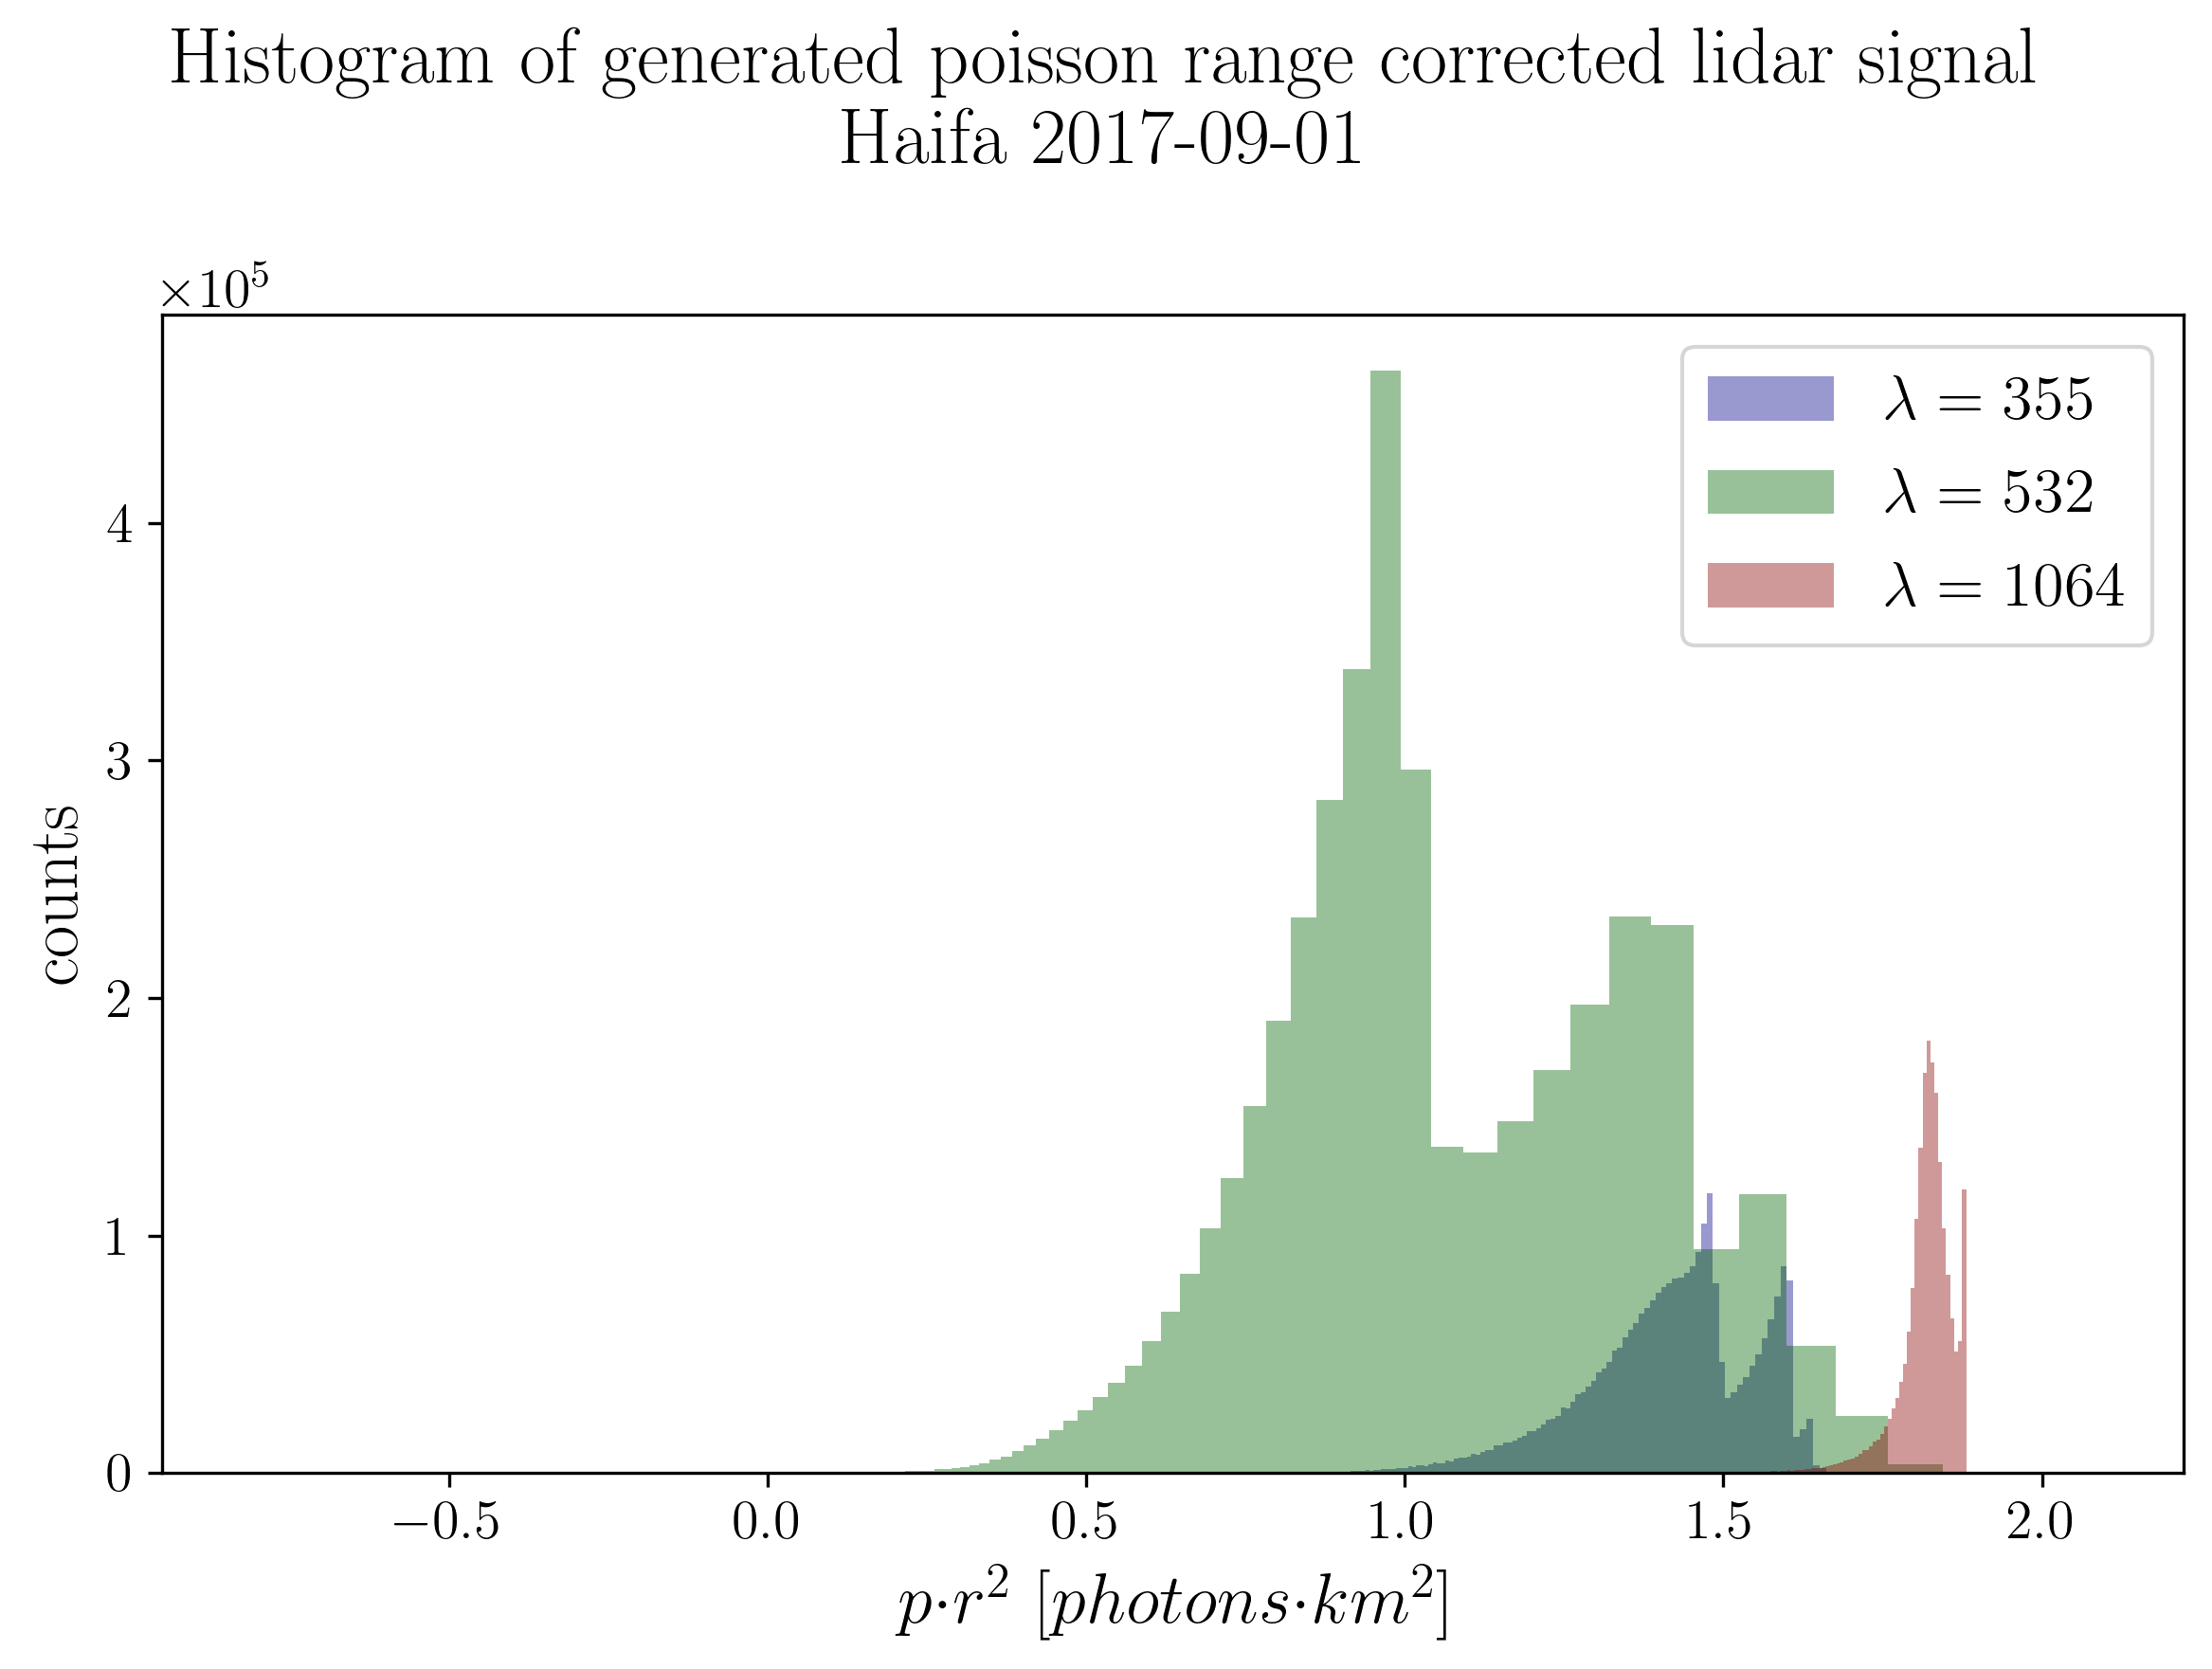

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,66.458252,0.0,8.186058e-08,1.0
1,532,100.0,48.498808,51.501192,0.0,-7.072731e-08,1.0
2,1064,100.0,23.259421,76.740579,0.0,4.1834514e-07,0.99999946


In [19]:
pt = PowerTransformer()
lidar_range_corr_pow_data = pt.fit_transform(lidar_ds.range_corr.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
lidar_ds = lidar_ds.assign(range_corr_pow = (lidar_ds.range_corr.sizes, lidar_range_corr_pow_data))
lidar_ds.range_corr_pow.attrs.update(lidar_ds.range_corr.attrs)
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr_pow',nbins=150)#,log_scale=True)
lidar_stats

## Lidar Rangecorr Quantile

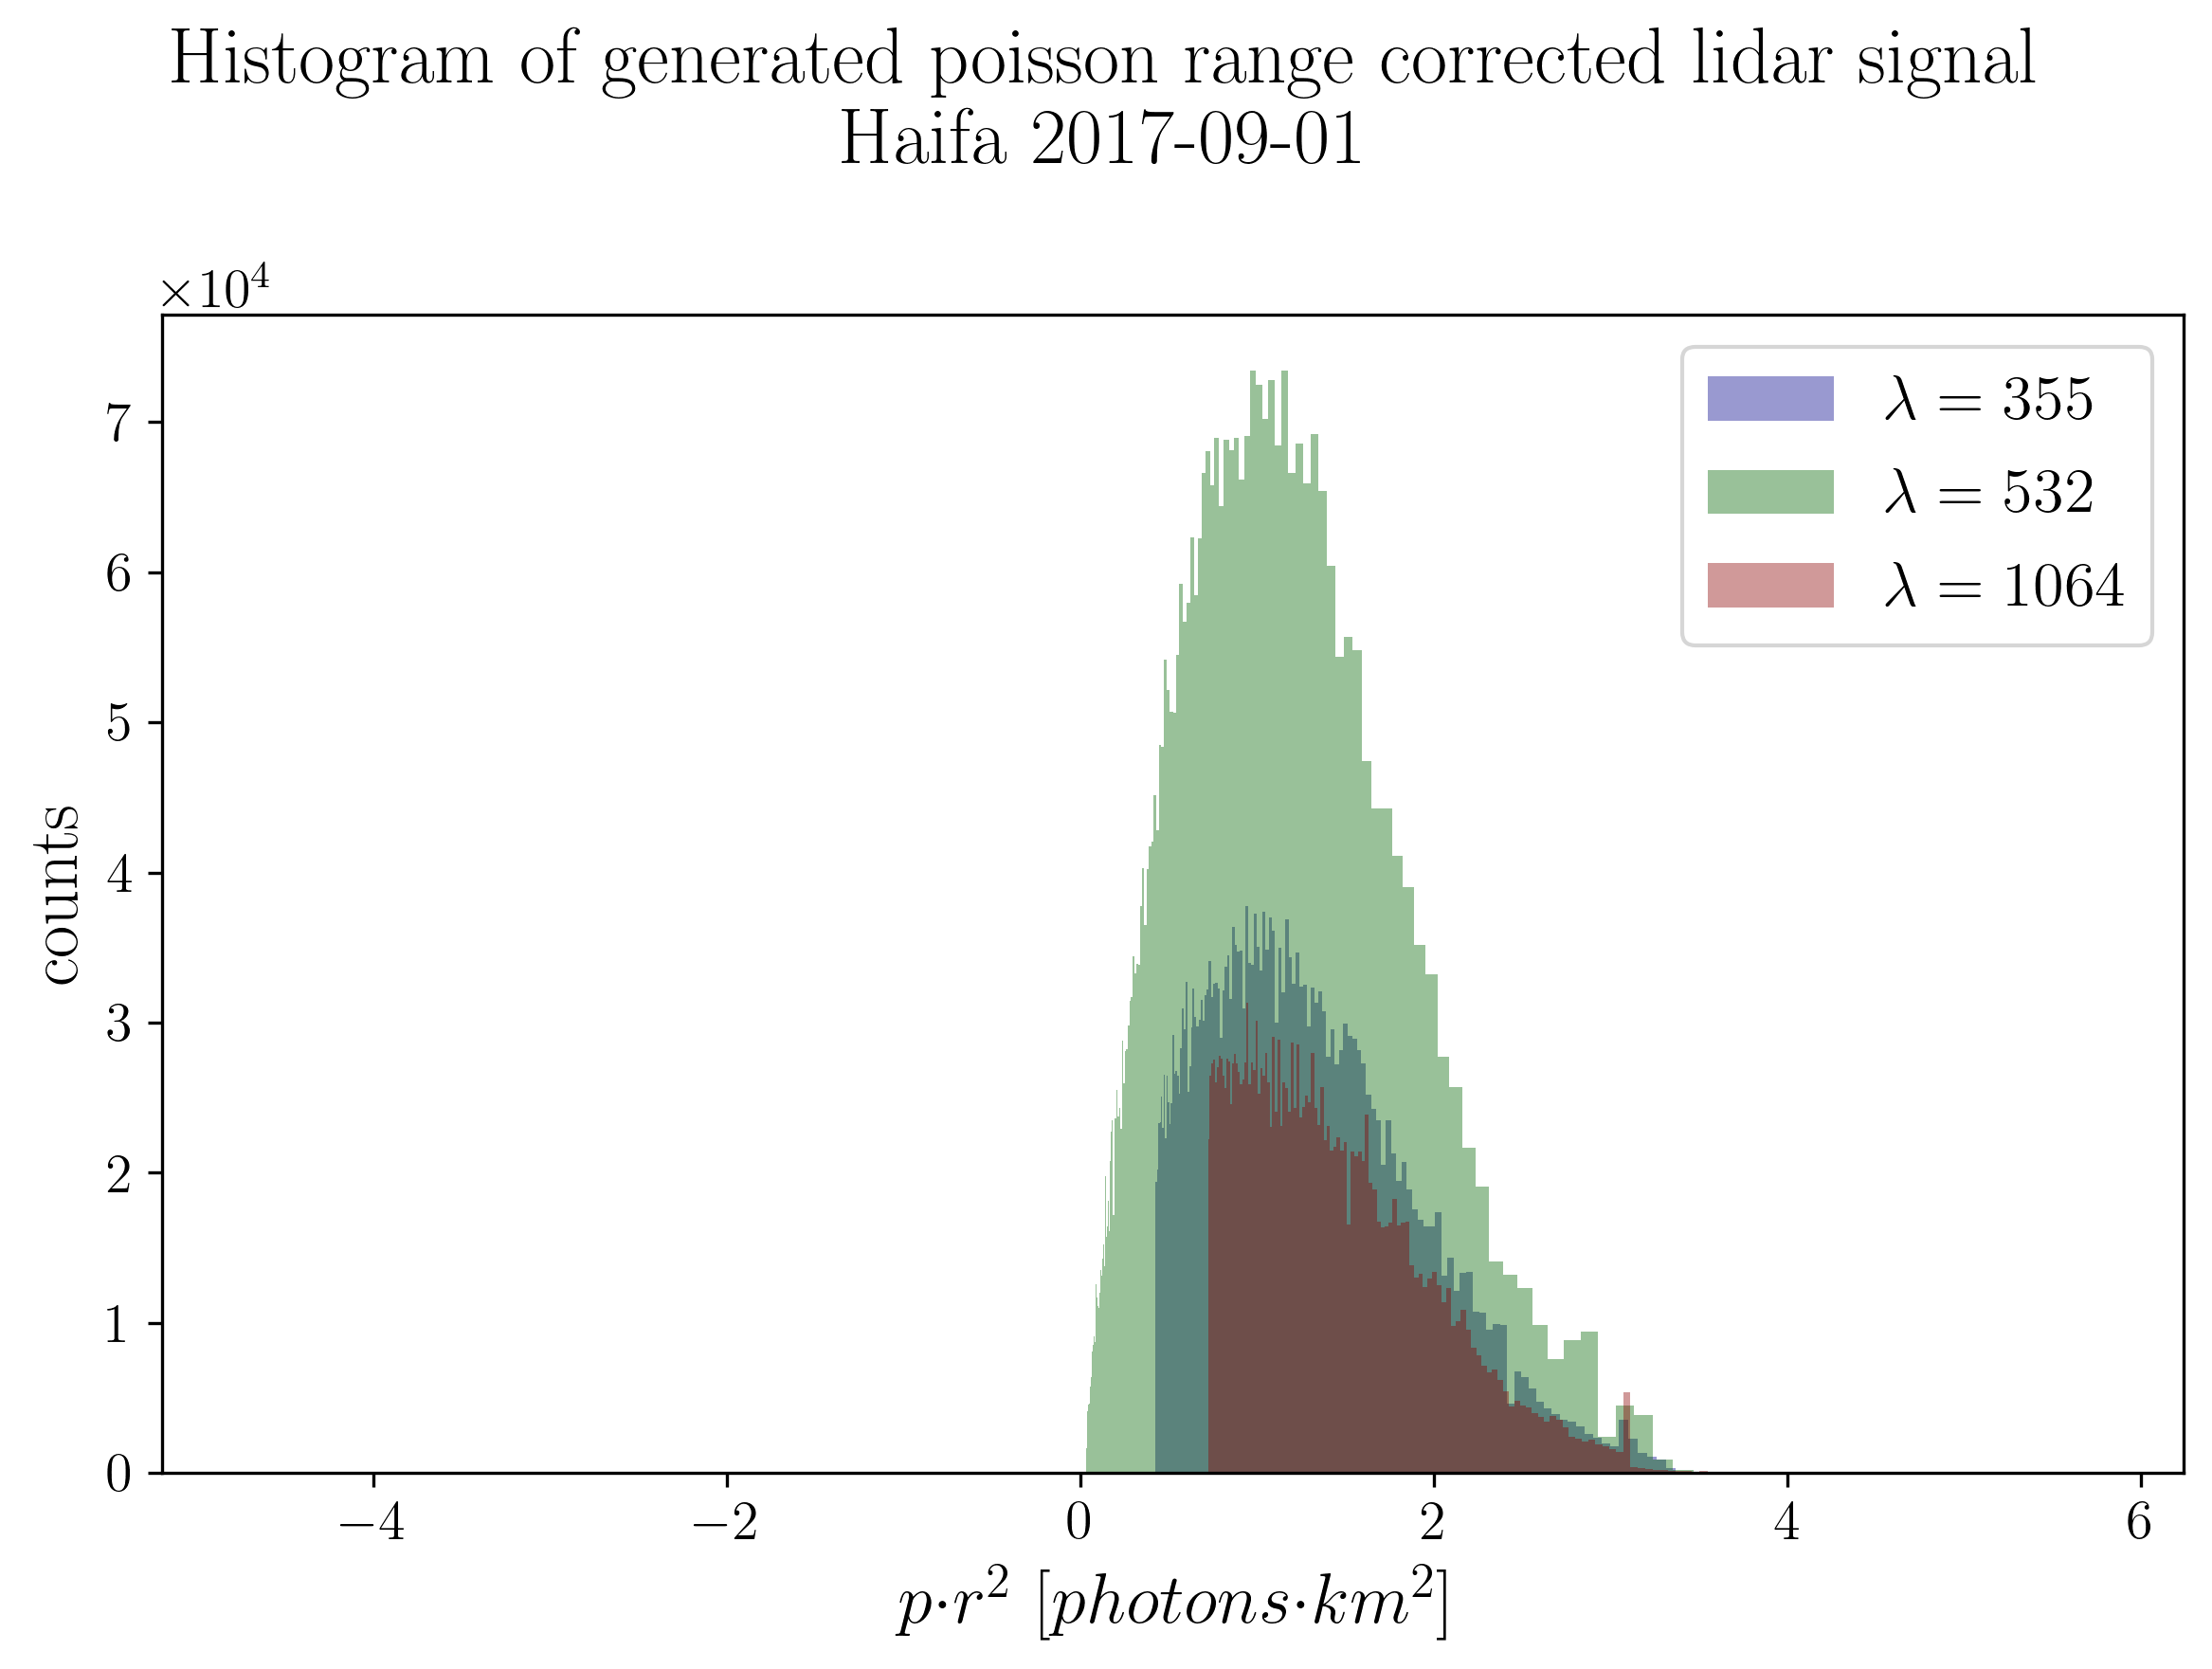

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,33.541748,66.458252,0.0,-3.089976,2.9849308
1,532,100.0,48.498935,51.501065,0.0,-2.2814724,3.034993
2,1064,100.0,23.259421,76.740579,0.0,-3.6870868,2.7566462


In [38]:
pt = QuantileTransformer(output_distribution='normal')
lidar_range_corr_quant_data = pt.fit_transform(lidar_ds.range_corr.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
lidar_ds = lidar_ds.assign(range_corr_quant = (lidar_ds.range_corr.sizes, lidar_range_corr_quant_data))
lidar_ds.range_corr_quant.attrs.update(lidar_ds.range_corr.attrs)
_,_,lidar_stats= daily_ds_histogram(lidar_ds, profile_type='range_corr_quant',nbins=150)#,log_scale=True)
lidar_stats



# 7. Molecular signal (attenuated backscatter)
# TODO: test transformers on mol_ds.attbsc

In [22]:
mol_folder = prep.get_month_folder_name(station.molecular_dataset,dt_day)
mol_nc_name = os.path.join(mol_folder, prep.get_prep_dataset_file_name(station,dt_day,data_source='molecular',lambda_nm='all'))
mol_ds = prep.load_dataset(mol_nc_name)

## Molecular

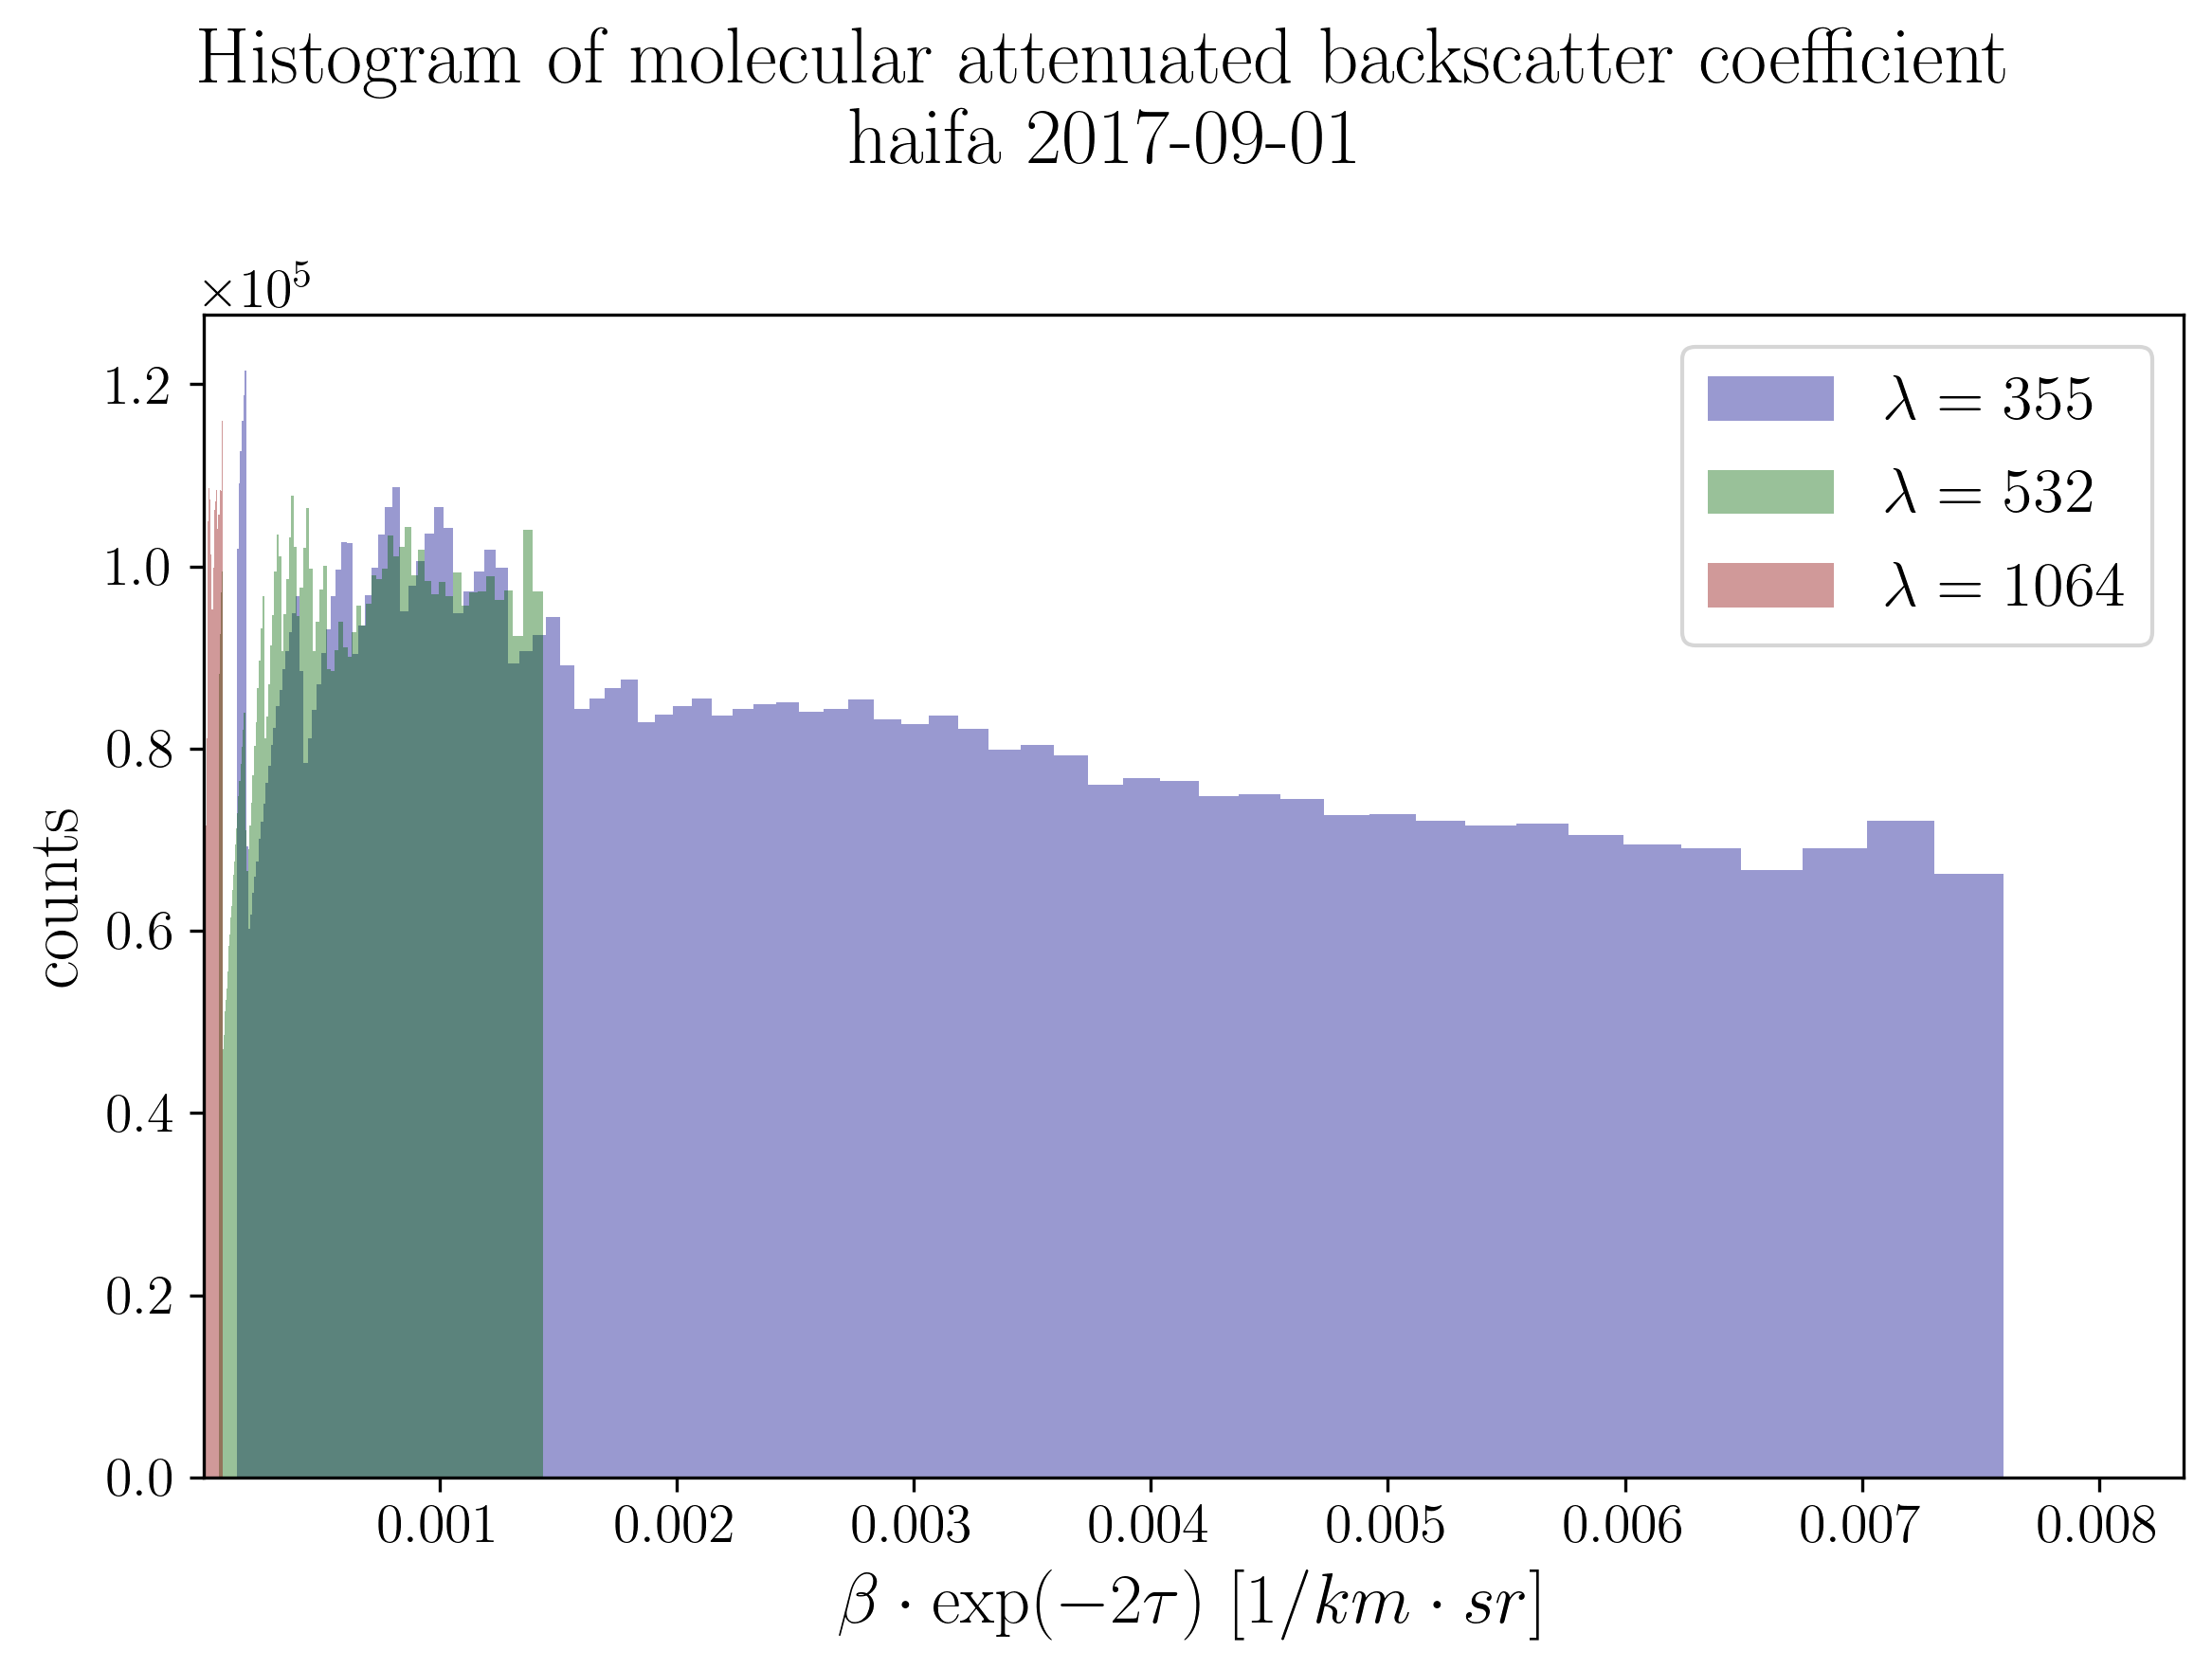

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,100.0,0.0,0.0,0.001734049,0.0018138989
1,532,100.0,100.0,0.0,0.0,0.0004884185,0.00037392322
2,1064,100.0,100.0,0.0,0.0,3.257454e-05,2.3094392e-05


In [23]:
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc',nbins=100)#,log_scale=True)
mol_stats

## Molecular Power Manual

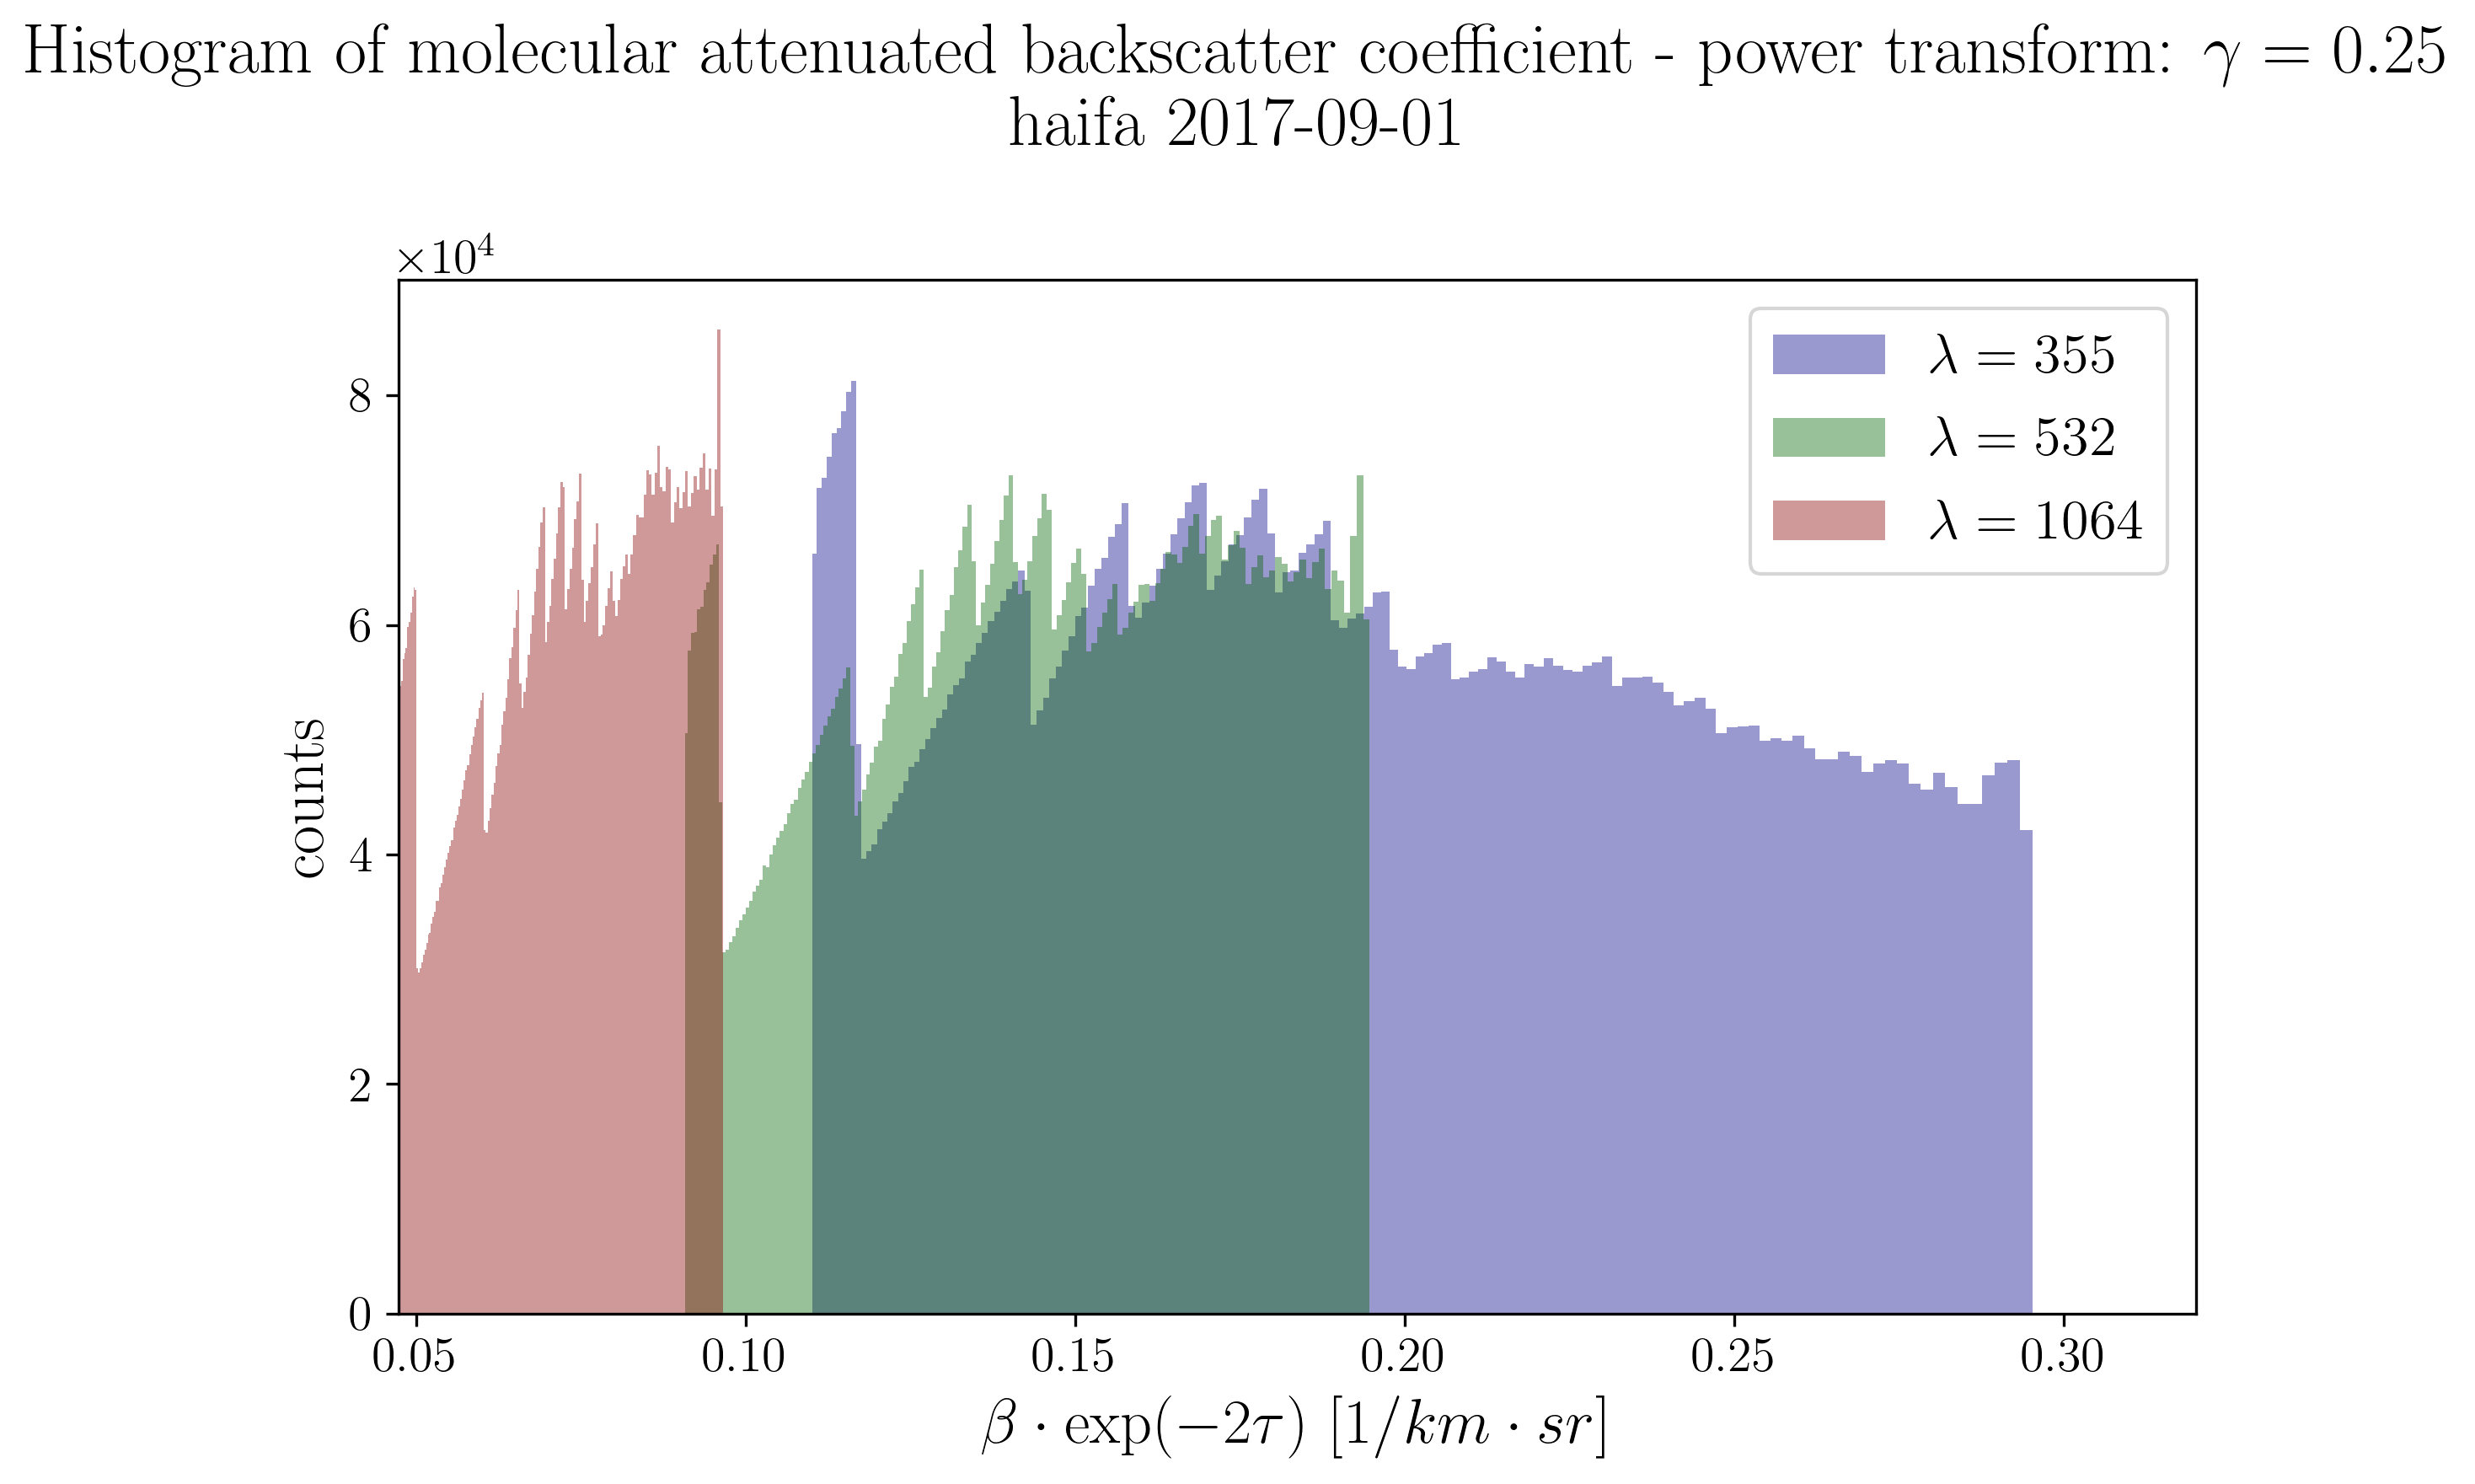

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,100.0,0.0,0.0,0.18425617,0.050865114
1,532,100.0,100.0,0.0,0.0,0.13988899,0.029594025
2,1064,100.0,100.0,0.0,0.0,0.0716128,0.014198964


In [24]:
gamma_mol = 0.25
mol_attbsc_pow = xr.apply_ufunc(lambda x: x**gamma_mol, mol_ds.attbsc ,keep_attrs=True)
# %%
mol_attbsc_pow = mol_attbsc_pow.assign_attrs({'info':mol_attbsc_pow.attrs['info'] +
                                                     fr' - Power transform: $\gamma={gamma_mol}$'})
mol_ds = mol_ds.assign(attbscpow= mol_attbsc_pow)

# %%
_,_,molattbsc_pow_stats= daily_ds_histogram(mol_ds, profile_type='attbscpow',nbins=150)
molattbsc_pow_stats

## Molecular Power

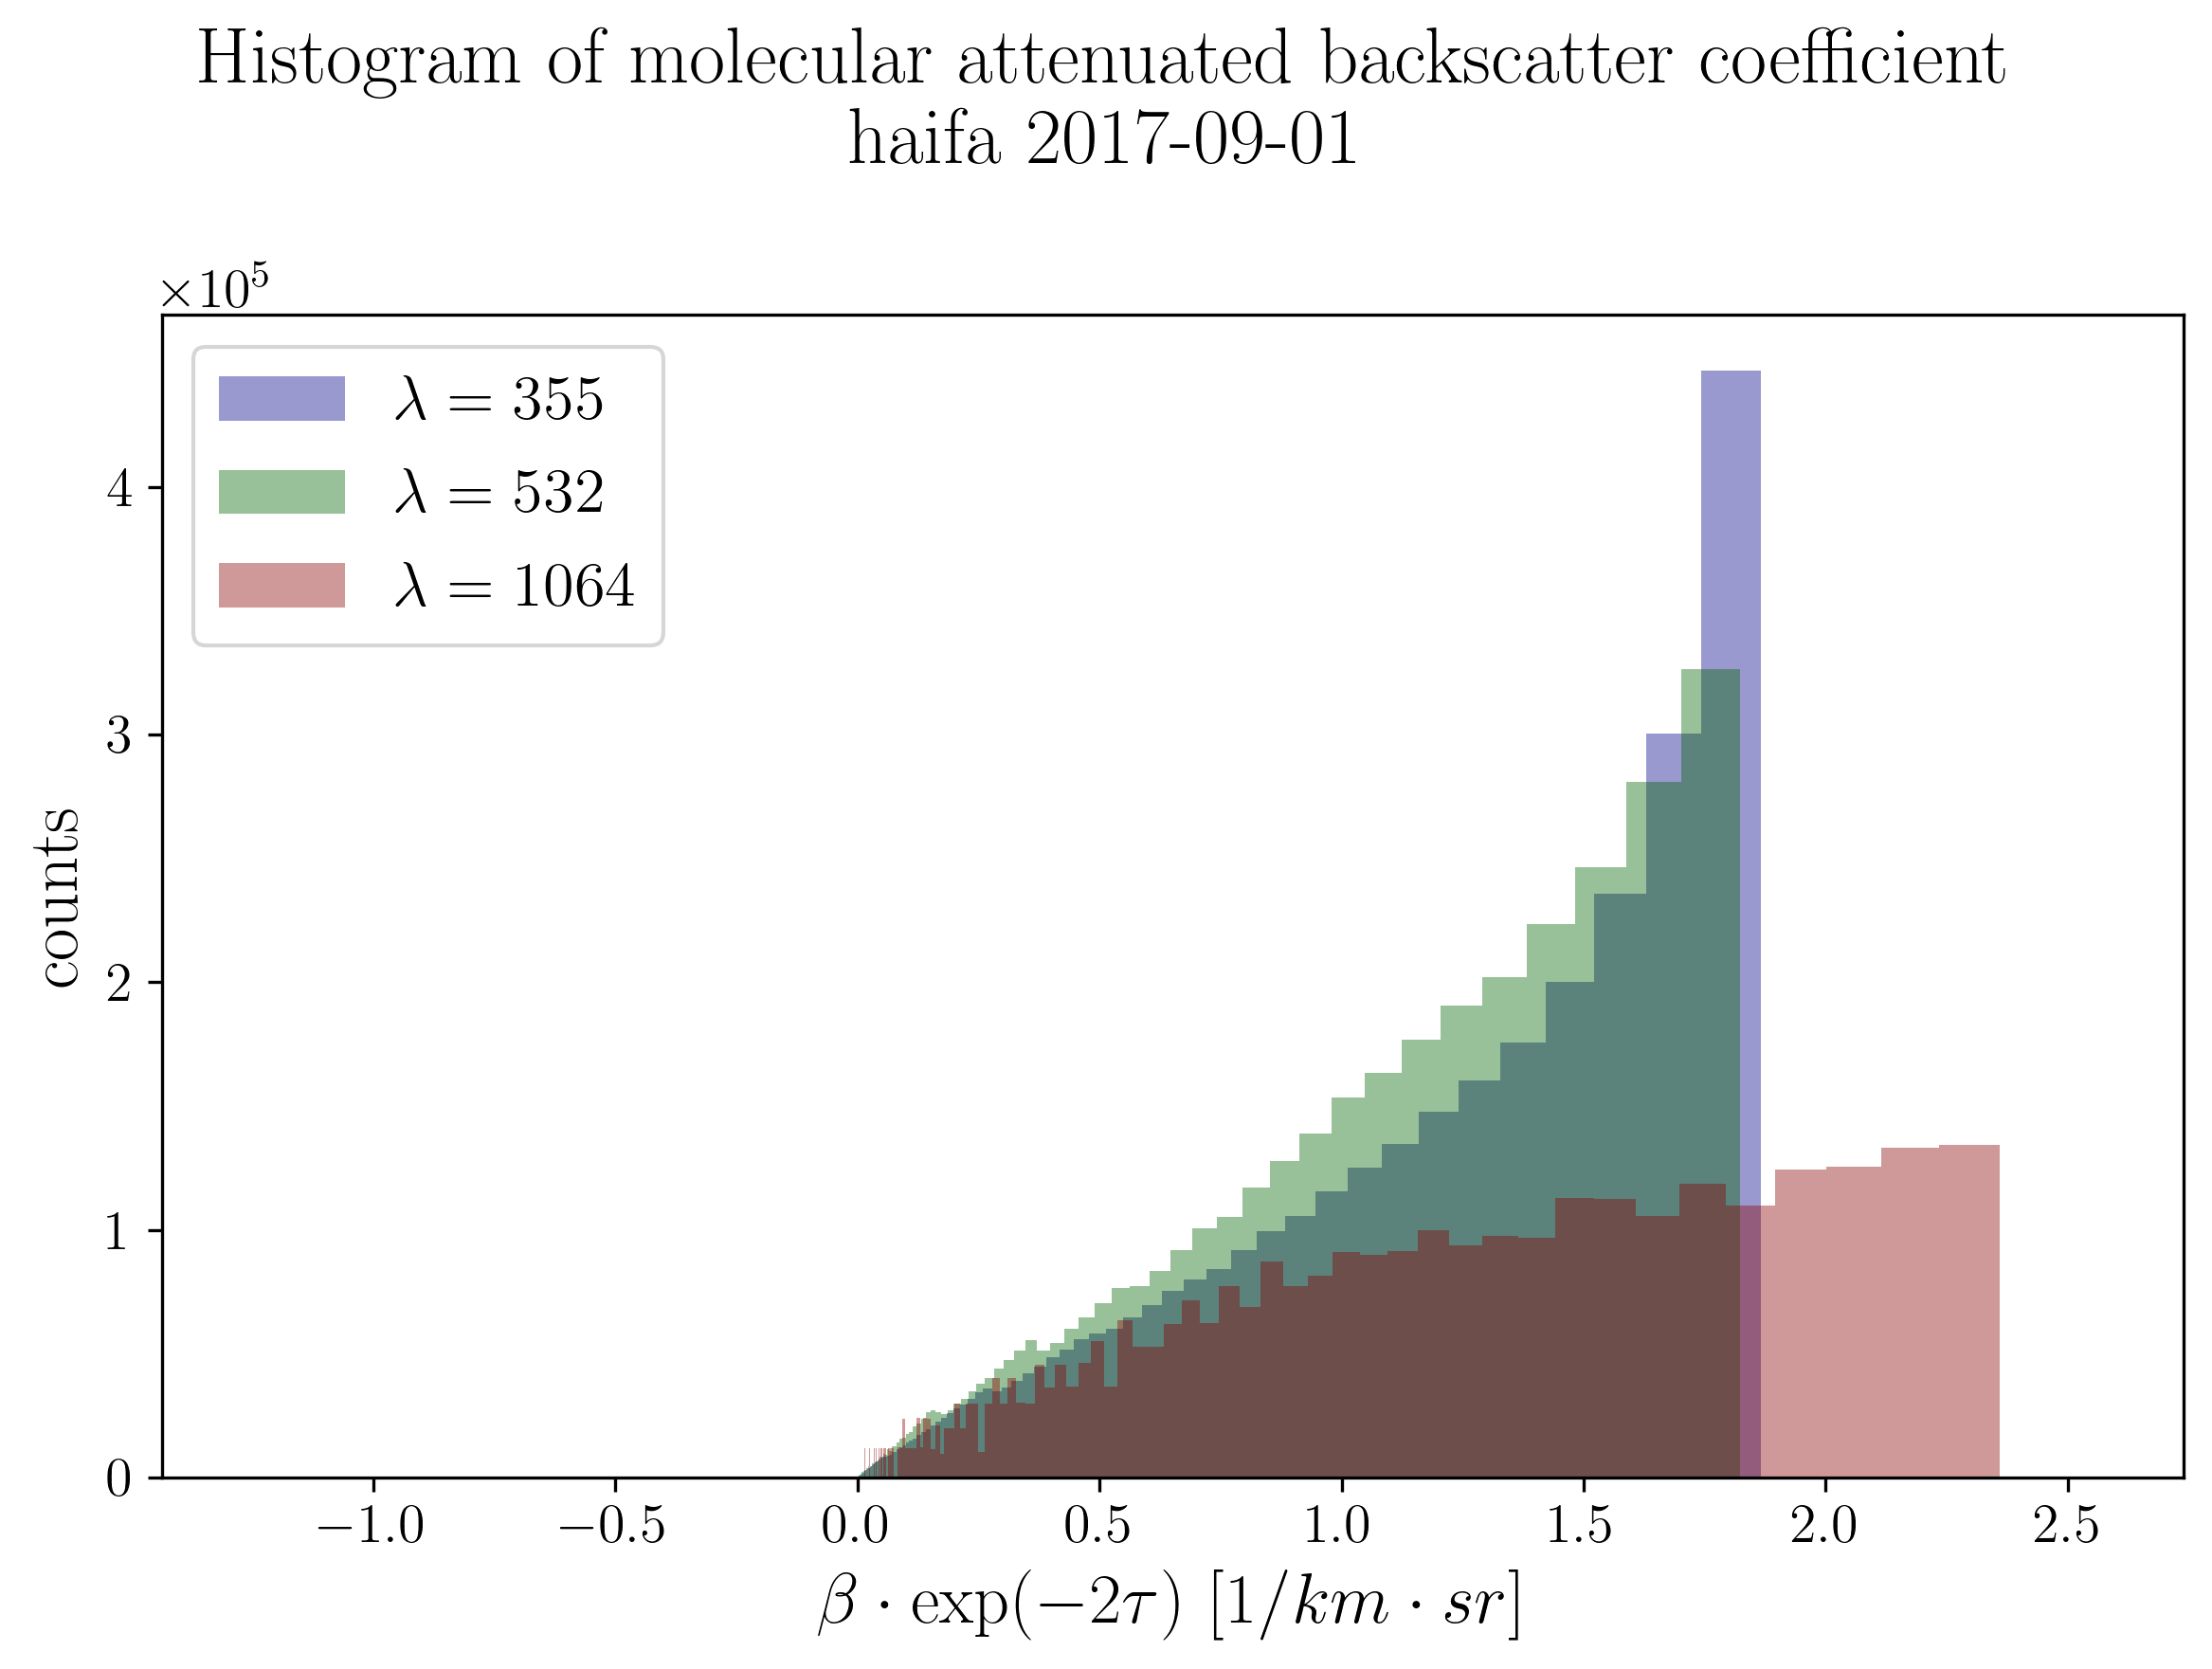

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,43.436701,56.563299,0.0,1.3840287e-07,1.0000002
1,532,100.0,46.594144,53.405856,0.0,-3.189652e-07,1.0
2,1064,100.0,41.224120,58.775880,0.0,1.1246293e-08,1.0000001


In [25]:
pt = PowerTransformer()
mol_attbsc_pow_data = pt.fit_transform(mol_ds.attbsc.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
mol_ds = mol_ds.assign(attbsc_pow = (mol_ds.attbsc.sizes, mol_attbsc_pow_data))
mol_ds.attbsc_pow.attrs.update(mol_ds.attbsc.attrs)
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc_pow',nbins=150)#,log_scale=True)
mol_stats

## Molecular Quantile

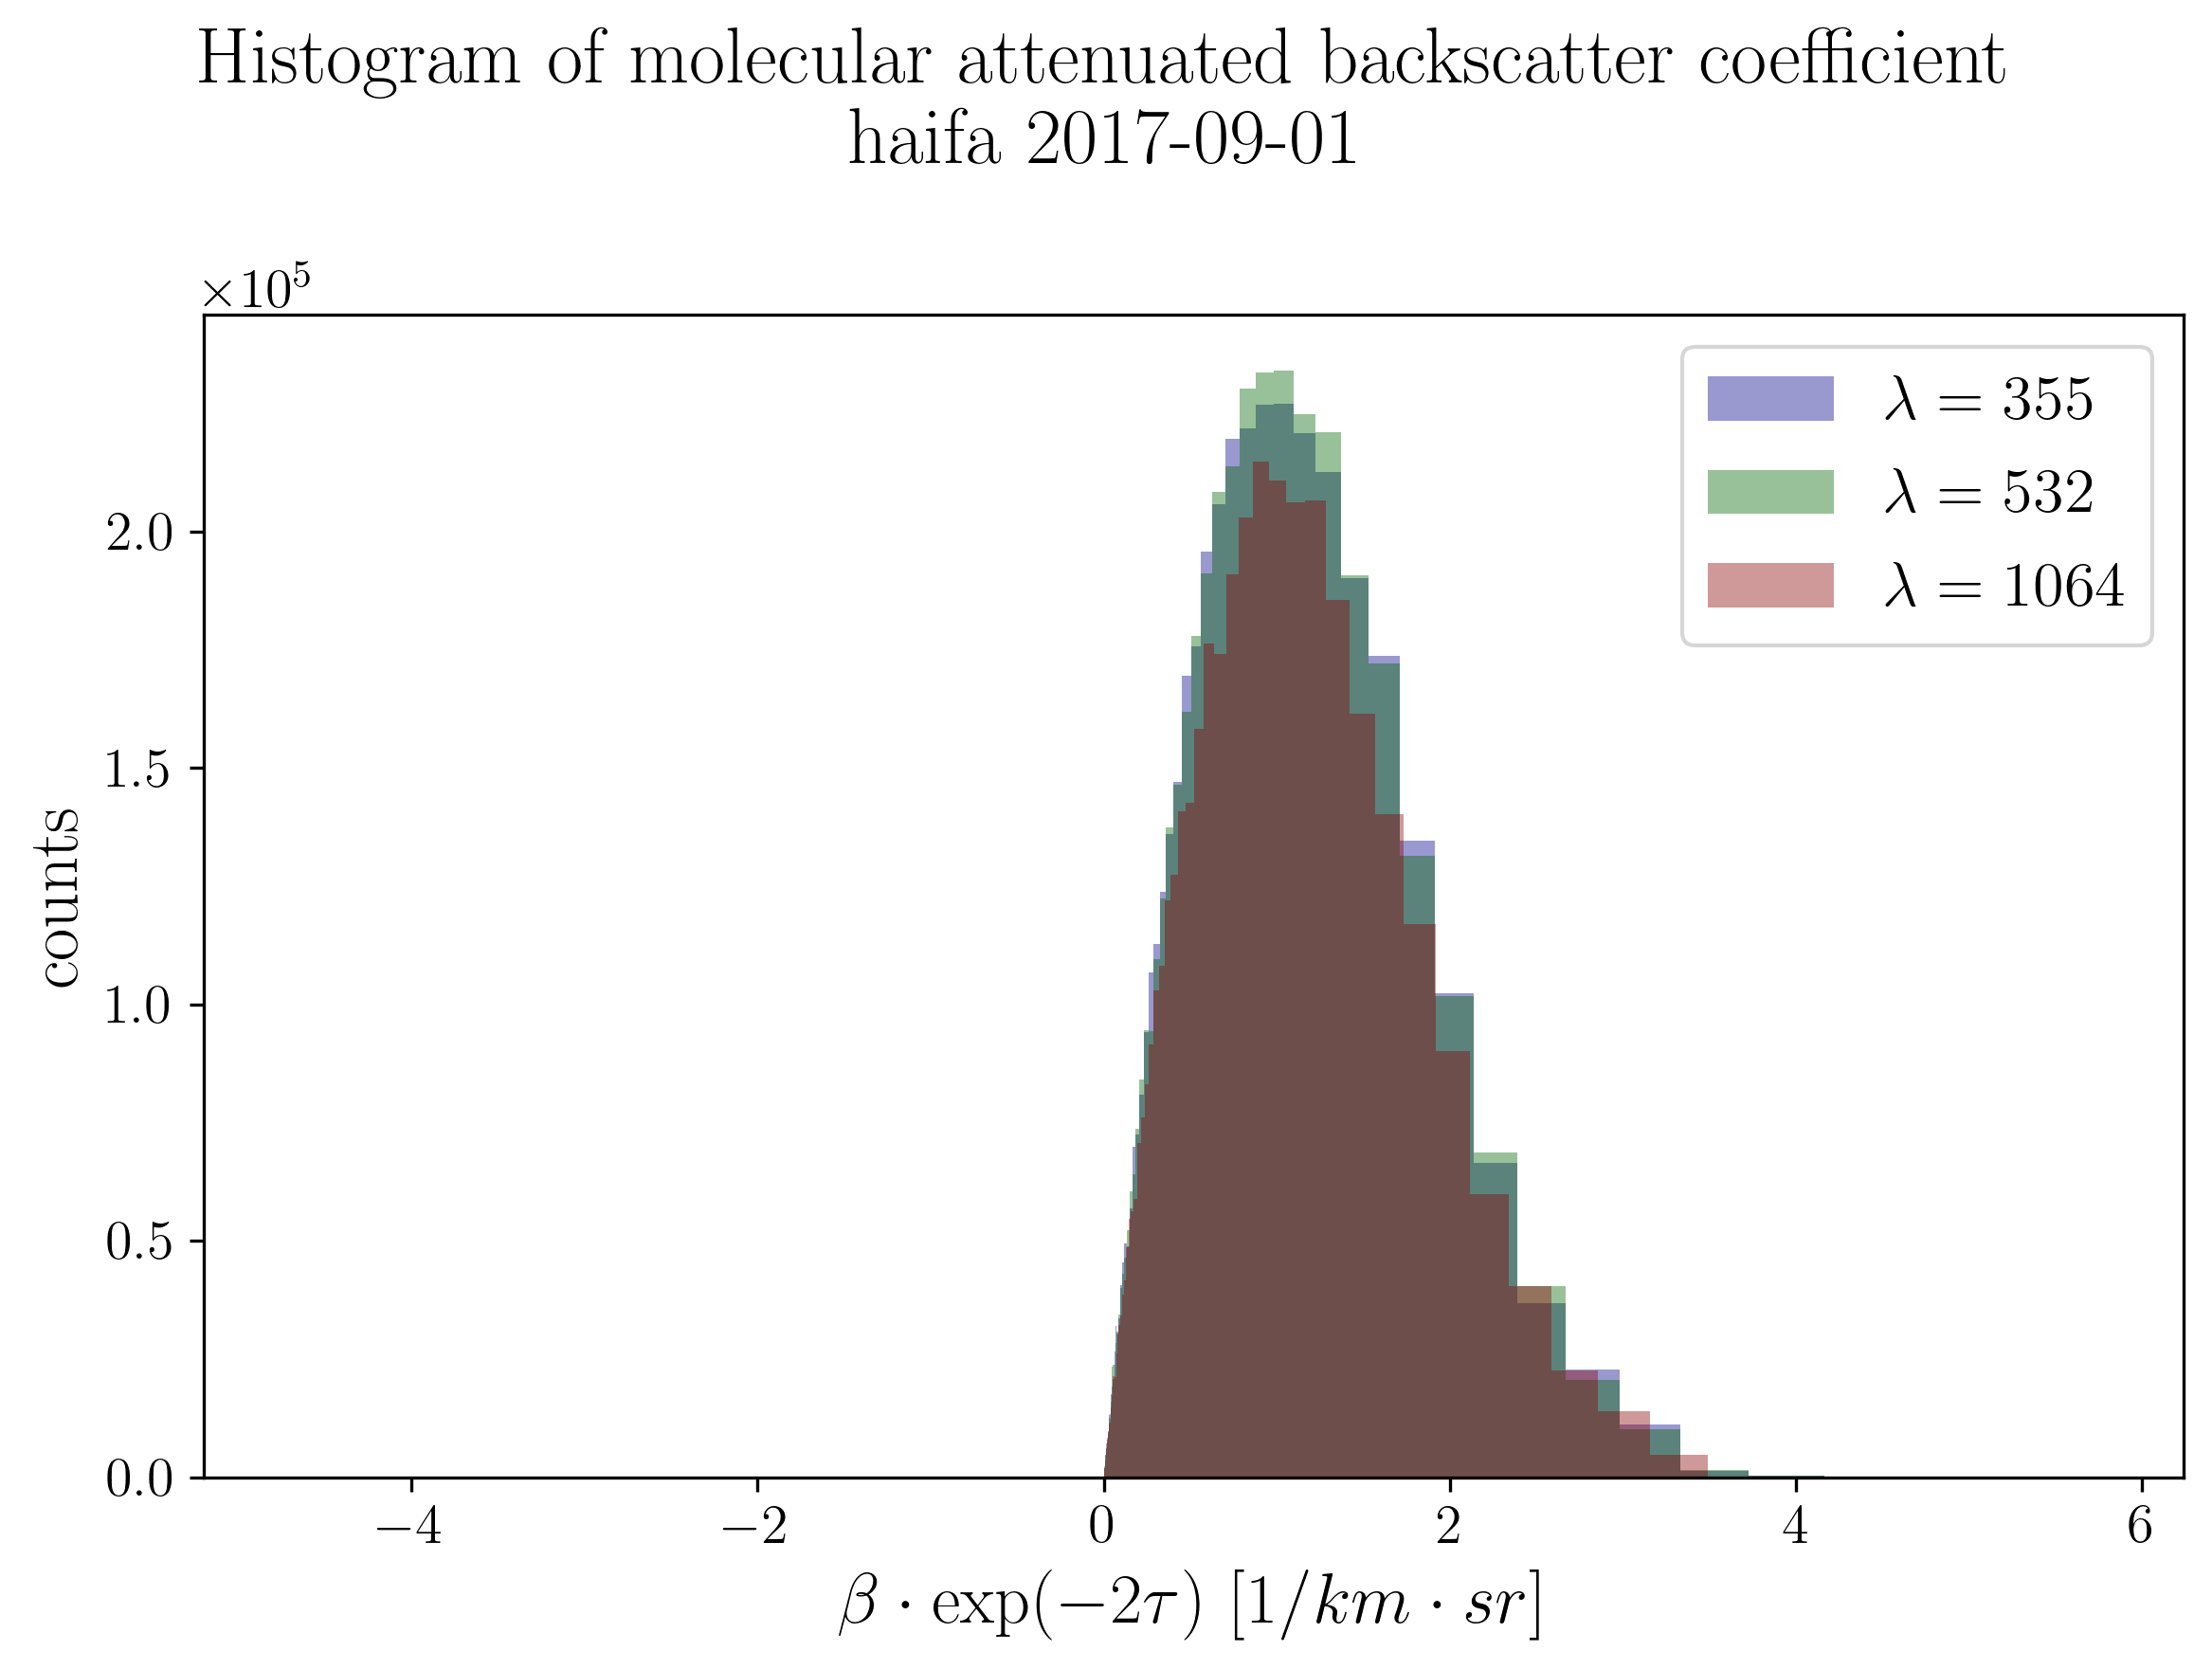

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,50.147720,49.852280,0.000000,0.0011954504,0.9986302
1,532,100.0,50.138692,49.861296,0.000012,0.0023165238,1.0014683
2,1064,100.0,49.899525,50.100475,0.000000,-0.016328054,1.0505759


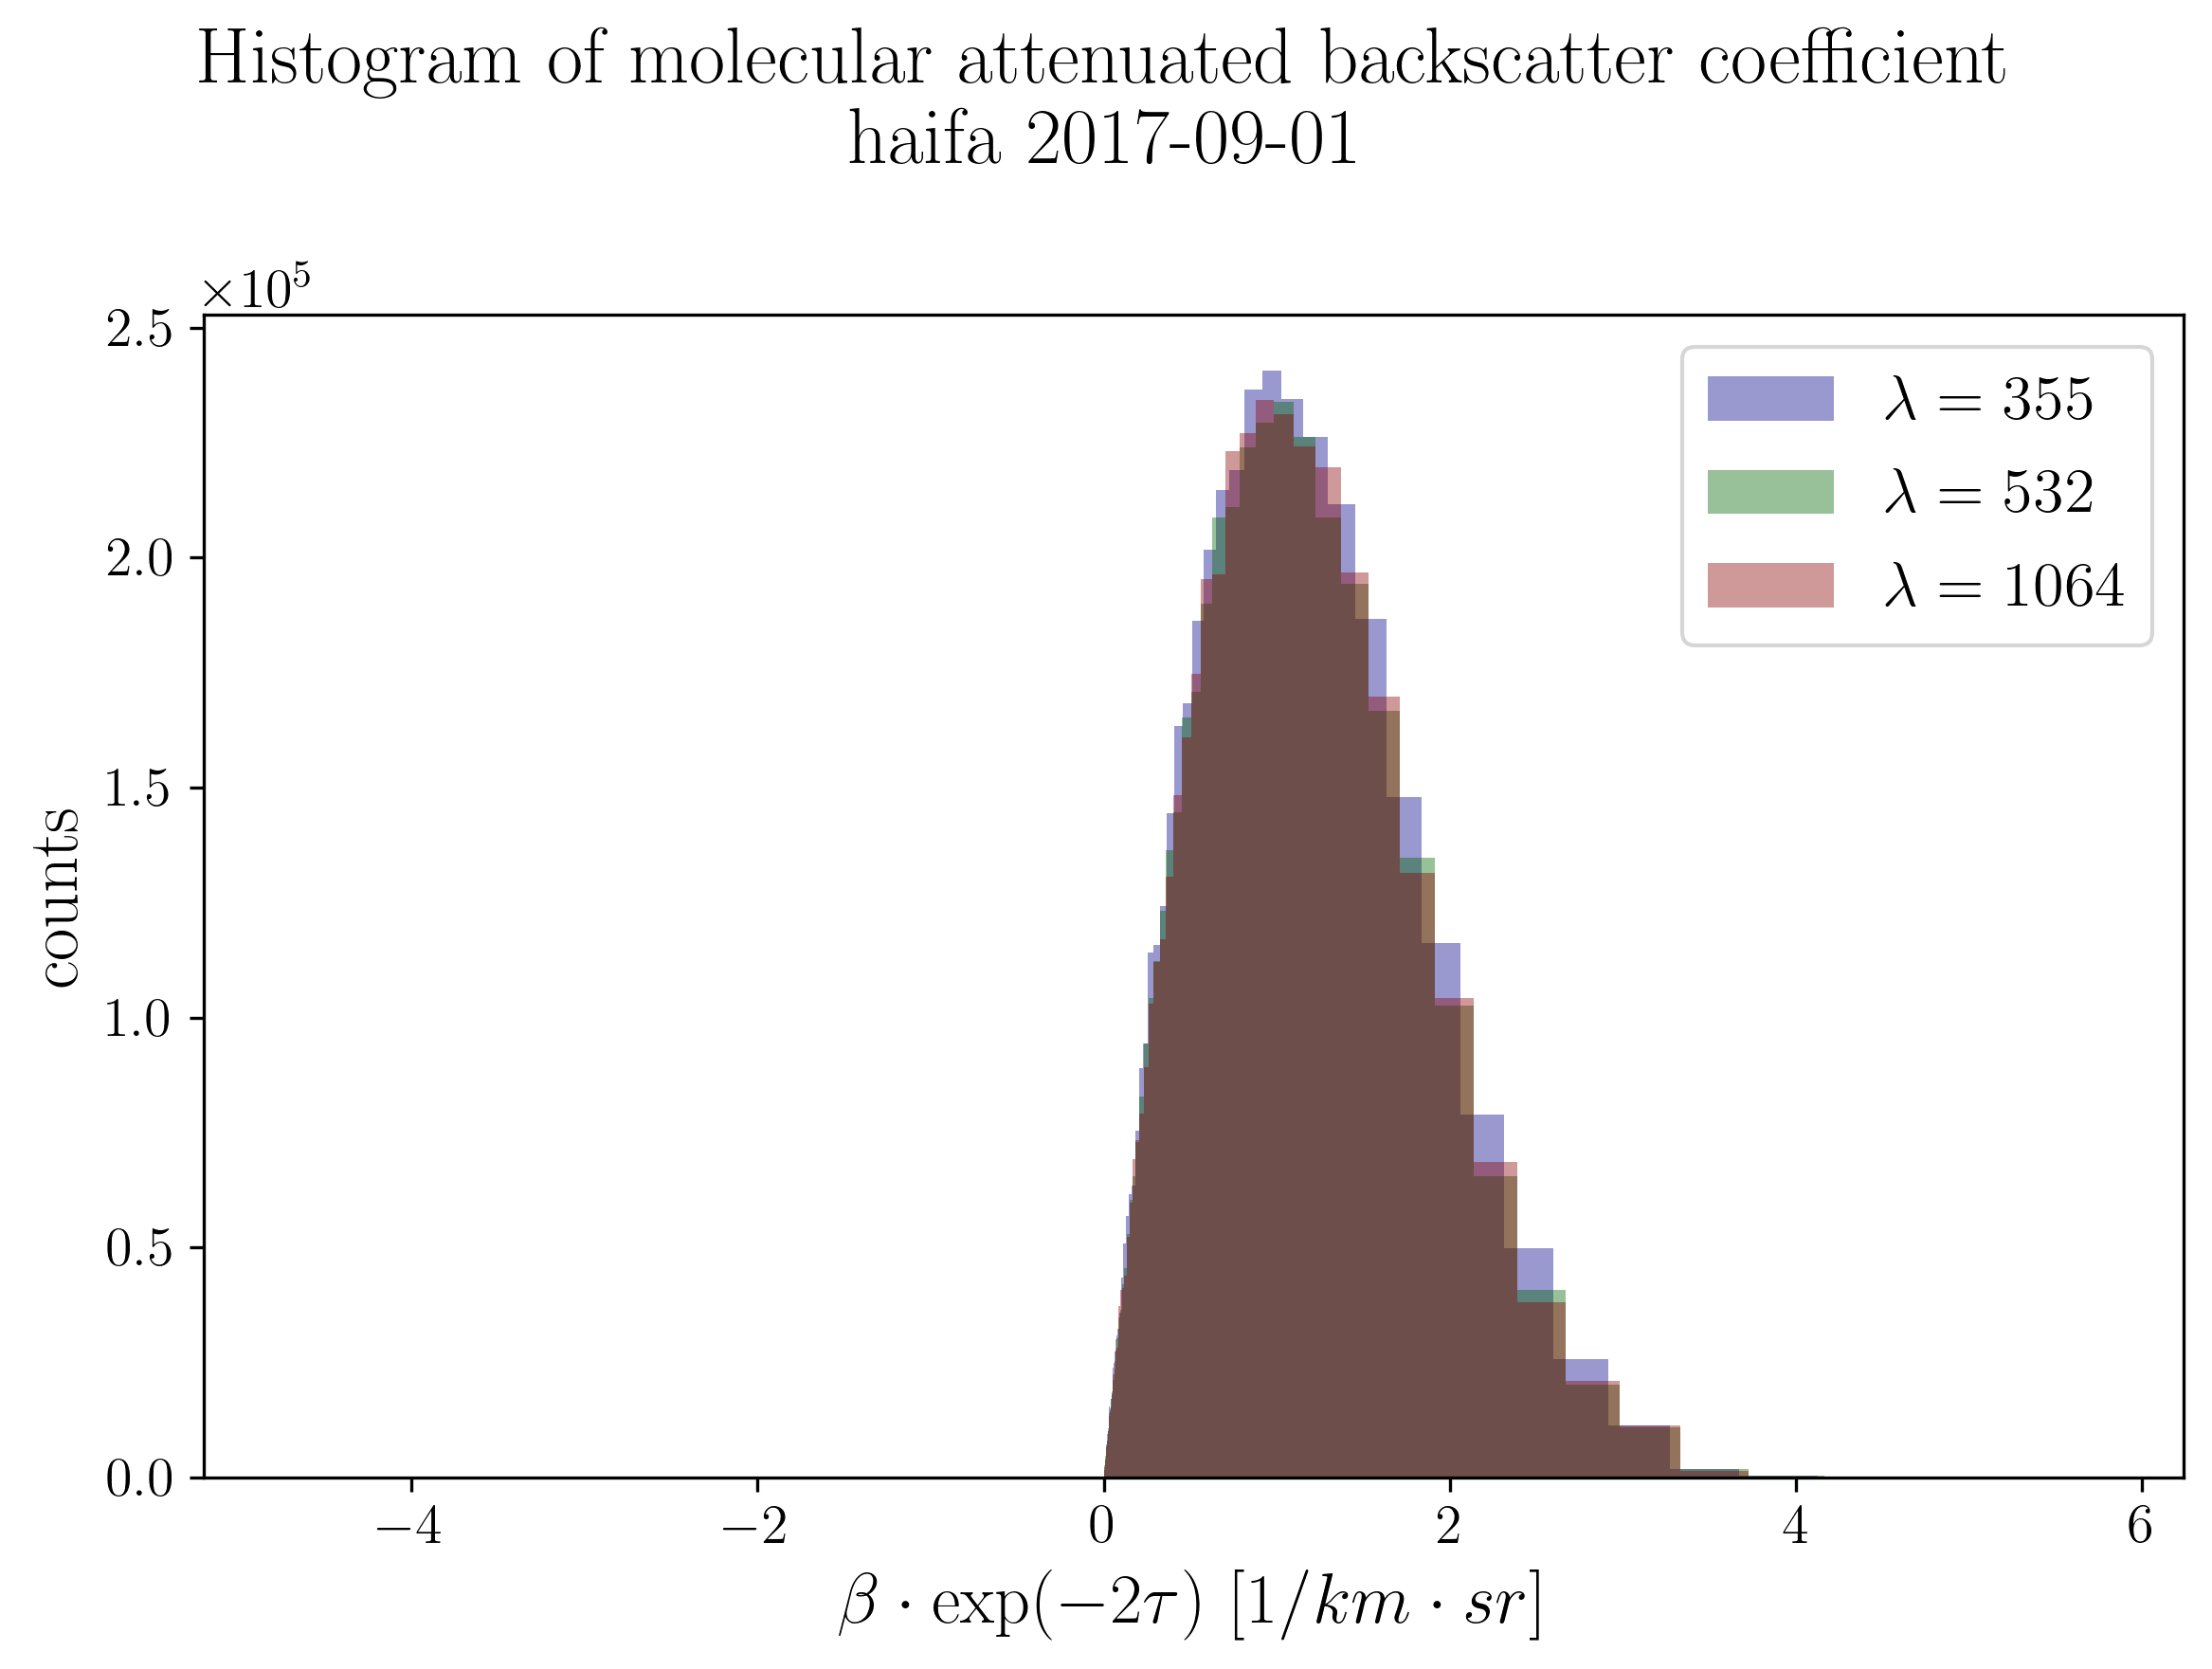

,wavelength [nm],valid size %,positive %,negative %,zeros %,mean,std
0,355,100.0,49.834757,50.165243,0.0,-0.004697742,0.9950338
1,532,100.0,49.859282,50.140718,0.0,-0.0025497454,1.000402
2,1064,100.0,49.962280,50.037720,0.0,-0.011860059,1.0550269


In [30]:
pt = QuantileTransformer(output_distribution='normal')
mol_attbsc_quant_data = pt.fit_transform(mol_ds.attbsc.data.reshape(3,-1).transpose()).transpose().reshape(3,3000,2880)
mol_ds = mol_ds.assign(attbsc_quant = (mol_ds.attbsc.sizes, mol_attbsc_quant_data))
mol_ds.attbsc_quant.attrs.update(mol_ds.attbsc.attrs)
_,_,mol_stats= daily_ds_histogram(mol_ds, profile_type='attbsc_quant',nbins=150)#,log_scale=True)
mol_stats



#